# Imports

In [13]:
import matplotlib.pyplot as plt 
import numpy as np 
import os
import pandas 
import matplotlib.lines as mlines
from scipy.interpolate import interp1d
import scipy.special as sc 
import scipy 

def getFilesInDirectory(directory_path, prefix = None):
    directory = os.fsencode(directory_path)
    files = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".dat") or filename.endswith(".data"):
            if prefix is not None:
                if not filename.startswith(prefix):
                    continue 
            files.append(filename)
    return files

masses = [1e-21, 1e-22, 1e-23]
standard_files = ['fc_cdm.dat', 'fc_m21.dat', 'fc_m22.dat', 'fc_m23.dat']
standard_labels = ["CDM", r"$m = 10^{-21}$eV", r"$m = 10^{-22}$eV", r"$m = 10^{-23}$eV"]
colours = ["C0", "C1", "C2", "C3"]

dpi = 600
size=(3.54 * 1.5, 3.54)

plt.rcParams["font.size"] = 8
plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Ubuntu'
#plt.rcParams['font.monospace'] = 'Ubuntu Mono'
#plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 12

a0 = 0.01
z0 = 99
a1 = 1
zmean = 0.9

#Quantum jeans scale as function of scale factor and mass
#Equation (18) from Li 2020
def li_kj(a, m, omega_m = 0.315903, h = 0.7):
  return h*44.7*(6*a*omega_m/0.3)**(0.25) * (100/70*m/(1e-22))**0.5  #Mpc^-1

#For Lambda CDM
scale_factor, comoving_distance = np.loadtxt("splines/a2com.dat", unpack = True)
redshift = 1/scale_factor - 1
z2com = interp1d(redshift, comoving_distance, kind='cubic')

def q0(z0  = 0.9, beta = 1.5):
    q0m = (z0/beta) * sc.gamma(3/beta)
    return 1/q0m 

def q(z, z0  = 0.9, beta = 1.5):
    return q0(z0, beta) * (z/z0)**2 * np.exp(-(z/z0)**beta)

def k2t(z, k):
    com = z2com(z)
    lam = (2*np.pi)/k
    theta = np.arctan(lam/com)
    return theta


def k2ti(k):
    def integrand(z):
        return k2t(z, k)
    zl = 0.01 
    zh = 98
    return scipy.integrate.quad(integrand, zl, zh)[0]/(zh - zl)


def k2l(z, k):
    return np.pi / k2t(z, k)

def k2li(k):
    return np.pi / k2ti(k) 
    
def lj(m):
    return 0.1 * k2l(zmean, li_kj(a0, m, h = 1))

In [288]:
lj(1e-21), lj(1e-22), lj(1e-23)

(8803.13396119581, 2783.7953971320394, 880.3134331174201)

# Growth Factors

### Einstein - deSitter vs dark energy

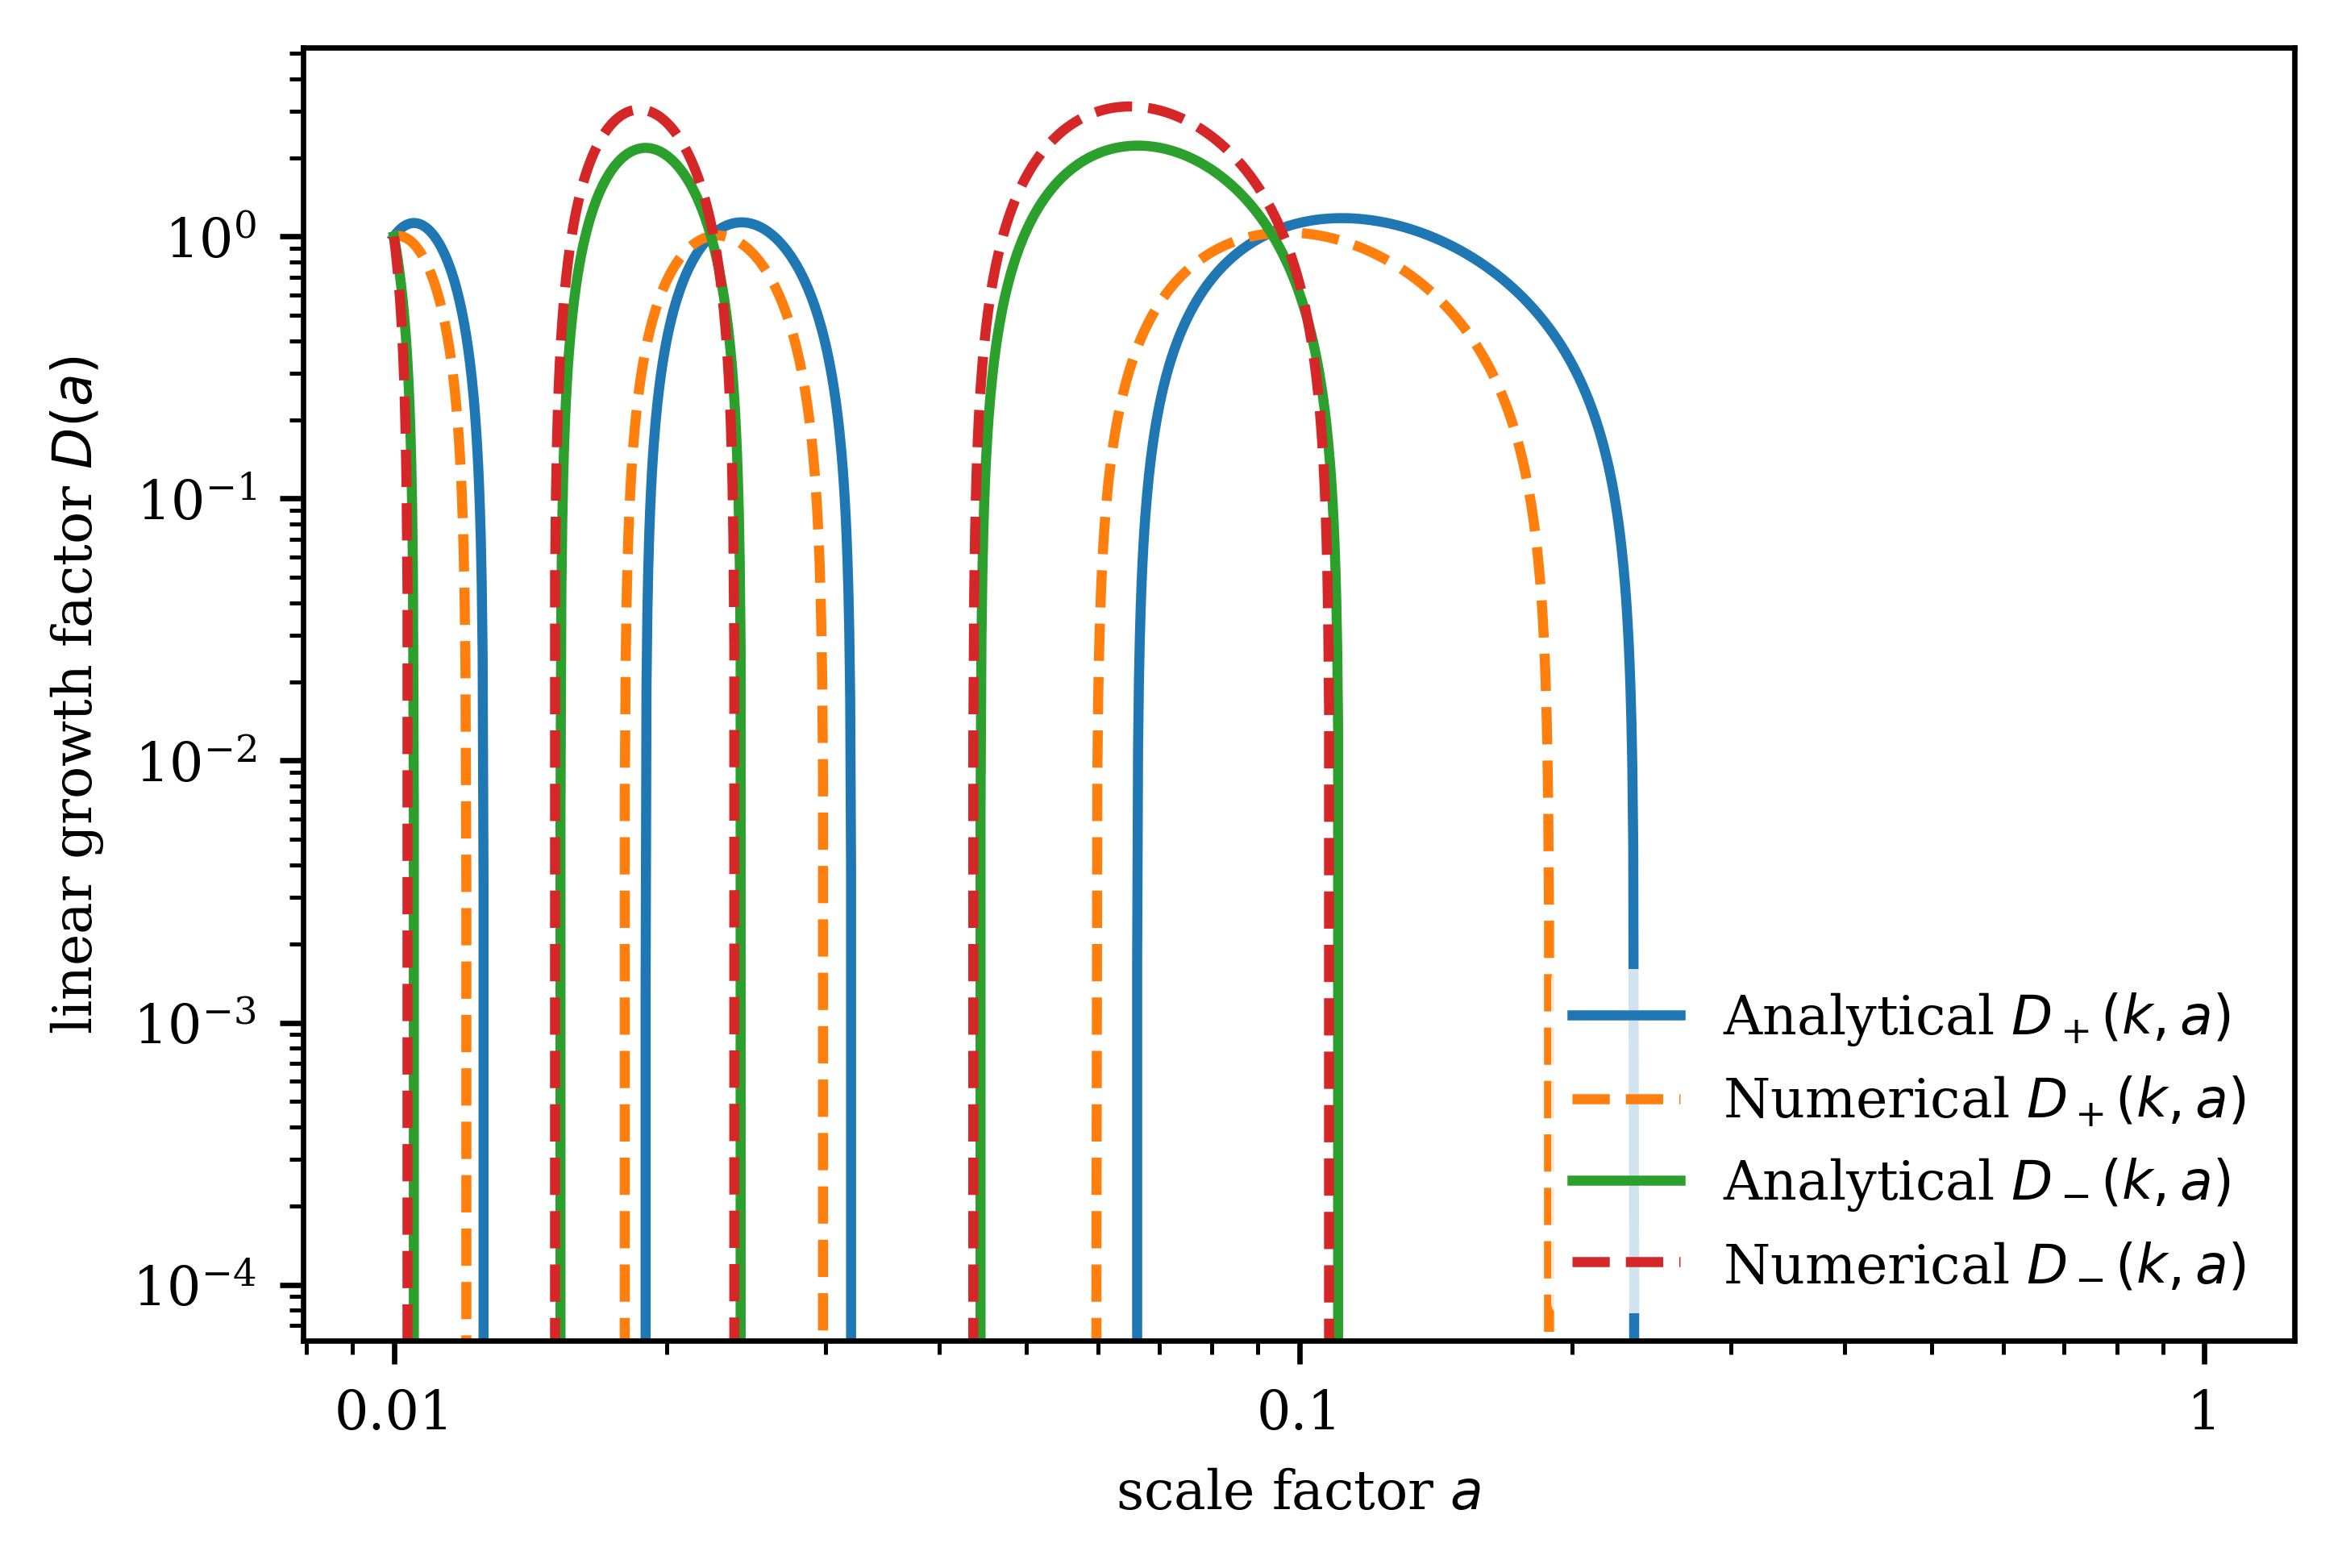

In [226]:
path = "data/growth/"

files = ["eds_m22_k=100.dat"]#, "MDU_k = 25_fdm_m23.dat", "MDU_k = 100_fdm_m23.dat"]
fig, ax = plt.subplots()
fig.set_size_inches(*size)
fig.set_dpi(dpi)

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["+_fdm_ana"], label= "Analytical $D_+(k, a)$")

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["+_fdm_num"], label= "Numerical $D_+(k, a)$", ls = "dashed")

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["-_fdm_ana"], label= "Analytical $D_-(k, a)$")
    
    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["-_fdm_num"], label= "Numerical $D_-(k, a)$", ls = "dashed")


plt.xlabel('scale factor $a$')
plt.ylabel('linear growth factor $D(a)$')
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])

leg = plt.legend(loc='best')
leg.get_frame().set_linewidth(0.0)
plt.show()

### Comparison of growing and decaying modes at k = 25 h/Mpc for different masses

FileNotFoundError: [Errno 2] No such file or directory: 'data/growth/highres/k=25_de_z99_m21.dat'

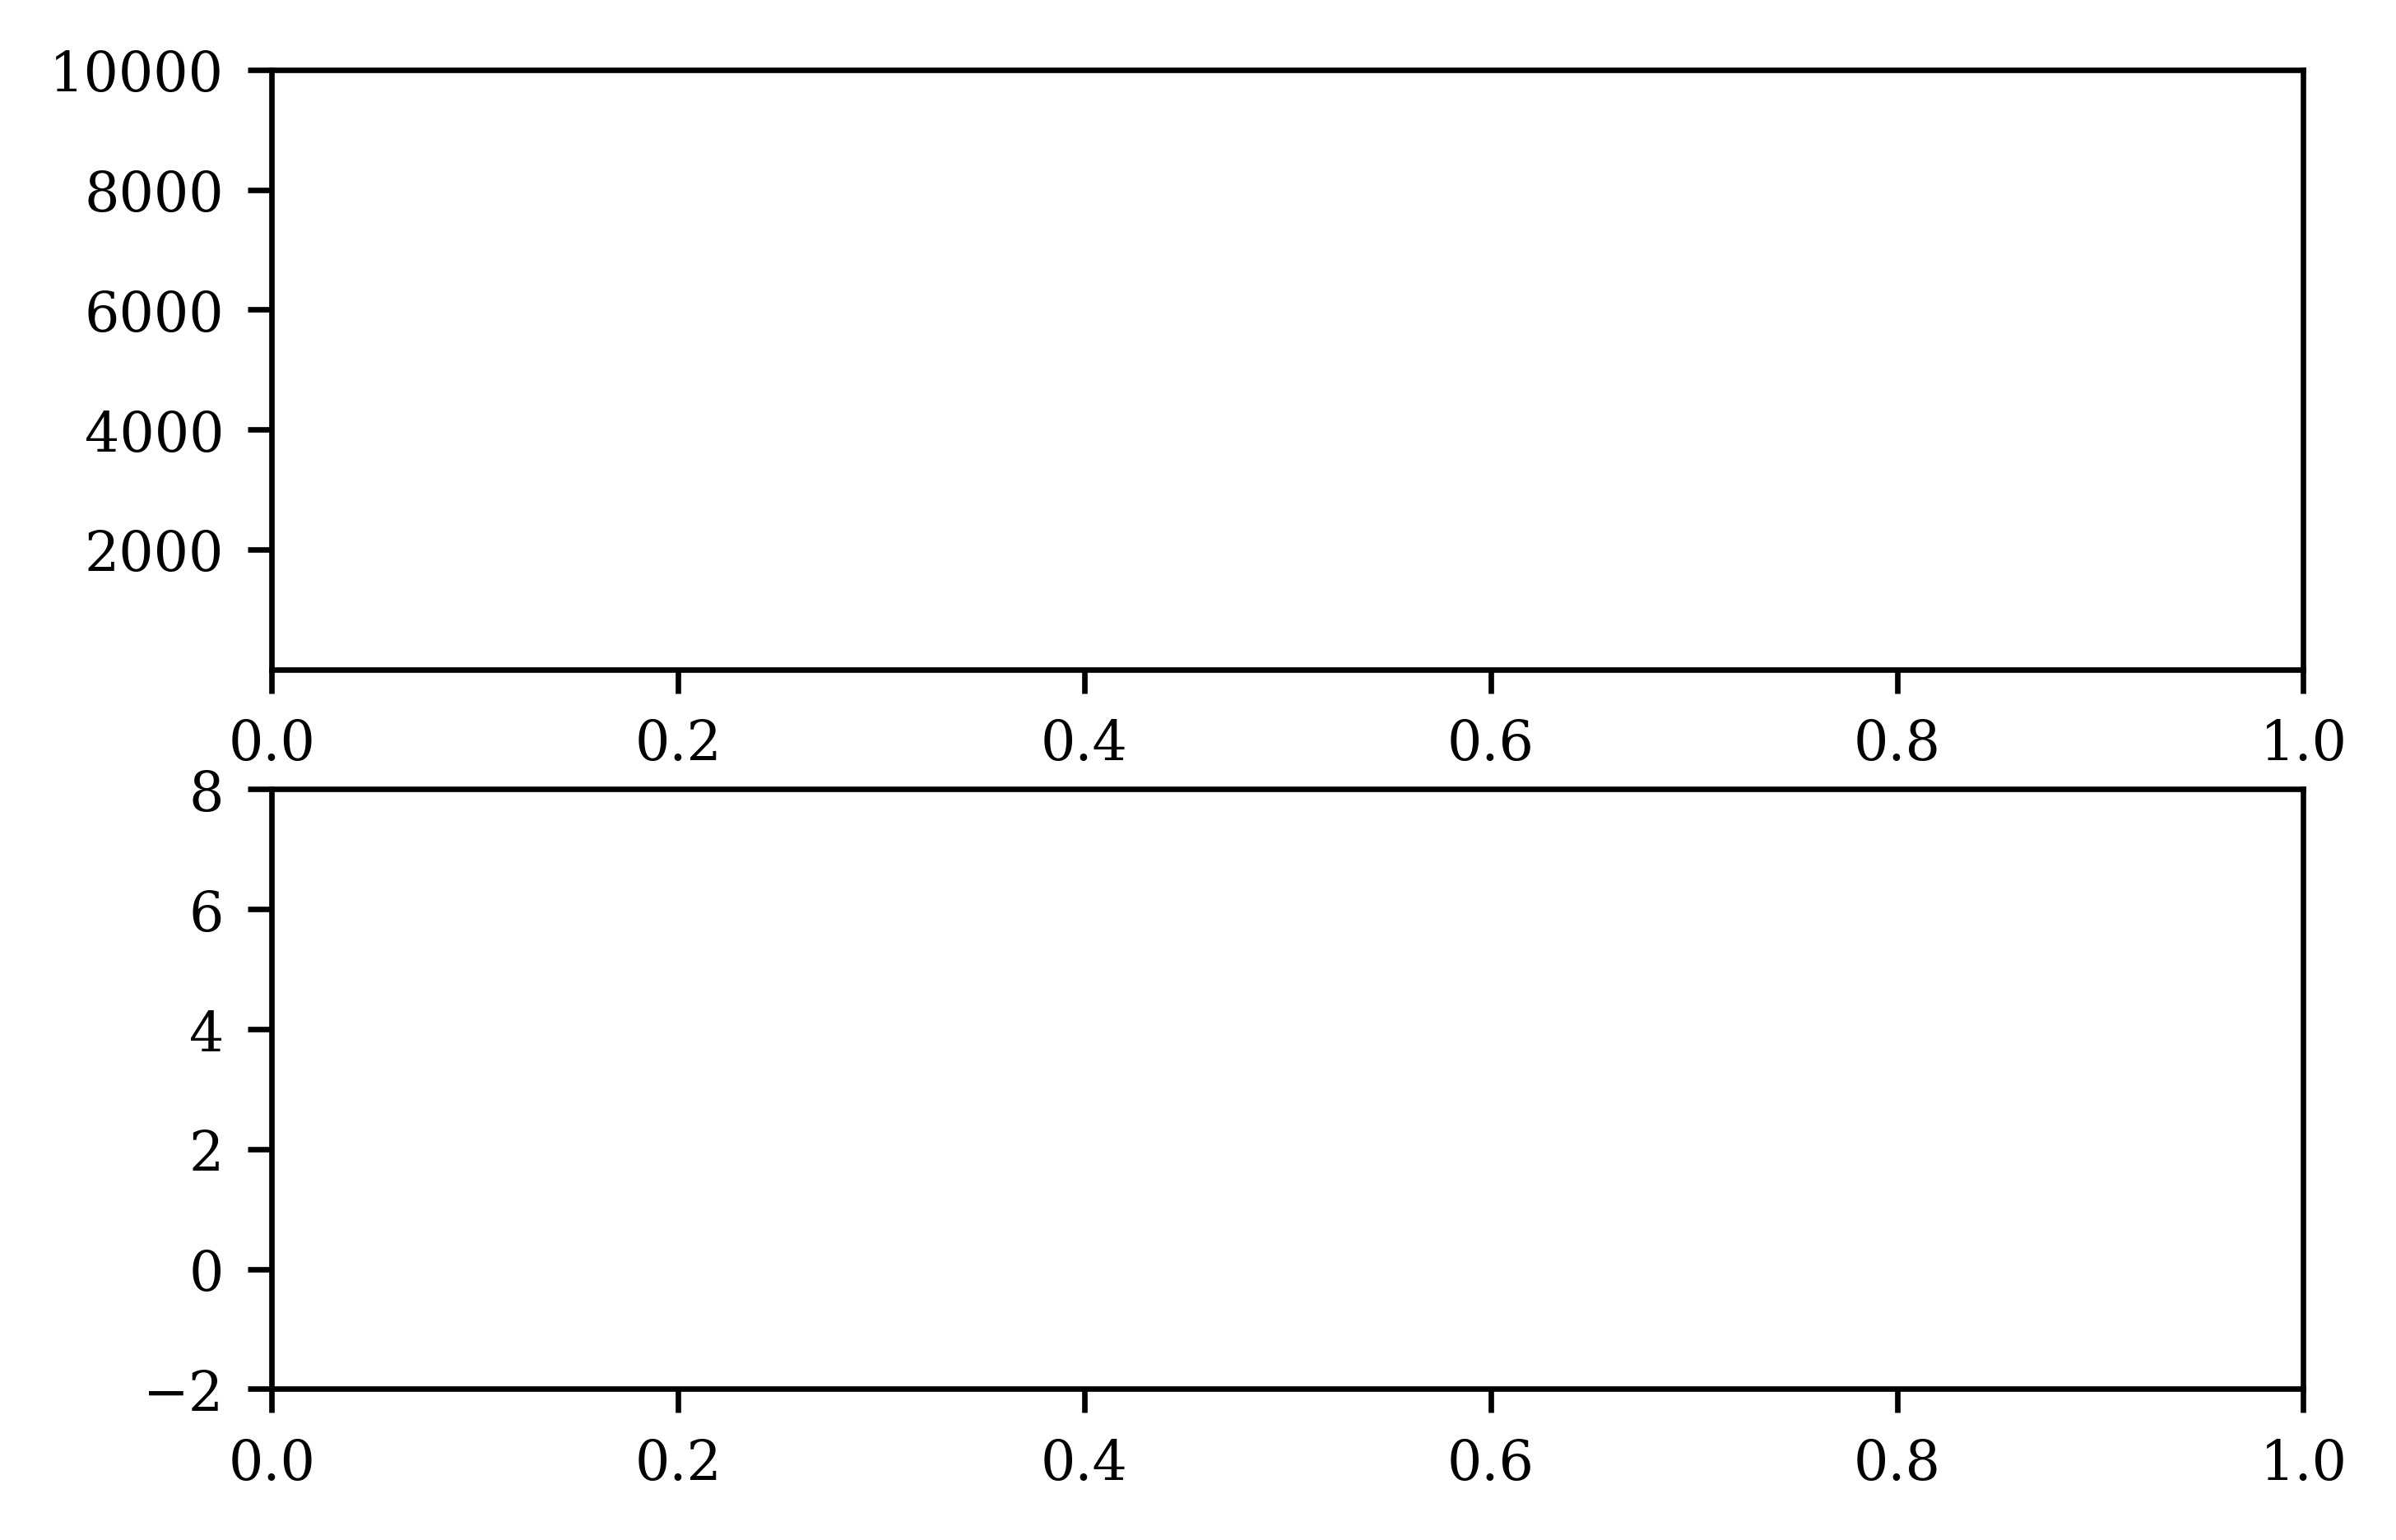

In [227]:
path = "data/growth/highres/"

files = ["k=25_de_z99_m21.dat", "k=25_de_z99_m22.dat","k=25_de_z99_m23.dat"]
labels = [r"$m = 10^{-21}$eV", r"$m = 10^{-22}$eV", r"$m = 10^{-23}$eV"]

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(*size)
fig.set_dpi(dpi)

axs[0].set_ylim([1e-2, 1e4])
axs[1].set_ylim([-2, 8])

i = 0 
file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[0].loglog(data["a"], data["+_cdm_num"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[0].loglog(data["a"], data["+_fdm_num"], label= labels[i])


axs[1].set_xscale("log")
axs[1].plot(data["a"], data["+_cdm_num"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[1].plot(data["a"], data["+_fdm_num"], label= labels[i])


for ax in axs.flat:
    ax.set(xlabel='scale factor $a$')

axs.flat[0].set(ylabel='logarithmic scale')
axs.flat[1].set(ylabel='linear scale')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

leg = axs[1].legend(loc='upper right')
leg.get_frame().set_linewidth(0.0)

plt.subplots_adjust(hspace=0.07) 
#leg = axs[1].legend(loc='best')
#leg.get_frame().set_linewidth(0.0)
fig.align_ylabels(axs[:])
plt.savefig("../figures/growth_same_k_different_mass.pdf", bbox_inches='tight')
plt.show()

In [ ]:
path = "data/growth/highres/"

files = ["k=25_de_z99_m21.dat", "k=25_de_z99_m22.dat","k=25_de_z99_m23.dat"]
labels = [r"$m = 10^{-21}$eV", r"$m = 10^{-22}$eV", r"$m = 10^{-23}$eV"]

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(*size)
fig.set_dpi(dpi)

axs[0].set_ylim([1e-8, 1e1])
axs[1].set_ylim([-2, 2])

i = 0 
file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[0].loglog(data["a"], data["-_cdm_num"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[0].loglog(data["a"], data["-_fdm_num"], label= labels[i])


axs[1].set_xscale("log")
axs[1].plot(data["a"], data["-_cdm_num"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[1].plot(data["a"], data["-_fdm_num"], label= labels[i])


for ax in axs.flat:
    ax.set(xlabel='scale factor $a$')

axs.flat[0].set(ylabel='logarithmic scale')
axs.flat[1].set(ylabel='linear scale')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

leg = axs[0].legend(loc='best')
leg.get_frame().set_linewidth(0.0)
plt.subplots_adjust(hspace=0.07) 
#leg = axs[1].legend(loc='best')
#leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/decay_same_k_different_mass.pdf", bbox_inches='tight')
plt.show()

### Comparison of growing modes for different scales at m = 10^{-22} eV

In [ ]:
path = "data/growth/"
files = ['k=_25_de_z99_m22.dat', 'k=_55_de_z99_m22.dat', 'k=_95_de_z99_m22.dat']#, 'k=1000_de_z99_m22.dat']
labels = ['$k = 25$ $\mathrm{Mpc}^{-1}$', '$k = 55$ $\mathrm{Mpc}^{-1}$', '$k = 95$ $\mathrm{Mpc}^{-1}$']#, '$k = 10^{3}$ $Mpc/h$']

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(*size)
fig.set_dpi(dpi)

axs[0].set_ylim([1e-2, 1e2])
axs[1].set_ylim([-2, 8])

i = 0 
file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[0].loglog(data["a"], data["+_cdm_num"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[0].loglog(data["a"], data["+_fdm_num"], label= labels[i])


files = ['k=_25_de_z99_m22.dat', 'k=_55_de_z99_m22.dat', 'k=_95_de_z99_m22.dat']#, 'k=1000_de_z99_m22.dat']
labels = ['$k = 25$ $\mathrm{Mpc}^{-1}$', '$k = 55$ $\mathrm{Mpc}^{-1}$', '$k = 95$ $\mathrm{Mpc}^{-1}$']#, '$k = 10^{3}$ $Mpc/h$']

axs[1].set_xscale("log")
axs[1].plot(data["a"], data["+_cdm_num"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[1].plot(data["a"], data["+_fdm_num"], label= labels[i])


for ax in axs.flat:
    ax.set(xlabel='scale factor $a$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

axs.flat[0].set(ylabel='logarithmic scale')
axs.flat[1].set(ylabel='linear scale')

leg = axs[1].legend(loc='upper right')
leg.get_frame().set_linewidth(0.0)
plt.subplots_adjust(hspace=0.07) 
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
fig.align_ylabels(axs[:])
plt.savefig("../figures/growth_same_mass_different_k.pdf", bbox_inches='tight')
plt.show()

### Comparison of decaying modes for different masses at m = 10^{-22} eV

In [ ]:
path = "data/growth/"
files = ['k=_25_de_z99_m22.dat', 'k=_55_de_z99_m22.dat', 'k=_95_de_z99_m22.dat']#, 'k=1000_de_z99_m22.dat']
labels = ['$k = 25$ $\mathrm{Mpc}^{-1}$', '$k = 55$ $\mathrm{Mpc}^{-1}$', '$k = 95$ $\mathrm{Mpc}^{-1}$']#, '$k = 10^{3}$ $Mpc/h$']

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(*size)
fig.set_dpi(dpi)

axs[0].set_ylim([1e-4, 1e2])

i = 0 
file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[0].loglog(data["a"], data["-_cdm_num"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[0].loglog(data["a"], data["-_fdm_num"], label= labels[i])


files = ['k=_25_de_z99_m22.dat', 'k=_55_de_z99_m22.dat', 'k=_95_de_z99_m22.dat']#, 'k=1000_de_z99_m22.dat']
labels = ['$k = 25$ $\mathrm{Mpc}^{-1}$', '$k = 55$ $\mathrm{Mpc}^{-1}$', '$k = 95$ $\mathrm{Mpc}^{-1}$']#, '$k = 10^{3}$ $Mpc/h$']

axs[1].set_xscale("log")
axs[1].plot(data["a"], data["-_cdm_num"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[1].plot(data["a"], data["-_fdm_num"], label= labels[i])


for ax in axs.flat:
    ax.set(xlabel='scale factor $a$')


axs.flat[0].set(ylabel='logarithmic scale')
axs.flat[1].set(ylabel='linear scale')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


#ax1.set_xlabel("scale factor $a$")
#ax1.set_ylabel("growing mode $D_+(a, k)$")
axs[0].legend(loc='best')
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
leg = axs[0].legend(loc='upper right')
leg.get_frame().set_linewidth(0.0)
plt.subplots_adjust(hspace=0.07) 
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
fig.align_ylabels(axs[:])
plt.savefig("../figures/decay_same_mass_different_k.pdf", bbox_inches='tight')
plt.show()

### Analytical growth

In [ ]:
path = "data/growth/"
files = ['k=_25_de_z99_m22.dat', 'k=_55_de_z99_m22.dat', 'k=_95_de_z99_m22.dat']#, 'k=1000_de_z99_m22.dat']
labels = ['$k = 25$ $h$/Mpc', '$k = 55$ $h$/Mpc', '$k = 95$ $h$/Mpc']#, '$k = 10^{3}$ $Mpc/h$']

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(3.54 * 2, 3.54*2)
fig.set_dpi(dpi)

axs[0].set_ylim([1e-2, 1e3])
axs[1].set_ylim([-6, 8])
axs[2].set_ylim([1e-4, 1e2])
axs[3].set_ylim([-10, 10])

file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[0].loglog(data["a"], data["+_cdm_ana"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[0].loglog(data["a"], data["+_fdm_ana"], label= labels[i])


axs[1].set_xscale("log")
axs[1].plot(data["a"], data["+_cdm_ana"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[1].plot(data["a"], data["+_fdm_ana"], label= labels[i])


i = 0 
file = files[0]
data = pandas.read_csv(path + file, delim_whitespace=True)
axs[2].loglog(data["a"], data["-_cdm_ana"], label="CDM")

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[2].loglog(data["a"], data["-_fdm_ana"], label= labels[i])


axs[3].set_xscale("log")
axs[3].plot(data["a"], data["-_cdm_ana"], label="CDM")
for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    axs[3].plot(data["a"], data["-_fdm_ana"], label= labels[i])


axs.flat[0].set(ylabel='$D_+$: logarithmic scale')
axs.flat[1].set(ylabel='$D_+$: linear scale')
axs.flat[2].set(ylabel='$D_-$: logarithmic scale')
axs.flat[3].set(ylabel='$D_-$: linear scale')

for ax in axs.flat:
    ax.set(xlabel='scale factor $a$')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


#ax1.set_xlabel("scale factor $a$")
#ax1.set_ylabel("growing mode $D_+(a, k)$")
axs[0].legend(loc='best')
plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
leg = axs[0].legend(loc='lower left')
leg.get_frame().set_linewidth(0.0)
plt.subplots_adjust(hspace=0.07) 
plt.savefig("../figures/analytical_growth_and_decay.pdf", bbox_inches='tight')
plt.show()

### Comparison of analytical and numerical FDM growth factors

#### Growth

In [ ]:
data = np.load("data/growth/nonorthogonality.npz")
fig = plt.figure()
fig.set_size_inches(*size)
fig.set_dpi(dpi)
plt.xscale("log")
plt.xlim(0.1, 1)
plt.plot(data["a"], data["Dp_ana"], label="Analytical growing mode", c=colours[0])
plt.plot(data["a"], data["Dm_ana"], label="Analytical decaying mode", c=colours[1])
plt.plot(data["a"], data["Dp_num"], label="Numerical growing mode", ls = "dashed", c=colours[0])
plt.plot(data["a"], data["Dm_num"], label="Numerical decaying mode", ls = "dashed", c=colours[1])
plt.xlabel("scale factor $a$")
plt.ylabel("D(k, a)")
leg = plt.legend(loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are of
#plt.tick_params(
#    axis='y',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelleft=False) # labels along the bottom edge are of
plt.savefig("../figures/orthogonaloscillations.pdf", bbox_inches='tight')
plt.show() 

In [ ]:
import matplotlib.pyplot as plt 


fig = plt.figure()
fig.set_size_inches(*size)
fig.set_dpi(dpi)
gs = fig.add_gridspec(3, 2, wspace=0, hspace=0.4)
axs = gs.subplots()

scale = 100

t = np.arange(len(data["a"]))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()
ax1.set_xlabel(r"$\frac{\mathrm{d}D(k, a)}{\mathrm{d}a}$")
ax1.set_ylabel("D(k, a)")
ax1.scatter(data["dDp_num"], data["Dp_num"], label="Numerical growing mode" , s = scale * 1/(t+1))
ax1.scatter(data["dDm_num"], data["Dm_num"], label="Numerical decaying mode", s = scale * 1/(t+1))

ax2.set_xlabel(r"$\frac{\mathrm{d}D(k, a)}{\mathrm{d}a}$")
ax2.scatter(data["dDp_ana"], data["Dp_ana"], label="Analytical growing mode" , s = scale * 1/(t+1))
ax2.scatter(data["dDm_ana"], data["Dm_ana"], label="Analytical decaying mode", s = scale * 1/(t+1))

ax3.set_xlabel(r"$\frac{\mathrm{d^2}D(k, a)}{\mathrm{d}a^2}$")
ax3.set_ylabel(r"$\frac{\mathrm{d}D(k, a)}{\mathrm{d}a}$")
ax3.scatter(data["ddDp_num"], data["dDp_num"], label="Numerical growing mode" , s = scale * 1/(t+1))
ax3.scatter(data["ddDm_num"], data["dDm_num"], label="Numerical decaying mode", s = scale * 1/(t+1))

ax4.set_xlabel(r"$\frac{\mathrm{d^2}D(k, a)}{\mathrm{d}a^2}$")
ax4.scatter(data["ddDp_ana"], data["dDp_ana"], label="Analytical growing mode" , s = scale * 1/(t+1))
ax4.scatter(data["ddDm_ana"], data["dDm_ana"], label="Analytical decaying mode", s = scale * 1/(t+1))


ax5.set_xlabel(r"$\frac{\mathrm{d^2}D(k, a)}{\mathrm{d}a^2}$")
ax5.set_ylabel("D(k, a)")
ax5.scatter(data["ddDp_num"], data["Dp_num"], label="Numerical growing mode" , s = scale * 1/(t+1))
ax5.scatter(data["ddDm_num"], data["Dm_num"], label="Numerical decaying mode", s = scale * 1/(t+1))

ax6.set_xlabel(r"$\frac{\mathrm{d^2}D(k, a)}{\mathrm{d}a^2}$")
ax6.scatter(data["ddDp_ana"], data["Dp_ana"], label="Analytical growing mode" , s = scale * 1/(t+1))
ax6.scatter(data["ddDm_ana"], data["Dm_ana"], label="Analytical decaying mode", s = scale * 1/(t+1))

for ax in axs.flatten():
    ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelbottom=False) # labels along the bottom edge are off
    ax.set_yticks([])

# Hide x labels and tick labels for all but bottom plot.

fig.align_ylabels(axs[:])
plt.savefig("../figures/DdDddD_b_growing_o_decaying.pdf", bbox_inches='tight')
plt.show()

In [ ]:
path = "data/growth/anavsnum/"

files = ["MDU_k = 25_fdm_m23.dat"]#, "MDU_k = 25_fdm_m23.dat", "MDU_k = 100_fdm_m23.dat"]
labels = [""]#, "$k = 25 $h$/Mpc", "$k = 100 $h$/Mpc"]
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(*size)
fig.set_dpi(dpi)

plt.sca(ax[0])

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["+_fdm_ana"], label= "Analytical FDM " + labels[i])

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["+_fdm_ren"], label= "Renormalised FDM " + labels[i])

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["+_fdm_num"], label= "Numerical FDM " + labels[i])


ax[0].set_ylabel('growing mode $D_+(k, a)$')
plt.sca(ax[1])

for i, file in enumerate(files):
    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["-_fdm_ana"], label= "Analytical FDM " + labels[i])

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["-_fdm_ren"]/data["-_fdm_ren"][0], label= "Renormalised FDM " + labels[i], ls = "dashed")

    data = pandas.read_csv(path + file, delim_whitespace=True)
    plt.loglog(data["a"], data["-_fdm_num"], label= "Numerical FDM " + labels[i], ls = "dashed")


ax[1].set_xlabel('scale factor $a$')
ax[1].set_ylabel('decaying mode $D_-(k, a)$')

ax[0].set_xticks([])

plt.subplots_adjust(hspace=0.07) 

plt.xticks([0.01, 0.1, 1], [0.01, 0.1, 1])
leg = plt.legend(loc="lower right")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/analytical_numerical_comparison_k25.pdf", bbox_inches='tight')
plt.show()

## Fit model

In [ ]:
#Prepare data
data = np.load("data/growth/mdu_fit.npz")
x = data["x"]
y = data["y"]
X = data["X"]
Y = data["Y"]
Z = data["Z"]
fit = data["fit"]

logx = np.log10(x)
logy = np.log10(y)
logX = np.log10(X)
logY = np.log10(Y)
logZ = np.log10(np.abs(Z))

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(3.54*2, 3.54), dpi = dpi)


# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_surface(logX, logY, logZ, cmap='inferno', vmin = np.log10(0.1), vmax = np.log10(1e2))
ax.set_xlabel("momentum $k$ in $\mathrm{Mpc}^{-1}$")
ax.set_ylabel("scale factor $a$")
ax.set_xticks([-4, -2, 0, 2], ["$10^{-4}$", "$10^{-2}$", "$10^{0}$","$10^{2}$"])
ax.set_yticks([-2, -1, 0], ["0.01", "0.1", "1"])
ax.set_zticks([-8, -4, 0, 4], ["$10^{-8}$", "$10^{-4}$", "$10^{0}$","$10^{4}$"])

ax.set_zlim(-14, 2)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')

im = ax.plot_surface(logX, logY, np.log10(fit), cmap='inferno', vmin = np.log10(0.1), vmax = np.log10(1e2))
ax.set_xlabel("momentum $k$ in $\mathrm{Mpc}^{-1}$")
ax.set_ylabel("scale factor $a$")

ax.set_xticks([-4, -2, 0, 2], ["$10^{-4}$", "$10^{-2}$", "$10^{0}$","$10^{2}$"])
ax.set_yticks([-2, -1, 0], ["0.01", "0.1", "1"])
ax.set_zticks([-8, -4, 0, 4], ["$10^{-8}$", "$10^{-4}$", "$10^{0}$","$10^{4}$"])
cset = ax.contourf(logX, logY, logZ, zdir='z', offset=-14, cmap='inferno')

ax.set_zlim(-14, 2)

fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.85, 0.25, 0.02, 0.5])
c = fig.colorbar(im, cax=cbar)

c.set_ticks([-1, 0, 1, 2], labels= ["$10^{-1}$", "$10^{0}$", "$10^{1}$", "$10^{2}$"])
#plt.subplots_adjust(wspace=0.06) 
plt.savefig("../figures/fit.pdf", bbox_inches='tight')
plt.show()


# FDM suppression

In [ ]:
path = "data/fdm_suppression/"
files = ['eds_m23a=1.000000.dat']

fig = plt.figure(figsize=size, dpi=dpi)



fig.set_size_inches(*size)
fig.set_dpi(dpi)

gs = fig.add_gridspec(2, 1, hspace=0.07)
ax = gs.subplots(sharex=True)

plt.xlabel('momentum $k$ in $\mathrm{Mpc}^{-1}$')
ax[1].set_ylabel('linear scale')
ax[0].set_ylabel('logarithmic scale')

ax[0].set_xlim(1e-0, 1e2)
ax[0].set_ylim(1e-8, 1e2)
ax[0].set_yscale("log")
ax[0].set_xscale("log")
ax[1].set_xlim(1e-0, 1e2)
ax[1].set_ylim(-.5, 1.5)
ax[1].set_yticks([-1, 0, 1])
ax[1].set_xscale("log")

for file in files:
    data = pandas.read_csv(path + file, delim_whitespace=True)
    ax[0].plot(data["k"], data["fdm_ana"])
    ax[0].plot(data["k"], data["fdm_ren"])
    ax[0].plot(data["k"], data["fdm_fit"])
    ax[0].plot(data["k"], data["fdm_num"])
    ax[1].plot(data["k"], data["fdm_ana"], label="Analytical")
    ax[1].plot(data["k"], data["fdm_ren"], label="Renormalised")
    ax[1].plot(data["k"], data["fdm_fit"], label="Mean growth model")
    ax[1].plot(data["k"], data["fdm_num"], label="Numerical")
ax[0].axvline(li_kj(.01, 1e-23, 1), c="r", ls = "dashed")
ax[1].axvline(li_kj(.01, 1e-23, 1), c="r", label="Jeans scale", ls = "dashed")

fig.align_ylabels(ax[:])
plt.subplots_adjust(hspace=0.07) 
leg = plt.legend(loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/fdm_suppression.pdf", bbox_inches='tight')
plt.show()

### Suppression maps

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable



Z = np.load("data/growth/z_used_for_suppression_map.npy")

titles =[   r"$D_+(k, a)$",
            r"$D_-(k, a)$", 
        ]

labels =[
        r"Analytical", 
        r"Renormalised", 
        r"Numerical", 
        r"Mean growth model",
        r"CDM"]

plotJeans = True 

titles =[   r"$D_+$", 
            r"$D_-$", 
        ]



N_k = 50
N_a = 500
k_vec = np.logspace(-4, 4, N_k)
a_vec = np.logspace(-2, 0, N_a)

for m, title in enumerate(titles):
    fig, axes = plt.subplots(len(labels), 1, sharex="all")
    for l, label in enumerate(labels):
        ax = axes[l]

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)

        ax.set_title(label)
        fig.set_size_inches(np.flip(size))
        fig.set_dpi(dpi)

        ax.set_xlim([-4, 3])
        ax.set_yticks([-2, -1, 0], ["$10^{-2}$", "$10^{-1}$", "$10^{0}$"])
    

        #ax.set_zlabel(r"$D(a, k)$")
        logZ = np.log10(np.abs(Z[m, l, :, :]))
        loga = np.log10(a_vec)
        logk = np.log10(k_vec)
        extent = [logk.min(), logk.max(), loga.min(), loga.max()]
        print(extent)
        L_k    = extent[1] - extent[0]
        L_a    = extent[3] - extent[2]
        
        im = ax.imshow(logZ.T, origin='lower', cmap='inferno', 
                    extent=extent, vmin=-4, vmax=2)

        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([-4, -2, 0, 2], labels= ["$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$"])

        fig.subplots_adjust(hspace=0.5)
        #fig.colorbar(ax, shrink=1, aspect=5)
    axes[-1].set_xlabel(r"momentum $k$ in $\mathrm{Mpc}^{-1}$")
    axes[-1].set_xticks([-4, -2, 0, 2], ["$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$"])
        
    axes[2].set_ylabel(r"scale factor $a$")

    plt.savefig(f"../figures/suppresion_map_{m}.pdf", bbox_inches='tight')
    plt.show()

### F2 comparison

In [ ]:
data = np.load("data/spectrum/f2_comparison_mdu.npz")

f2_cdm = data["f2_cdm"]
f2_fdm = data["f2_fdm"]
f2_cdm_td = data["f2_cdm_td"]

plt.rcParams["font.size"] = 10
fig = plt.figure(figsize=(3.54 *2, 3.54), dpi = 600)
gs = fig.add_gridspec(1, 6, wspace=0)
ax = gs.subplots(sharey=True)

im1 = ax[0].imshow(np.sign(f2_fdm)*np.log10(np.abs(f2_fdm)), cmap="inferno",                   extent = [1, -1, -4, 2], aspect="auto")
im1 = ax[1].imshow(np.sign(f2_cdm)*np.log10(np.abs(f2_cdm)), cmap="inferno",                   extent = [1, -1, -4, 2], aspect="auto")
im3 = ax[2].imshow(np.sign(f2_cdm_td)*np.log10(np.abs(f2_cdm_td)), cmap="inferno",                extent = [1, -1, -4, 2], aspect="auto")
im2 = ax[3].imshow(np.abs(f2_cdm_td - f2_cdm)/(np.abs(f2_cdm)), cmap="binary", vmin=0, vmax=0.02,           extent = [1, -1, -4, 2], aspect="auto")
im2 = ax[4].imshow(np.abs(f2_cdm    - f2_fdm)/(np.abs(f2_cdm)), cmap="binary", vmin=0, vmax=0.02,           extent = [1, -1, -4, 2], aspect="auto")
im2 = ax[5].imshow(np.abs(f2_cdm_td - f2_fdm)/(np.abs(f2_cdm)), cmap="binary", vmin=0, vmax=0.02,           extent = [1, -1, -4, 2], aspect="auto")

ax[0].set_title("$FDM$", pad=10)
ax[1].set_title("$CDM$", pad=10)
ax[2].set_title("$CDM_{td}$", pad=10)
ax[3].set_title(r"$|\frac{CDM - CDM_{td}}{CDM}|$", pad=10)
ax[4].set_title(r"$|\frac{CDM - FDM}{CDM}|$", pad=10)
ax[5].set_title(r"$|\frac{CDM_{td} - FDM}{CDM}|$", pad=10)
ax[0].set_ylabel(r"momentum $k_1$ in $\mathrm{Mpc}^{-1}$")
fig.text(0.46, -0.03, r"angle $\theta$ between $\vec{k}_1$ and $\vec{k}_2$ with $k_2 = 10^{-3}$ $\mathrm{Mpc}^{-1}$", ha='center')
for a in ax:
    a.set_yticks([-4, -2, 0, 2])
    a.set_yticklabels(["$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$"])
    a.set_xticks([np.sqrt(2)/2, 0, -np.sqrt(2)/2])
    a.set_xticklabels([r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$"])


#fig.subplots_adjust(right=0.8)
#cbar1 = fig.add_axes([0.83, 0.15, 0.03, 0.7])
#cbar2 = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#cbar1 = fig.colorbar(im3, cax=cbar1, ticks=[-10, -5, 0, 5, 10])
#cbar2 = fig.colorbar(im2, cax=cbar2, ticks=[0, 0.02])
cbar2 = fig.colorbar(im2, ticks=[0, 0.02])
#cbar1.ax.set_yticklabels(["$10^{-10}$", "$10^{-5}$", "$10^{0}$", "$10^{5}$", "$10^{10}$"])
cbar2.ax.set_yticklabels(["0", "$\geq 2\%$"])
#plt.colorbar(ax = ax[0])
plt.savefig("../figures/k=1e-3m=23_f2_comparison.pdf", bbox_inches='tight')
plt.show()

In [ ]:
data = np.load("data/spectrum/f2_comparison_mdu.npz")

f2_cdm = data["f2_cdm"]
f2_fdm = data["f2_fdm"]
f2_cdm_td = data["f2_cdm_td"]

plt.rcParams["font.size"] = 7
fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(3.54, 3.54), dpi = 600, gridspec_kw={'width_ratios': [1, 1]}, sharey=True)

im1 = ax[0].imshow(np.sign(f2_fdm) * np.log10(np.abs(f2_fdm)), cmap="inferno", extent = [1, -1, -4, 2], aspect="equal")
im2 = ax[1].imshow(np.sign(f2_cdm) * np.log10(np.abs(f2_cdm)), cmap="inferno", extent = [1, -1, -4, 2], aspect="equal")

ax[0].title.set_text("$FDM$")
ax[1].title.set_text("$CDM$")
ax[0].set_ylabel(r"momentum $k_1$ in $\mathrm{Mpc}^{-1}$")
fig.text(0.46, 0.0, r"angle $\theta$ between $\vec{k}_1$ and $\vec{k}_2$ with $k_2 = 10^{-3}$ $\mathrm{Mpc}^{-1}$", ha='center')
for a in ax:
    a.set_yticks([-4, -2, 0, 2])
    a.set_yticklabels(["$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$"])
    a.set_xticks([np.sqrt(2)/2, 0, -np.sqrt(2)/2])
    a.set_xticklabels([r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$"])

cbar1 = fig.colorbar(im2)
#cbar1.ax.set_yticklabels(["$10^{-10}$", "$10^{-5}$", "$10^{0}$"])
#plt.colorbar(ax = ax[0])
fig.tight_layout()
plt.savefig("../figures/k=1e-3m=23_f2_cdm_fdm_comparison.pdf", bbox_inches='tight')
plt.show()

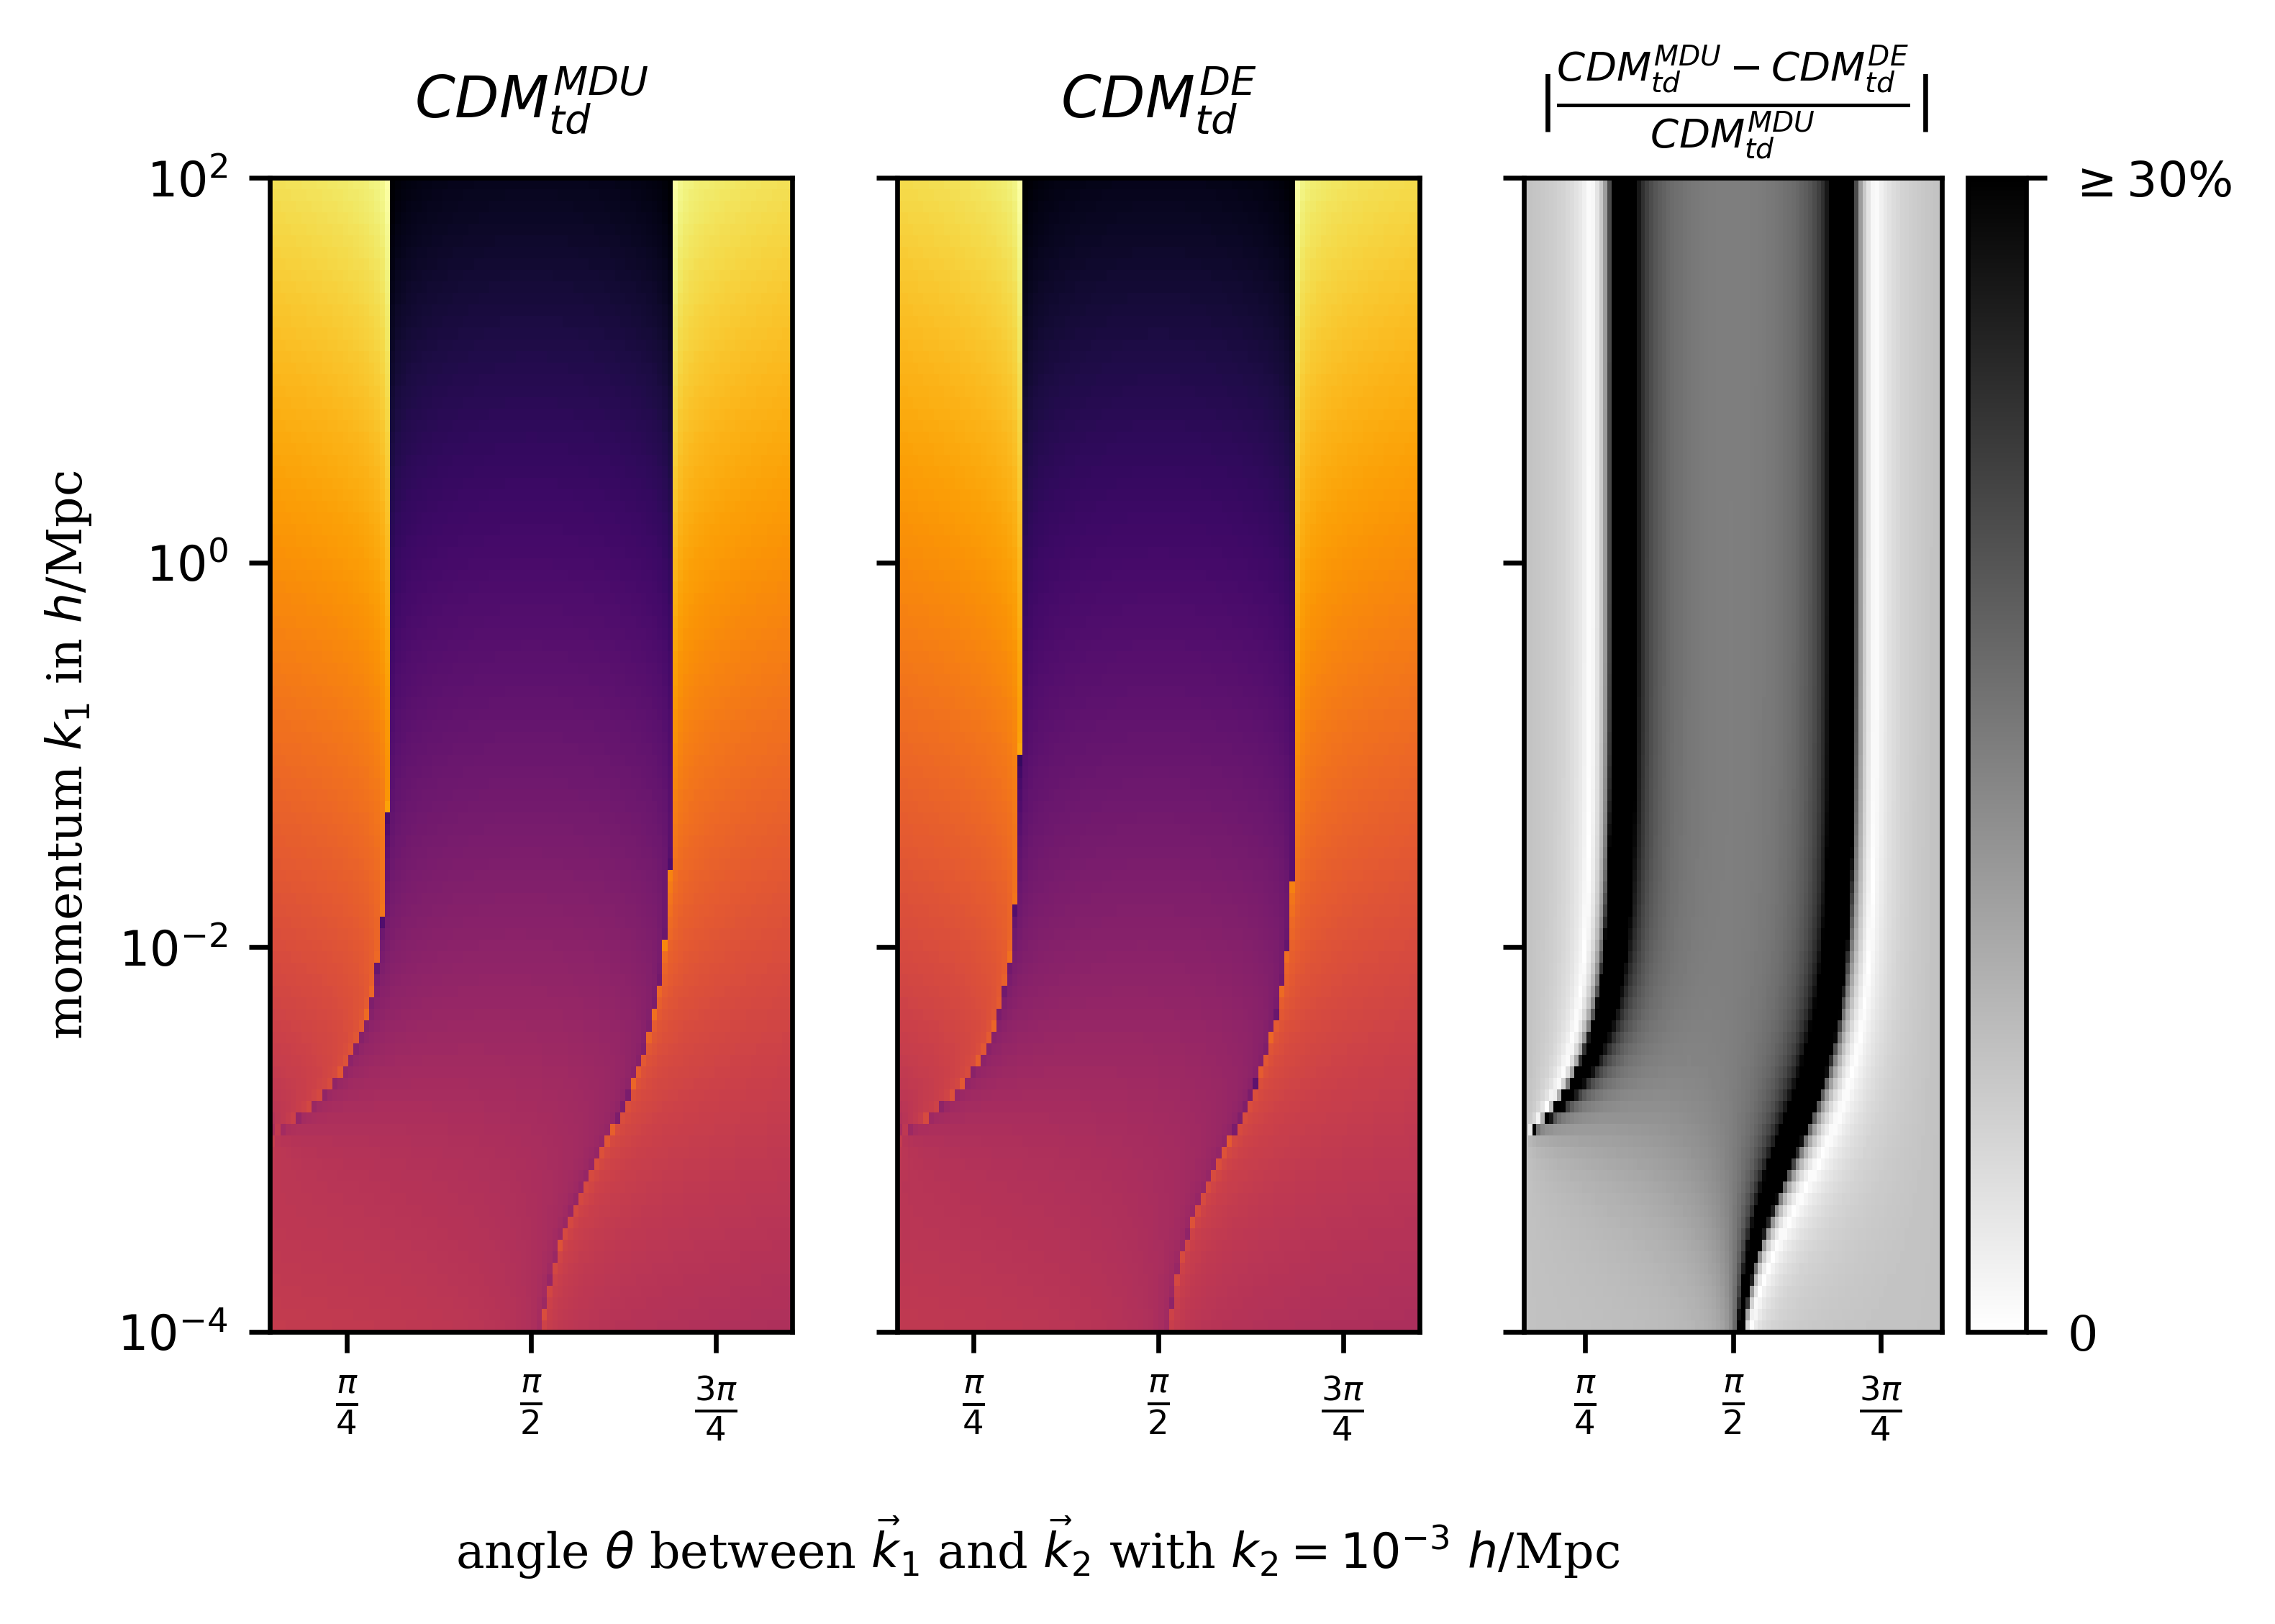

In [228]:
data_mdu = np.load("data/spectrum/f2_comparison.npz")
data_de  = np.load("data/spectrum/f2_comparison_de.npz")

f2_cdm_mdu = data_mdu["f2_cdm"]
f2_fdm_mdu = data_mdu["f2_fdm"]
f2_cdm_td_mdu  = data_mdu["f2_cdm_td"]

f2_cdm_de = data_de["f2_cdm"]
f2_fdm_de = data_de["f2_fdm"]
f2_cdm_td_de = data_de["f2_cdm_td"]

fig = plt.figure(figsize=size, dpi = dpi)
gs = fig.add_gridspec(1, 3)
ax = gs.subplots(sharey=True)

im1 = ax[0].imshow(np.sign(f2_cdm_td_mdu) * np.log10(np.abs(f2_cdm_td_mdu)),                                cmap="inferno",         extent = [1, -1, -4, 2], aspect="auto")
im2 = ax[1].imshow(np.sign(f2_cdm_td_de) * np.log10(np.abs(f2_cdm_td_de )),                                cmap="inferno",         extent = [1, -1, -4, 2], aspect="auto")
im3 = ax[2].imshow(np.abs(f2_cdm_td_mdu - f2_cdm_td_de)/(np.abs(f2_cdm_td_mdu)),   cmap="binary",          vmin=0, vmax=0.3,           extent = [1, -1, -4, 2], aspect="auto")

ax[0].set_title("$CDM_{td}^{MDU}$", pad = 10)
ax[1].set_title("$CDM_{td}^{DE}$", pad = 10)
ax[2].set_title(r"$|\frac{CDM_{td}^{MDU} - CDM_{td}^{DE}}{CDM_{td}^{MDU}}|$", pad = 10)
ax[0].set_ylabel(r"momentum $k_1$ in $h$/Mpc")
fig.text(0.46, -0.03, r"angle $\theta$ between $\vec{k}_1$ and $\vec{k}_2$ with $k_2 = 10^{-3}$ $h$/Mpc", ha='center')
for a in ax:
    a.set_yticks([-4, -2, 0, 2])
    a.set_yticklabels(["$10^{-4}$", "$10^{-2}$", "$10^{0}$", "$10^{2}$"])
    a.set_xticks([np.sqrt(2)/2, 0, -np.sqrt(2)/2])
    a.set_xticklabels([r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$"])


#fig.subplots_adjust(right=0.8)
#cbar1 = fig.add_axes([0.83, 0.15, 0.03, 0.7])
#cbar2 = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#cbar1 = fig.colorbar(im1, cax=cbar1, ticks=[-10, -5, 0])
#cbar2 = fig.colorbar(im3, cax=cbar2, ticks=[0, 0.3])
cbar2 = fig.colorbar(im3, ticks=[0, 0.3])
#cbar1.ax.set_yticklabels(["$10^{-10}$", "$10^{-5}$", "$10^{0}$"])
cbar2.ax.set_yticklabels(["0", "$\geq 30\%$"])
#plt.colorbar(ax = ax[0])
plt.savefig("../figures/f2_mdu_de_comparison.pdf", bbox_inches='tight')
plt.show()

# Spectra

### CAMB vs D

<Figure size 3186x2124 with 0 Axes>

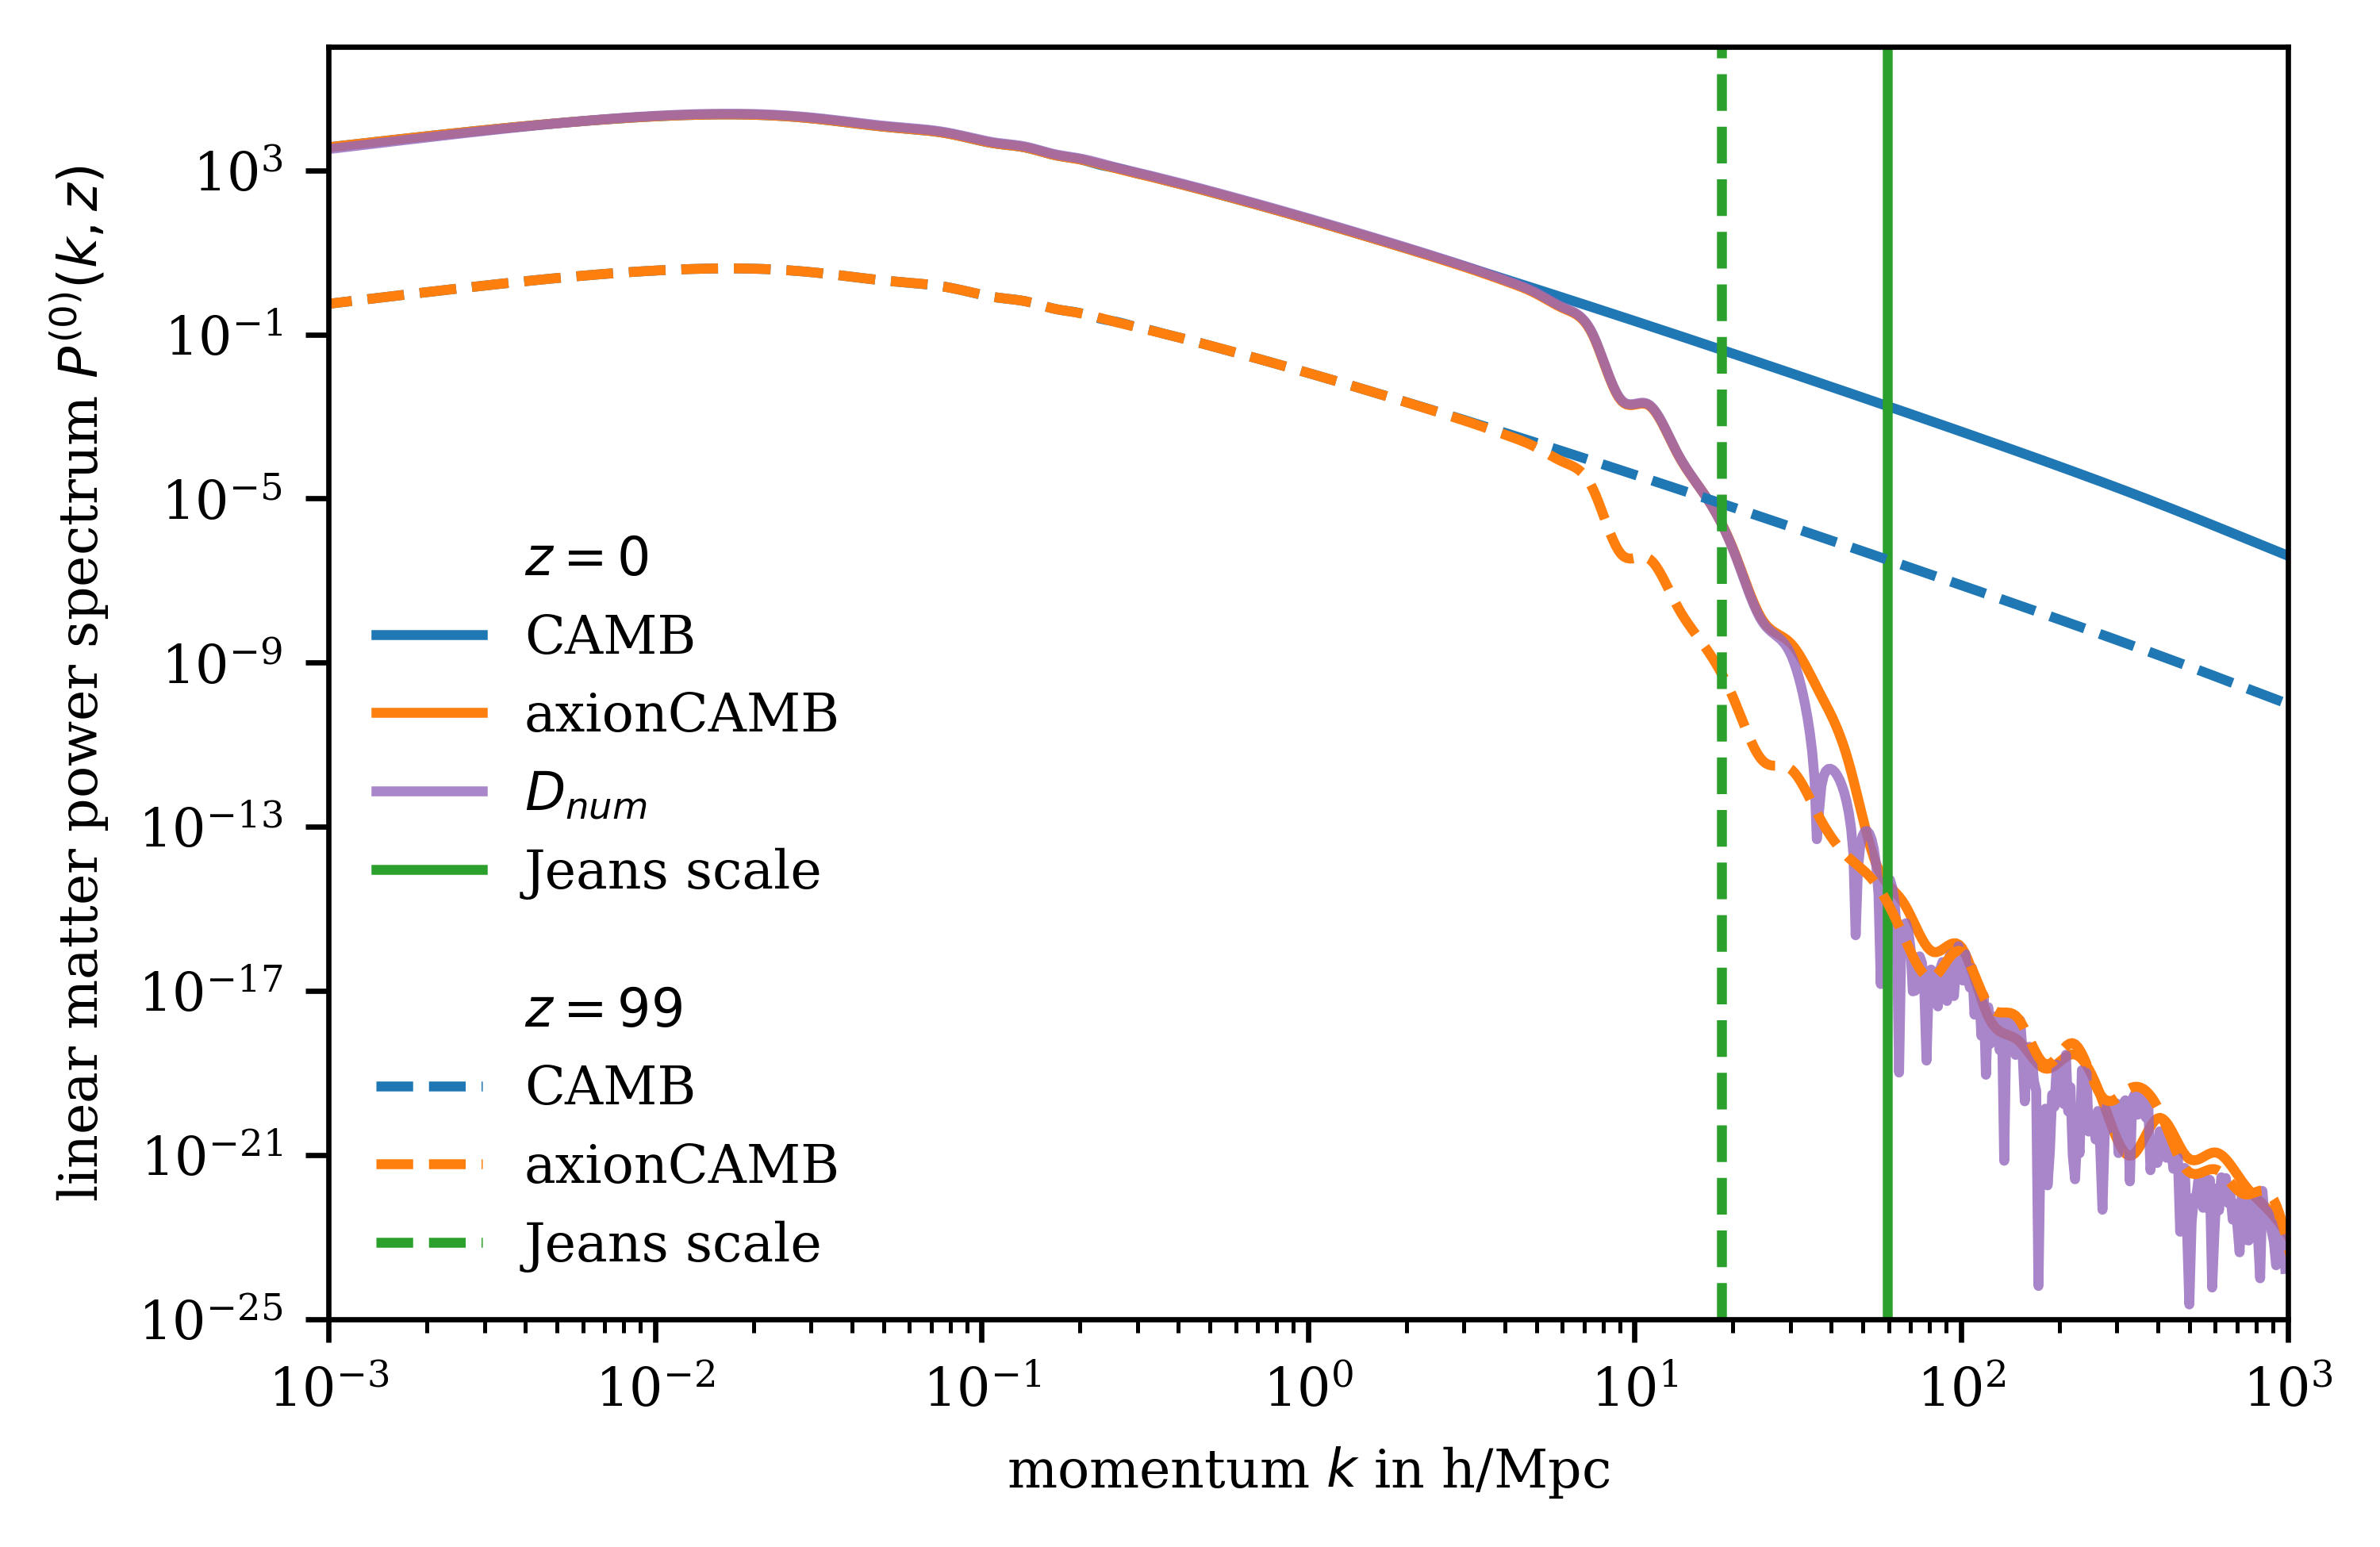

In [229]:

plt.figure(figsize=size, dpi = dpi)

files = [
    "IC/CAMB/spectra/de_z0_matterpower.dat",
    "IC/axionCAMB/spectra/de_z0_m22_matterpower.dat"
]
m = 1e-22
a = 1

labels = ["CAMB", "axionCAMB"]

plots = []

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='$z = 0$')
plots.append(p)

plt.figure(figsize=size, dpi = dpi)
for i, file in enumerate(files):
    k_vec, P_vec = np.loadtxt(file, unpack=True)
    p, = plt.loglog(k_vec, P_vec, c = colours[i],  label=labels[i])
    plots.append(p)

path = "data/spectrum/tree/"
files = ["fc_m22.dat"]
labels = [r"$D_{num}$"]

for i, file in enumerate(files):
    k, pt  = np.loadtxt(path + file, skiprows = 1, unpack = True)
    p, = plt.loglog(k, pt, c = "C4",  label=labels[i], alpha=0.8)
    plots.append(p)

p = plt.axvline(li_kj(a, m), c=colours[2], label="Jeans scale")
plots.append(p)

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\n$z = 99$')
plots.append(p)

files = [
    "IC/CAMB/spectra/de_z99_matterpower.dat",
    "IC/axionCAMB/spectra/de_z99_m22_matterpower.dat",
]
labels = ["CAMB", "axionCAMB"]

for i, file in enumerate(files):
    k_vec, P_vec = np.loadtxt(file, unpack=True)
    p, = plt.loglog(k_vec, P_vec, c = colours[i],  label=labels[i], ls = "dashed")
    plots.append(p)

p = plt.axvline(li_kj(0.01, 1e-22, 0.3), c=colours[2], ls = "dashed", label="Jeans scale")
plots.append(p)

plt.ylabel("linear matter power spectrum $P^{(0)}(k, z)$")
plt.xlabel(r"momentum $k$ in h/Mpc")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-25, 1e6)
leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/cambvsnumd_m22_de.pdf", bbox_inches='tight')
plt.show()

### Different axion masses

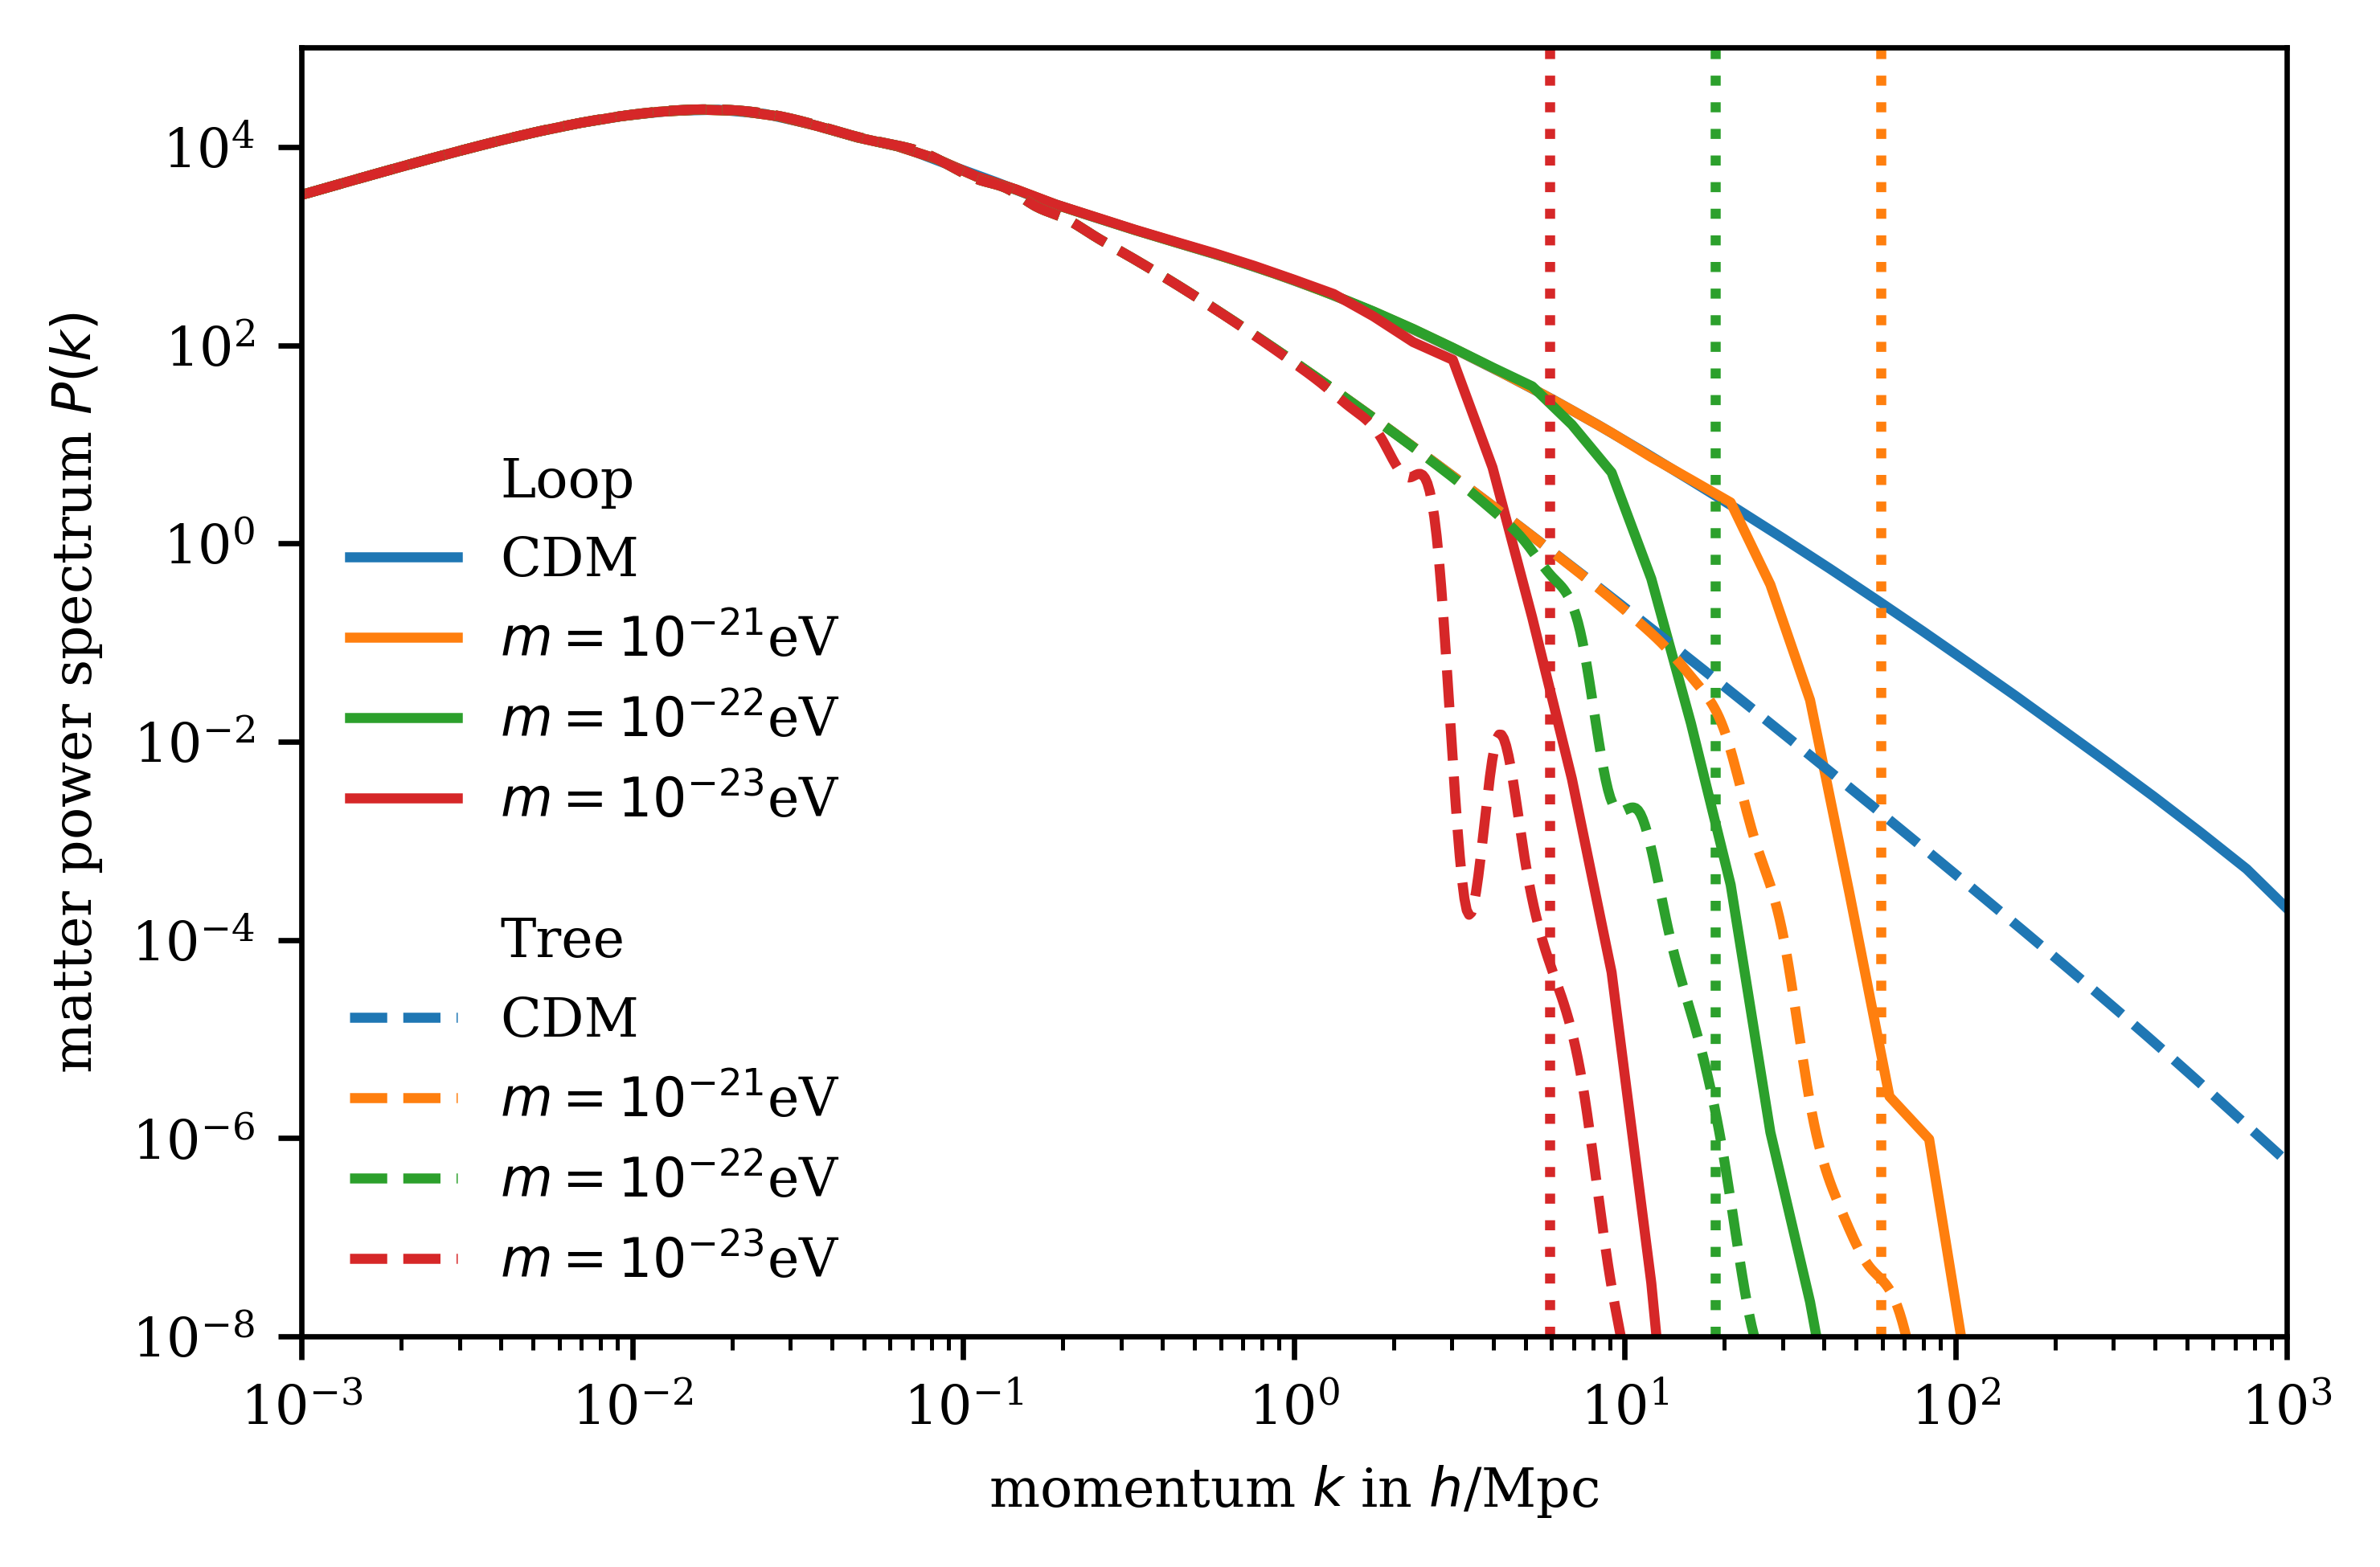

In [230]:
masses = [1e-21, 1e-22, 1e-23]
labels = ["CDM", r"$m = 10^{-21}$eV", r"$m = 10^{-22}$eV", r"$m = 10^{-23}$eV"]
a = 0.01

plt.figure(figsize=size, dpi = dpi)
plots = []


path = "data/spectrum/loop/"
files = ["fc_cdm.dat", "fc_m21.dat", "fc_m22.dat", "fc_m23.dat"]

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nLoop')
plots.append(p)


for i, file in enumerate(files):
    k,_, pt,_,_  = np.loadtxt(path +file, skiprows = 1, unpack = True)
    p,=plt.loglog(k, pt, label=labels[i])
    
    if i > 0:
        plt.axvline(li_kj(a, masses[i-1]), c=colours[i], ls = "dotted")
    plots.append(p)



path = "data/spectrum/tree/"
files = ["fc_cdm.dat", "fc_m21.dat", "fc_m22.dat", "fc_m23.dat"]


p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nTree')
plots.append(p)


for i, file in enumerate(files):
    k, pt  = np.loadtxt(path + file, skiprows = 1, unpack = True)
    p, = plt.loglog(k, pt, label=labels[i], c=colours[i], ls = "dashed")
    plots.append(p)


leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.ylabel("matter power spectrum $P(k)$")
plt.xlabel(r"momentum $k$ in $h$/Mpc")
plt.ylim([1e-8, 1e5])
plt.xlim([1e-3, 1e3])
plt.savefig("../figures/matter_spectrum.pdf", bbox_inches='tight')
plt.show()

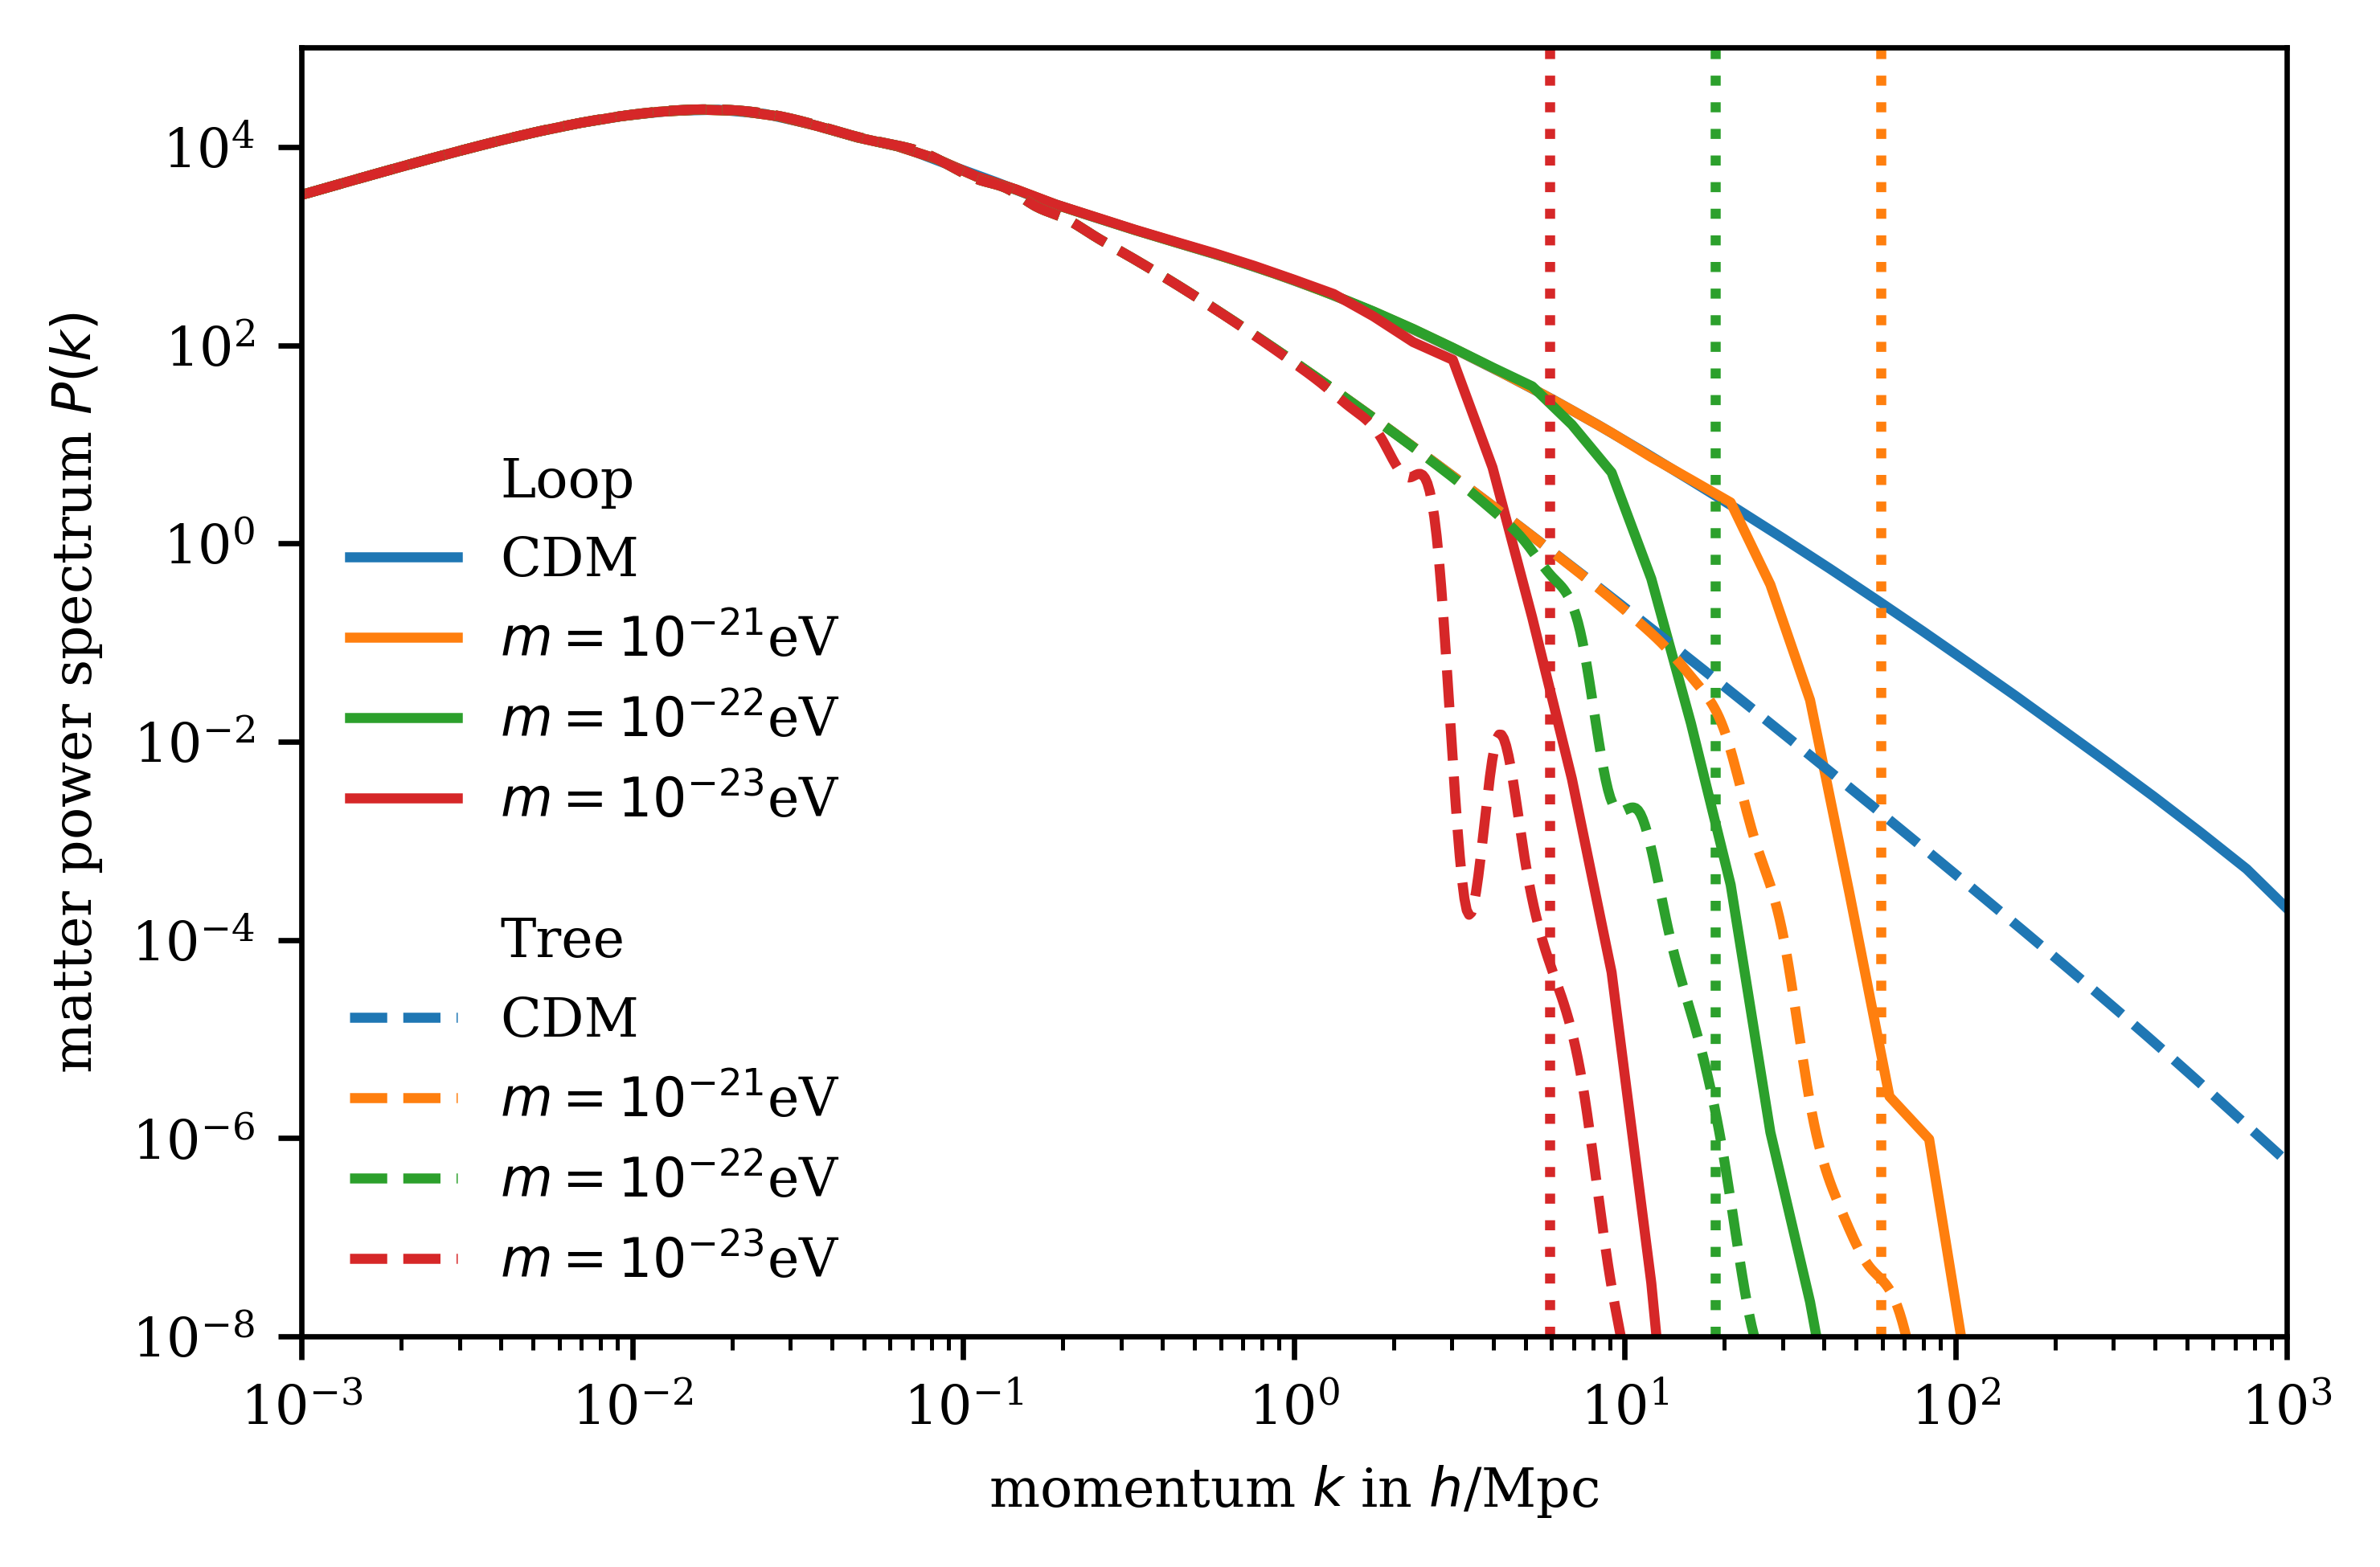

In [231]:
masses = [1e-21, 1e-22, 1e-23]
labels = ["CDM", r"$m = 10^{-21}$eV", r"$m = 10^{-22}$eV", r"$m = 10^{-23}$eV"]
a = 0.01

plt.figure(figsize=size, dpi = dpi)
plots = []


path = "data/spectrum/loop/"
files = ["fc_cdm.dat", "fc_m21.dat", "fc_m22.dat", "fc_m23.dat"]

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nLoop')
plots.append(p)


for i, file in enumerate(files):
    k,_, pt,_,_  = np.loadtxt(path +file, skiprows = 1, unpack = True)
    p,=plt.loglog(k, pt, label=standard_labels[i])
    
    if i > 0:
        plt.axvline(li_kj(a, masses[i-1]), c=colours[i], ls = "dotted")
    plots.append(p)



path = "data/spectrum/tree/"
files = ["fc_cdm.dat", "fc_m21.dat", "fc_m22.dat", "fc_m23.dat"]


p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nTree')
plots.append(p)


for i, file in enumerate(files):
    k, pt  = np.loadtxt(path + file, skiprows = 1, unpack = True)
    p, = plt.loglog(k, pt, label=standard_labels[i], c=colours[i], ls = "dashed")
    plots.append(p)


leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.ylabel("matter power spectrum $P(k)$")
plt.xlabel(r"momentum $k$ in $h$/Mpc")
plt.ylim([1e-8, 1e5])
plt.xlim([1e-3, 1e3])
plt.show()

# Nonlinear scales

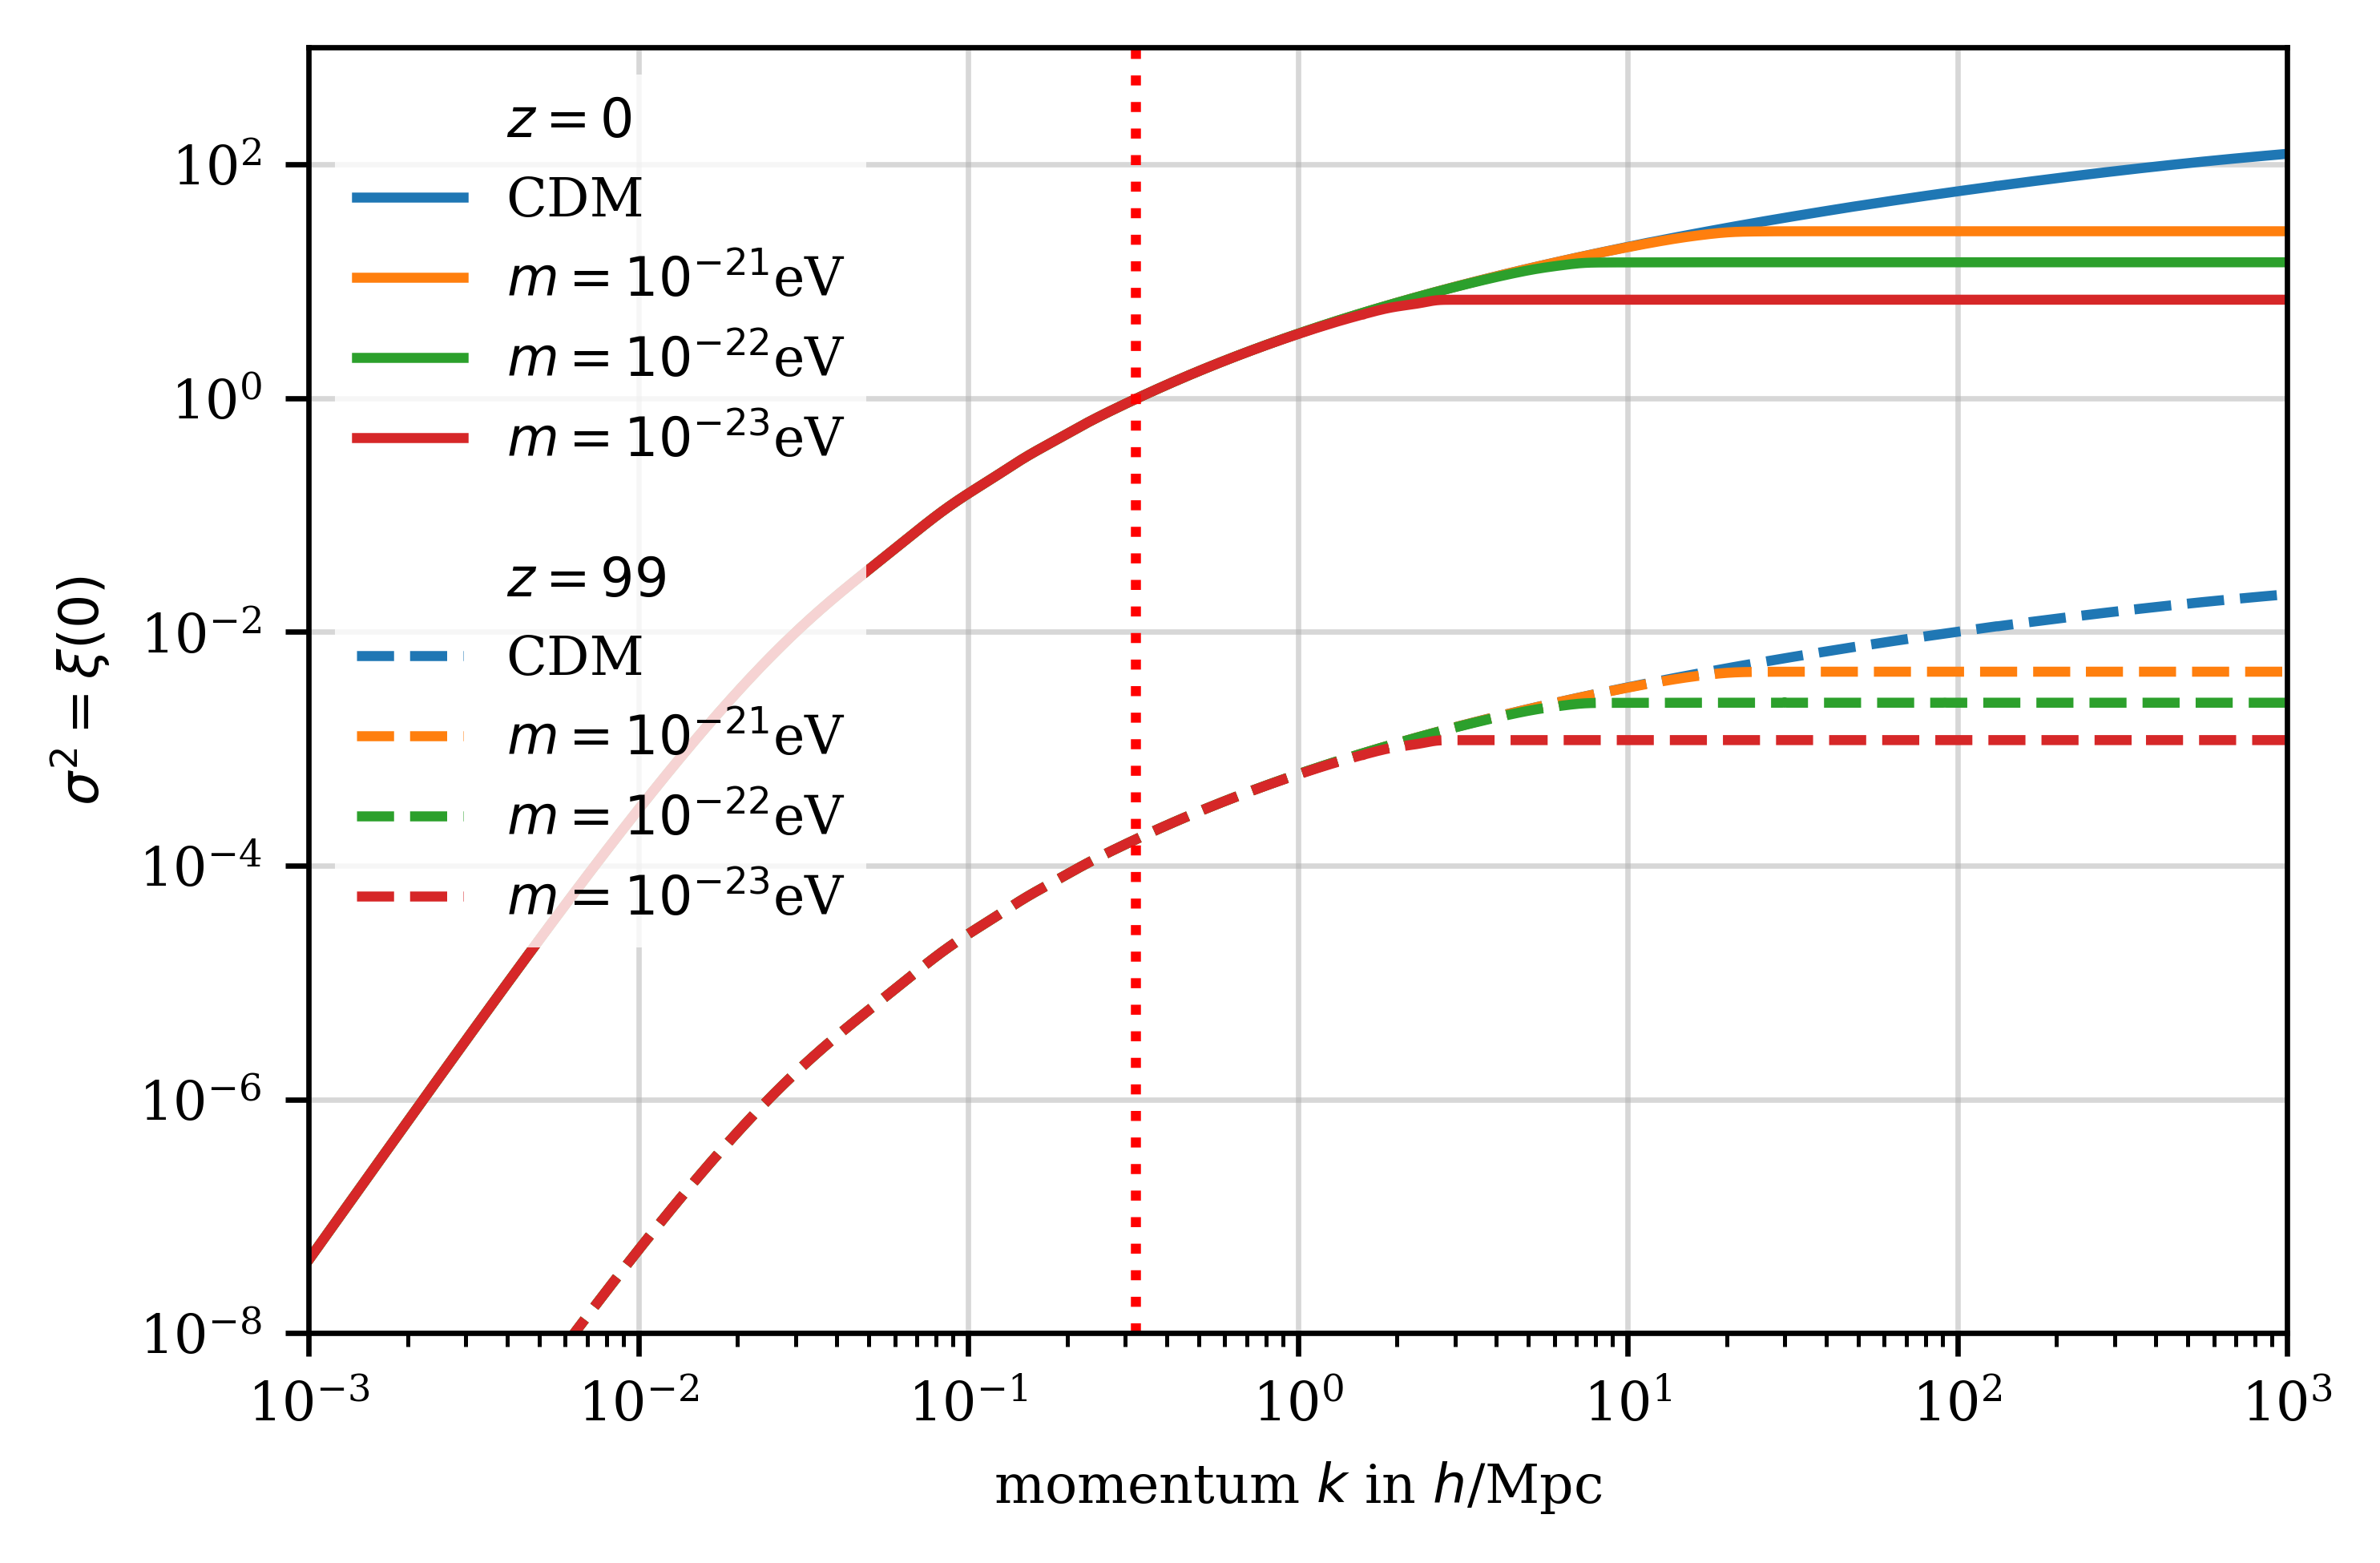

[0.322107]


In [232]:

path = "data/spectrum/nonlinear_scales/"
plt.figure(figsize=size, dpi = dpi)

plots = []

files = ["fc_cdm_z=0.dat", "fc_m21_z=0.dat", "fc_m22_z=0.dat", "fc_m23_z=0.dat"]

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='$z = 0$')
plots.append(p)

z0sigmas = []
z0ks = []
for i, file in enumerate(files):
    k, pt  = np.loadtxt(path + file, skiprows = 1, unpack = True)
    p, =plt.loglog(k, pt, label=standard_labels[i], c=colours[i])
    z0sigmas.append(pt)
    z0ks.append(k)
    plots.append(p)

files = ["fc_cdm_z=99.dat", "fc_m21_z=99.dat", "fc_m22_z=99.dat", "fc_m23_z=99.dat"]

categories = [r'CDM', r'$m = 10^{-21}$eV', r'$m = 10^{-22}$eV', r'$m = 10^{-23}$eV']
p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\n$z =  99$')
plots.append(p)
for i, file in enumerate(files):
    k, pt  = np.loadtxt(path + file, skiprows = 1, unpack = True)
    p, = plt.loglog(k, pt, label=standard_labels[i], c=colours[i], ls = "dashed")
    plots.append(p)


k, s = z0ks[0], z0sigmas[0]
idx = np.argwhere(np.diff(np.sign(s - 1))).flatten()
#plt.plot(k[idx], s[idx], 'ro')





plt.axvline(k[idx], label="nonlinear scale", c = "red", ls="dotted")
plt.grid(visible=True, alpha=0.5)
#leg3 = plt.legend([p1, *z99plots, p1, *z0plots],
#              [r'$z=99$'] + categories + [r'$z=0$'] + categories,
#              loc=2, ncol=2) # Two columns, vertical group labels
leg = plt.legend(handles=plots, loc="upper left")
leg.get_frame().set_linewidth(0.0)
plt.ylabel(r"$\sigma^2 = \xi(0)$")
plt.xlabel(r"momentum $k$ in $h$/Mpc")
plt.ylim([1e-8, 1e3])
plt.xlim([1e-3, 1e3])

plt.savefig("../figures/nonlinear_scales.pdf", bbox_inches='tight')
plt.show()

print(k[idx], )

# Lensing spectra

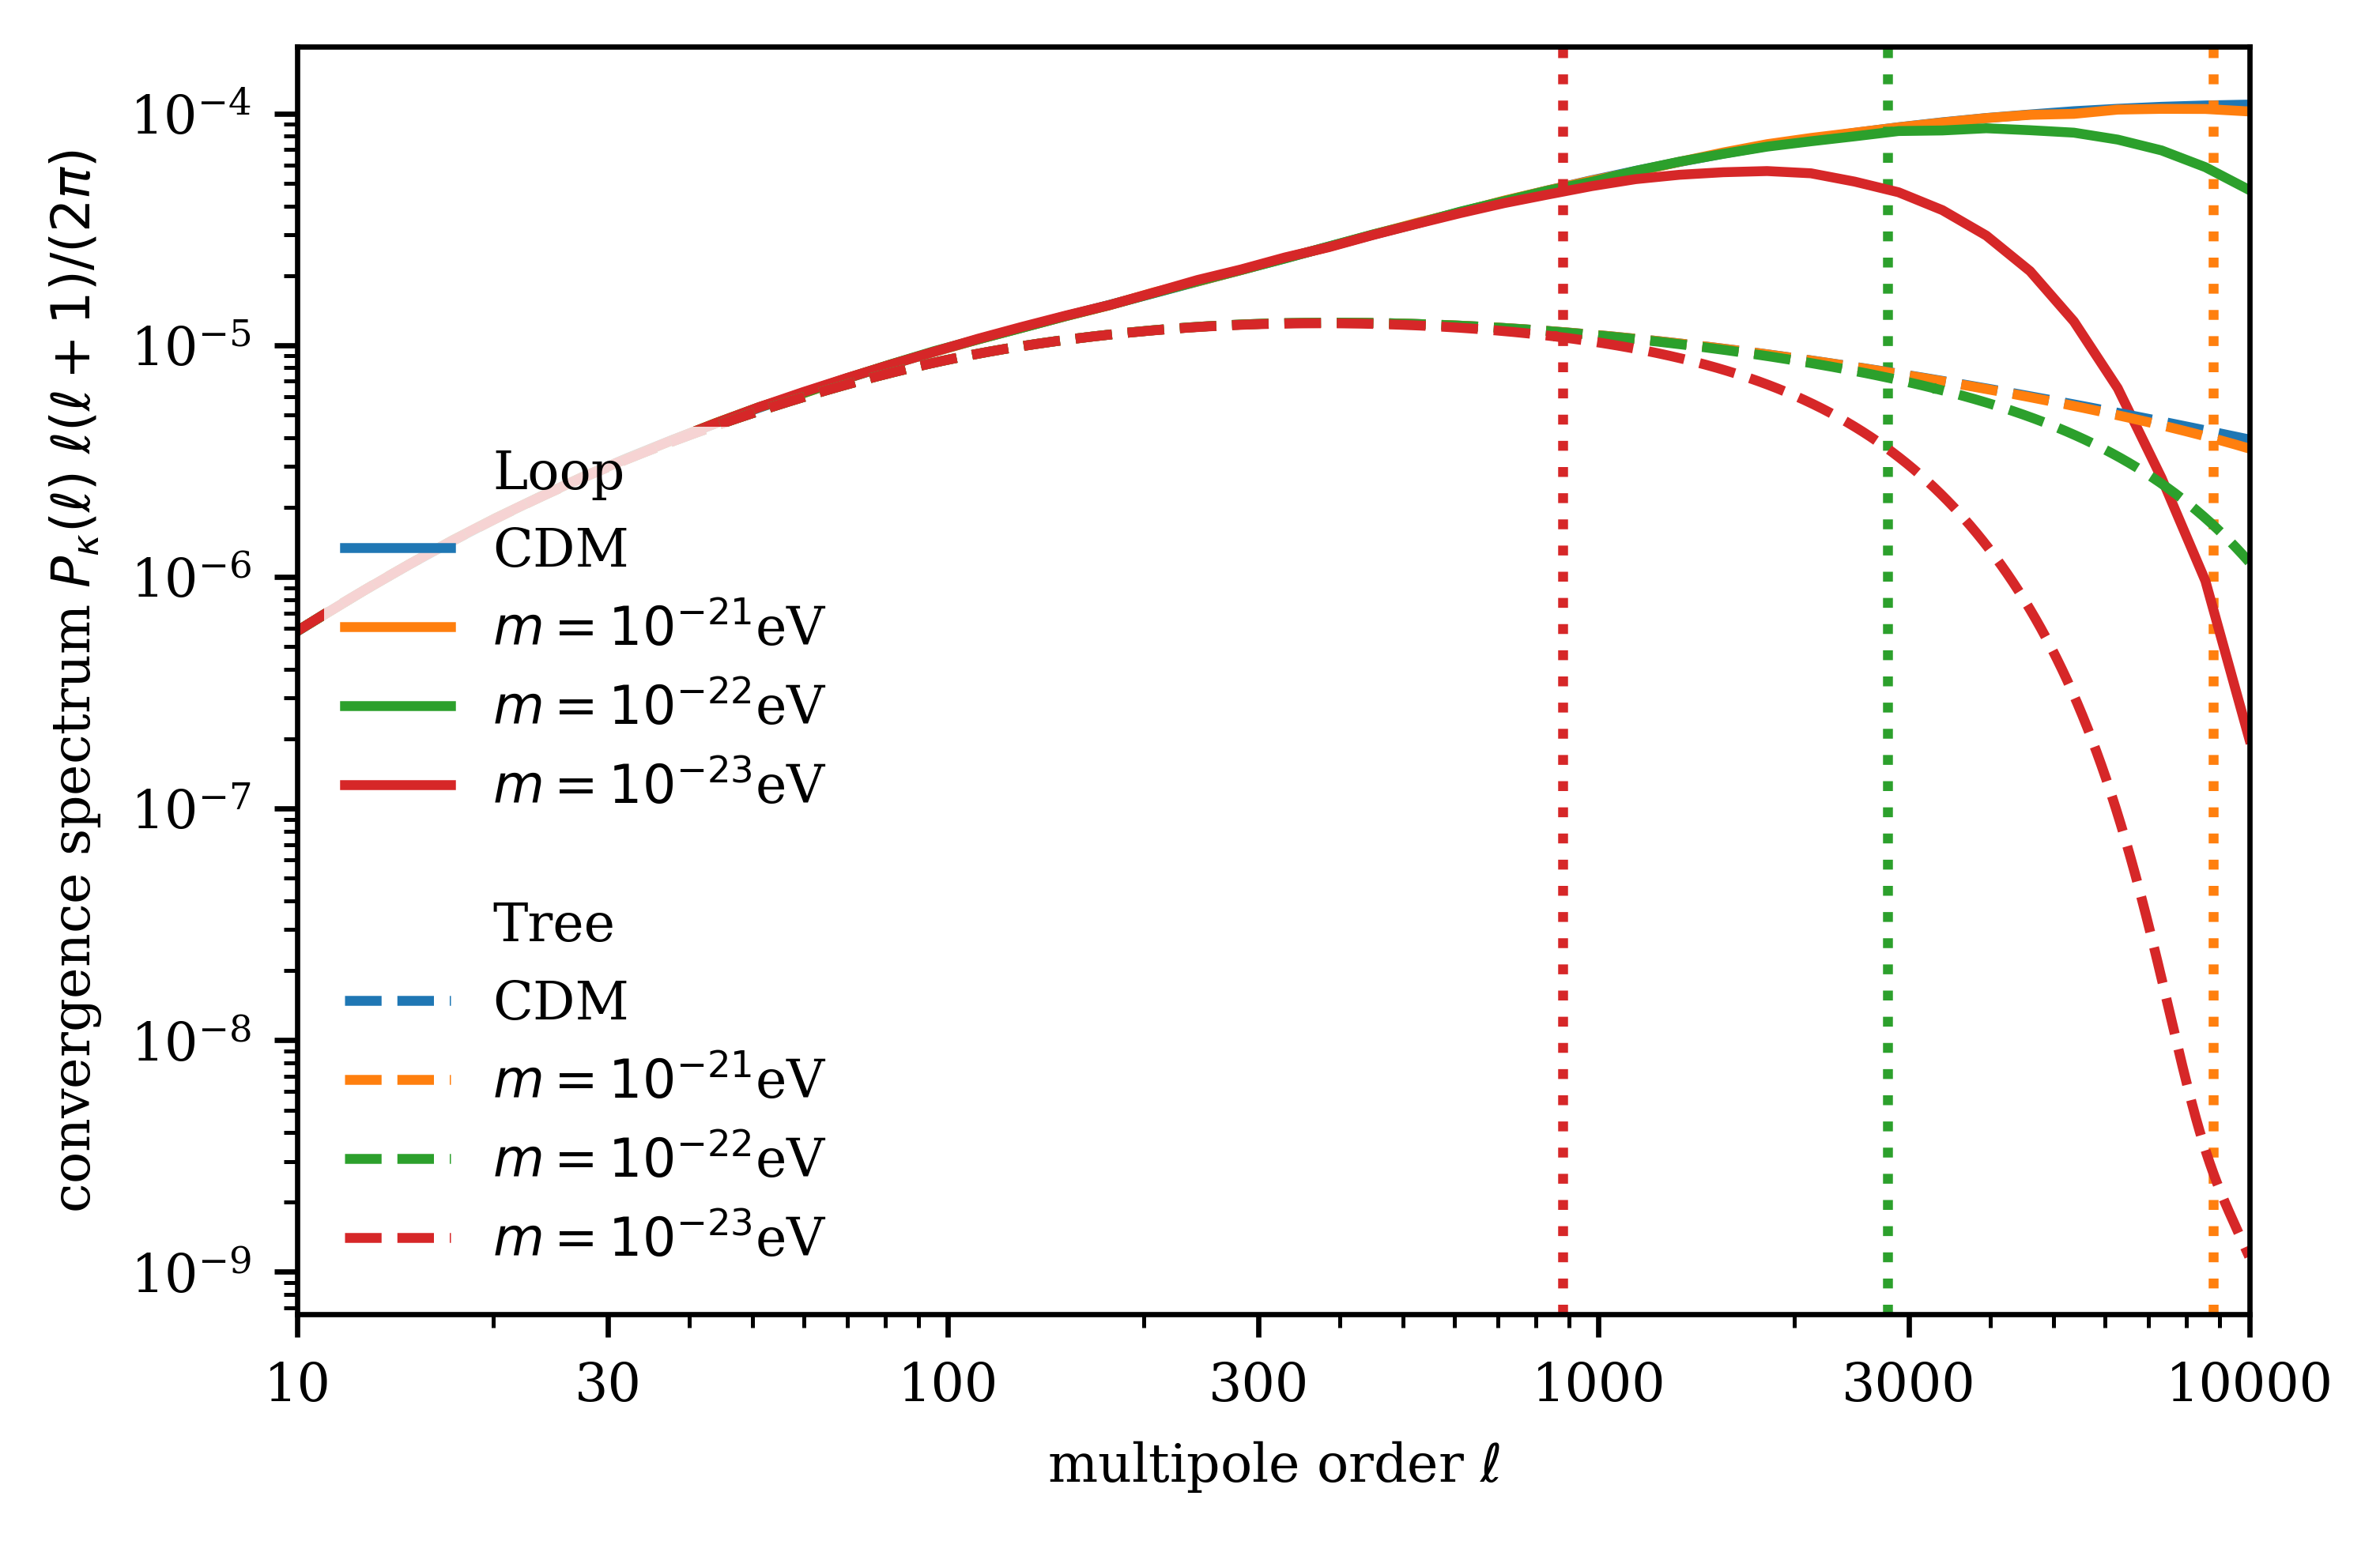

In [274]:
path = "data/lensing_spectrum/"

plt.figure(figsize=size, dpi = dpi)


plots = []
p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Loop')
plots.append(p)

path = "data/lensing_spectrum/loop/"
for i, file in enumerate(standard_files):
    l, Pk = np.loadtxt(path + file, unpack = True, skiprows=1)
    p, = plt.loglog(l, Pk * l * (l + 1) / (2*np.pi), label=standard_labels[i], c = colours[i], ls = "solid")
    plots.append(p)
    if i > 0:
        plt.axvline(lj(masses[i-1]), c=colours[i], ls = "dotted")


p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nTree')
plots.append(p)

path = "data/lensing_spectrum/"
files = ["kappa_1_fc_cdm.dat", "kappa_1_fc_m21.dat", "kappa_1_fc_m22.dat", "kappa_1_fc_m23.dat"]
for i, file in enumerate(files):
    l, Pk = np.loadtxt(path + file, unpack = True)
    p, = plt.loglog(l, Pk * l * (l + 1) / (2*np.pi), label=standard_labels[i], c = colours[i], ls="dashed")
    plots.append(p)



plt.xlim(10, 10000)
aux = [10, 30,100,300,1000,3000,10000]
plt.xticks(aux,aux)
leg = plt.legend(handles = plots, loc = "lower left")
leg.get_frame().set_linewidth(0.0)
plt.ylabel(r"convergence spectrum $P_{\kappa}(\ell)$ $\ell(\ell+1)/(2\pi)$")
plt.xlabel(r"multipole order $\ell$")
plt.savefig("../figures/convergence_spectrum.pdf", bbox_inches='tight')
plt.show()

# Compute 1 Loop animations

In [ ]:
path = "data/spectrum/tree/animations/"
masses = ["23", "22", "21"]
tree_cdm_folder = "tree_cdm"
loop_cdm_folder = "loop_cdm"

m = "21"
m = "$m = 10^{-"+m+"}$eV"
tree_fdm_folder = "tree_fdm_m"+m
loop_fdm_folder = "loop_fdm_m"+m
file_list = getFilesInDirectory(path+loop_fdm_folder)
redshifts = []
for i, file in enumerate(file_list):
    z = float(file.split(".dat")[0])
    redshifts.append(z)

sorted_redshifts, sorted_file_list = (list(t) for t in zip(*sorted(zip(redshifts , file_list))))
sorted_redshifts.reverse()
sorted_file_list.reverse()
print(sorted_file_list)

for i, file in enumerate(sorted_file_list):
    plt.figure(figsize=(8, 6), dpi = 60)
    plt.title("Power spectra with nonlinear corrections at z = " + "%05.2f"%sorted_redshifts[i])
    plt.ylim(1e-15, 1e5)
    plt.xlim(1e-4, 1e3)

    k, pt = np.loadtxt(path + loop_cdm_folder + "/" + file, skiprows = 1, unpack = True)
    plt.loglog(k, pt, label="Nonlinear CDM")

    k, pt = np.loadtxt(path + tree_cdm_folder + "/" + file, skiprows = 1, unpack = True)
    plt.loglog(k, pt, label="Linear CDM")

    for m in  masses:

        m = "$m = 10^{-"+m+"}$eV"
        tree_fdm_folder = "tree_fdm_m"+m
        loop_fdm_folder = "loop_fdm_m"+m

        k, pt = np.loadtxt(path + tree_fdm_folder + "/" + file, skiprows = 1, unpack = True)
        plt.loglog(k, pt, label="Tree " + m)

        k, pt = np.loadtxt(path + loop_fdm_folder + "/" + file, skiprows = 1, unpack = True)
        plt.loglog(k, pt, label="Loop " + m)
        
    plt.legend(loc="lower left")
    plt.ylabel("matter power spectrum P(k)")
    plt.xlabel(r"momentum $k$ in $h$/Mpc")
    plt.savefig(path + "/combined/" + str(i).zfill(3) + ".jpg", bbox_inches='tight')
    plt.close()

# Tree-level bispectra

In [ ]:


configs = ["r1=20_r2=10"]
titles = [r"for $k_1$ = $0.2$ $h$/Mpc and $k_2$ = $0.1$ $h$/Mpc", r"for $k_1$ = $20$ $h$/Mpc and $k_2$ = $10$ $h$/Mpc"]


fig, ax = plt.subplots(figsize=size, dpi=dpi)

xticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
xlabels = ["$0$", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$"]


plots = []

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Tree')
plots.append(p)
for i, config in enumerate(configs):
    path = "data/bispectrum/angular/tree/"
    files = ['fc_cdm_'+config+'.dat', 'fc_m21_'+config+'.dat', 'fc_m22_'+config+'.dat', 'fc_m23_'+config+'.dat']
    labels = ["CDM", "$m = 10^{-21}$eV", "$m = 10^{-22}$eV", "$m = 10^{-23}$eV"]
    for j, file in enumerate(files):
        theta, bt, btr = np.loadtxt(path + file, skiprows = 1, unpack = True)
        p, = ax.plot(theta, btr, label=labels[j], c = colours[j])
        plots.append(p)

    #path = "data/bispectrum/angular/loop/"
    #files = ['cdm_'+config+'.dat', 'fdm_m21_'+config+'.dat', 'fdm_m22_'+config+'.dat', 'fdm_m23_'+config+'.dat']
    #labels = ["Loop CDM", "Loop $m = 10^{-21}$eV", "Loop $m = 10^{-22}$eV", "Loop $m = 10^{-23}$eV"]#, "Loop $m = 10^{-21}$eV", , "Loop $m = 10^{-23}$eV"]
#
    #for j, file in enumerate(files):
    #    theta, btr, bnlr, sdev = np.loadtxt(path + file, skiprows = 1, unpack = True)
    #    plt.plot(theta, btr + bnlr, label=labels[j], c = colours[j])
##
    #    plt.fill_between(theta, btr + bnlr + sdev, btr + bnlr - sdev, color = colours[j], alpha = 0.5)

    ax.set_xticks(xticks, xlabels)

leg = ax.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
ax.set_ylabel("reduced matter bispectrum $Q_{\delta}(k_1, k_2, k_3)$ ")
ax.set_xlabel(r"angle $\theta$")
plt.subplots_adjust(wspace=0)
plt.savefig(f"../figures/angular_matter_bispectrum.pdf", bbox_inches='tight')
plt.show()

## Equilateral reduced bispetrum

In [ ]:
plt.figure(figsize=size, dpi = dpi)
plt.title(r"Equilateral reduced bispectra")

path = "data/bispectrum/equilateral/tree/"
files = ['cdm.dat', 'fdm_m21.dat', 'fdm_m22.dat', 'fdm_m23.dat']
labels = ["Tree CDM", "Tree $m = 10^{-21}$eV", "Tree $m = 10^{-22}$eV", "Tree $m = 10^{-23}$eV"]
for file, label in zip(files, labels):
    theta, p, b, bdimless, bred, brederr, q = np.loadtxt(path + file, skiprows = 1, unpack = True)
    plt.plot(theta, bred, label=label)

path = "data/bispectrum/equilateral/loop/reduced/"
files = ['cdm_loop.dat']
labels = ["CDM"]
plt.xscale("log")
for file, label in zip(files, labels):
    theta, btr, bnlr, sdev = np.loadtxt(path + file, skiprows = 1, unpack = True)
    print(theta)
    #plt.plot(theta, btr,        label="Tree " + label)
    plt.plot(theta, btr + bnlr, label="Loop " + label)

    plt.fill_between(theta, btr + bnlr + sdev, btr + bnlr - sdev, alpha = 0.5)

leg = plt.legend(loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.ylabel("$Q(k, k, k)$")
plt.xlabel(r"Momentum $k$ in $h/Mpc$")
plt.show()

## Equilateral dimensionless bispectrum

In [ ]:


plt.figure(figsize=size, dpi = dpi)
plt.ylabel(r"matter bispectrum $B_{\delta}(k, k, k)$")
plt.xlabel(r"momentum $k$ in $h$/Mpc")

a = 0.01

plots = []
p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Loop')
plots.append(p)

path = "data/bispectrum/equilateral/loop/"
for i, file in enumerate(standard_files):
    k, P, B, BR, R, E, Q = np.loadtxt(path + file, unpack = True, skiprows=1)
    p,=plt.loglog(k, B, label=standard_labels[i], c=colours[i])
    if i > 0:
        plt.axvline(li_kj(a, masses[i-1]), c=colours[i], ls = "dotted")
    plots.append(p)

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nTree')
plots.append(p)

path = "data/bispectrum/equilateral/tree/"
for i, file in enumerate(standard_files):
    k, P, B, BR, R, E, Q = np.loadtxt(path + file, unpack = True, skiprows=1)
    p,=plt.loglog(k, B, label=standard_labels[i], c=colours[i], ls = "dashed")
    plots.append(p)

#path = "data/bispectrum/equilateral/loop/"
#
#files = ['cdm_loop.dat', 'fdm_loop_m21.dat', 'fdm_loop_m22.dat', 'fdm_loop_m23.dat']
#labels = ["Loop CDM", "Loop $m = 10^{-21}$eV", "Loop $m = 10^{-22}$eV", "Loop $m = 10^{-23}$eV"]
#
#for i, file in enumerate(files):
#    k, P, B, BR, R, E, Q = np.loadtxt(path + file, unpack = True, skiprows=1)
#    plt.loglog(k, B, label=labels[i], c=colours[i])

plt.xlim(1e-3, 1000)
plt.ylim(1e-17, 1e10)
leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/equilateral_matter_bispectrum.pdf", bbox_inches='tight')
plt.show()

# Lensing bispectrum

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import mpl_toolkits.mplot3d as a3
import pandas
import numpy as np

def disable_ticks(ax):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)

def disable_xyticks(ax):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    for line in ax.xaxis.get_ticklines():
        line.set_visible(False)
    for line in ax.yaxis.get_ticklines():
        line.set_visible(False)

def disable_zticks(ax):
    ax.zaxis.set_ticklabels([])

    for line in ax.zaxis.get_ticklines():
        line.set_visible(False)

def plot_bispectrum_s2n(filename, title, subtitles, runs, subsubtitles, lcs = 1e9, lcc = 1e9, rcs = 1e5, rcc = 1e4):
    low = 1
    high = 4

    vtx1 = np.array([[high, high, low], [low,  high, high], [low, low,  low]])
    vtx2 = np.array([[high, high, low], [high, low , high],  [low, low,  low]])
    vtx3 = np.array([[high,  low, high], [low, high, high], [low, low,  low]])


    aux1 = np.log10(np.array([10, 100,1000,10000]))
    aux2 = np.array([10,100,1000,10000])

    cmap = cm.inferno

    fig, axes   = plt.subplots(3, 2, subplot_kw={"projection": "3d"})
    fig.set_size_inches(size[0], 1.5*size[0])
    fig.set_dpi(dpi)
    for i, x in enumerate(zip(subtitles, runs)):
        title, data = x
        ax = axes[i][0]
        #ax.set_title(subsubtitles[i][0])
        surf      = ax.scatter(np.log10(data["l1"]),np.log10(data["l2"]), np.log10(data["l3"]), s=data["BKS"]*lcs, c=data["BKS"] * lcc, cmap=cmap)
        tri       = a3.art3d.Poly3DCollection([vtx1])
        tri.set_color("white")
        tri.set_edgecolor('gray')
        ax.add_collection3d(tri)
        if i == 2:
            ax.set_xlabel("$\ell_1$")
            ax.set_ylabel("$\ell_2$")
        ax.set_zlabel("$\ell_3$")
        ax.set_xticks(aux1)
        ax.set_xticklabels(aux2)
        ax.set_yticks(aux1)
        ax.set_yticklabels(aux2)
        ax.set_zticks([])
        #ax.set_zticklabels(aux2)

        ax = axes[i][1]
        #ax.set_title(subsubtitles[i][1])
        surf      = ax.scatter(np.log10(data["l1"]), np.log10(data["l2"]), np.log10(data["l3"]), s=data["S2N"]*rcs, c=data["S2N"]*rcc, cmap=cmap)
        tri       = a3.art3d.Poly3DCollection([vtx1])
        tri.set_color("white")
        tri.set_edgecolor('gray')
        ax.add_collection3d(tri)
        if i == 2:
            ax.set_xlabel("$\ell_1$")
            ax.set_ylabel("$\ell_2$")
        ax.set_zlabel("$\ell_3$")
        ax.set_xticks(aux1)
        ax.set_xticklabels(aux2)
        ax.set_yticks(aux1)
        ax.set_yticklabels(aux2)
        ax.set_zticks(aux1)
        ax.set_zticklabels(aux2)
        #disable_ticks(ax)
    plt.subplots_adjust(hspace=0.1)
    plt.subplots_adjust(wspace=0.1)
    #plt.figtext(0.52, 0.91, subtitles[0], ha='center', va='center', fontsize="large")
    #plt.figtext(0.52, 0.64, subtitles[1], ha='center', va='center', fontsize="large")
    #plt.figtext(0.52, 0.36, subtitles[2], ha='center', va='center', fontsize="large")
    plt.savefig("../figures/convergence_bispectrum_3d_"+filename+".pdf", bbox_inches='tight')
    plt.show()


In [ ]:
path = "data/lensing_bispectrum/3d/tree/"
masses = ["21", "22", "23"]
for m in masses:
    mass_string = "$m = 10^{-"+m+"}$eV"

    title = "Comparison of CDM and FDM ("+m+") convergence bispectra S2N-ratios"
    subtitles = standard_labels
    subsubtitles = [
        [r"$(\ell_1 \ell_2 \ell_3)^{4/3} B^{CDM}_{\kappa}(\ell_1, \ell_2, \ell_3)$", r"$B^{CDM}_{\kappa}(\ell_1, \ell_2, \ell_3) / \sqrt{cov^{CDM}(\ell_1, \ell_2, \ell_3)}$"],
        [r"$(\ell_1 \ell_2 \ell_3)^{4/3} B^{FDM}_{\kappa}(\ell_1, \ell_2, \ell_3)$", r"$B^{FDM}_{\kappa}(\ell_1, \ell_2, \ell_3) / \sqrt{cov^{FDM}(\ell_1, \ell_2, \ell_3)}$"],
        [r"$(\ell_1 \ell_2 \ell_3)^{4/3} |B^{CDM}_{\kappa}(\ell_1, \ell_2, \ell_3) - B^{FDM}_{\kappa}(\ell_1, \ell_2, \ell_3)|$", r"$|B^{CDM}_{\kappa}(\ell_1, \ell_2, \ell_3) - B^{FDM}_{\kappa}(\ell_1, \ell_2, \ell_3)| / \sqrt{cov^{CDM}(\ell_1, \ell_2, \ell_3)}$"]
    ]

    files = ["fc_cdm.dat", f"fc_m{m}.dat"]
    runs = []
    for file, label in zip(files, subtitles):
        data = pandas.read_csv(path + file, delim_whitespace=True, skiprows=[0])
        data.columns = ["l1", "l2", "l3", "B_k", "BKS", "Cov", "S2N"]
        (data["S2N"])[data["S2N"] == -1] = 0
        runs.append(data)

    subtitles.append("|CDM - $m = 10^{-22} eV$|")
    cdm =  runs[0].copy()
    fdm =  runs[1].copy()
    diff = runs[0].copy()
    diff["B_k"] = np.abs(cdm["B_k"] - fdm["B_k"])
    diff["BKS"] = np.abs(cdm["BKS"] - fdm["BKS"])
    diff["S2N"] = diff["B_k"] / np.sqrt(diff["Cov"])
    

    runs.append(diff)
    
    plot_bispectrum_s2n("fc_m"+m, title, subtitles, runs, subsubtitles, lcs = 5e7, lcc = 5e7)

In [ ]:
path = "data/lensing_bispectrum/"

masses = ["22"]
for m in masses:
    m = "$m = 10^{-"+m+"}$eV"

    title = "Comparison of CDM and FDM ("+m+") convergence bispectra S2N-ratios"
    files = ["cdm_loop.dat", "fdm_m"+m+"_loop.dat"]
    subtitles = ["Loop CDM", "Loop $m = 10^{"+m+"} eV$"]
    subsubtitles = [
        [r"$(l_1 l_2 l_3)^{4/3} B^{CDM}_{\kappa}(l_1, l_2, l_3)$", r"$B^{CDM}_{\kappa}(l_1, l_2, l_3) / \sqrt{cov^{CDM}(l_1, l_2, l_3)}$"],
        [r"$(l_1 l_2 l_3)^{4/3} B^{FDM}_{\kappa}(l_1, l_2, l_3)$", r"$B^{FDM}_{\kappa}(l_1, l_2, l_3) / \sqrt{cov^{FDM}(l_1, l_2, l_3)}$"],
        [r"$(l_1 l_2 l_3)^{4/3} |B^{CDM}_{\kappa}(l_1, l_2, l_3) - B^{FDM}_{\kappa}(l_1, l_2, l_3)|$", r"$|B^{CDM}_{\kappa}(l_1, l_2, l_3) - B^{FDM}_{\kappa}(l_1, l_2, l_3)| / \sqrt{cov^{CDM}(l_1, l_2, l_3)}$"]
    ]

    runs = []
    for file, label in zip(files, subtitles):
        data = pandas.read_csv(path + file, delim_whitespace=True, skiprows=[0])
        data.columns = ["l1", "l2", "l3", "B_k", "BKS", "Cov", "S2N"]
        (data["S2N"])[data["S2N"] == -1] = 0
        data["S2N"] = np.abs(data["S2N"])
        data["B_k"] = np.abs(data["B_k"])
        data["BKS"] = np.abs(data["BKS"])
        runs.append(data)

    subtitles.append("Loop |CDM - $m = 10^{-"+m+"} eV$|")
    cdm =  runs[0].copy()
    fdm =  runs[1].copy()
    diff = runs[0].copy()
    diff["B_k"] = np.abs(cdm["B_k"] - fdm["B_k"])
    diff["BKS"] = np.abs(cdm["BKS"] - fdm["BKS"])
    diff["S2N"] = diff["B_k"] / np.sqrt(diff["Cov"])
    

    runs.append(diff)
    
    plot_bispectrum_s2n("loop_fdm_m"+m, title, subtitles, runs, subsubtitles, lcs = 5e7, lcc = 5e7)

In [ ]:
path = "data/lensing_bispectrum/"

masses = ["22"]

plt.figure(figsize=(12,8), dpi = 160)
for m in masses:
    m = "$m = 10^{-"+m+"}$eV"

    files = ["cdm.dat", "fdm_m"+m+".dat","cdm_loop.dat", "fdm_m"+m+"_loop.dat" ]
    labels = ["CDM", m,"Loop CDM", "Loop "+m]

    for i, file in enumerate(files):
        data = pandas.read_csv(path + file, delim_whitespace=True, skiprows=[0])
        data.columns = ["l1", "l2", "l3", "B_k", "BKS", "Cov", "S2N"]
        c1 = data["l1"] == data["l2"]
        c2 = data["l2"] == data["l3"]
        c3 = data["l1"] == data["l3"]

        equilateral = data[c1 & c2 & c3]

        plt.loglog(equilateral["l1"], equilateral["B_k"] * equilateral["l1"]**4/(2*np.pi)**2, label = labels[i])

aux = [10, 30,100,300,1000,3000,10000]
plt.xticks(aux,aux)
plt.xlim(10, 10000)
plt.xlim(50, 10000)
plt.ylim(1e-11, 1e-7)
plt.legend()

## Dimensionless equilateral lensing bispectrum 

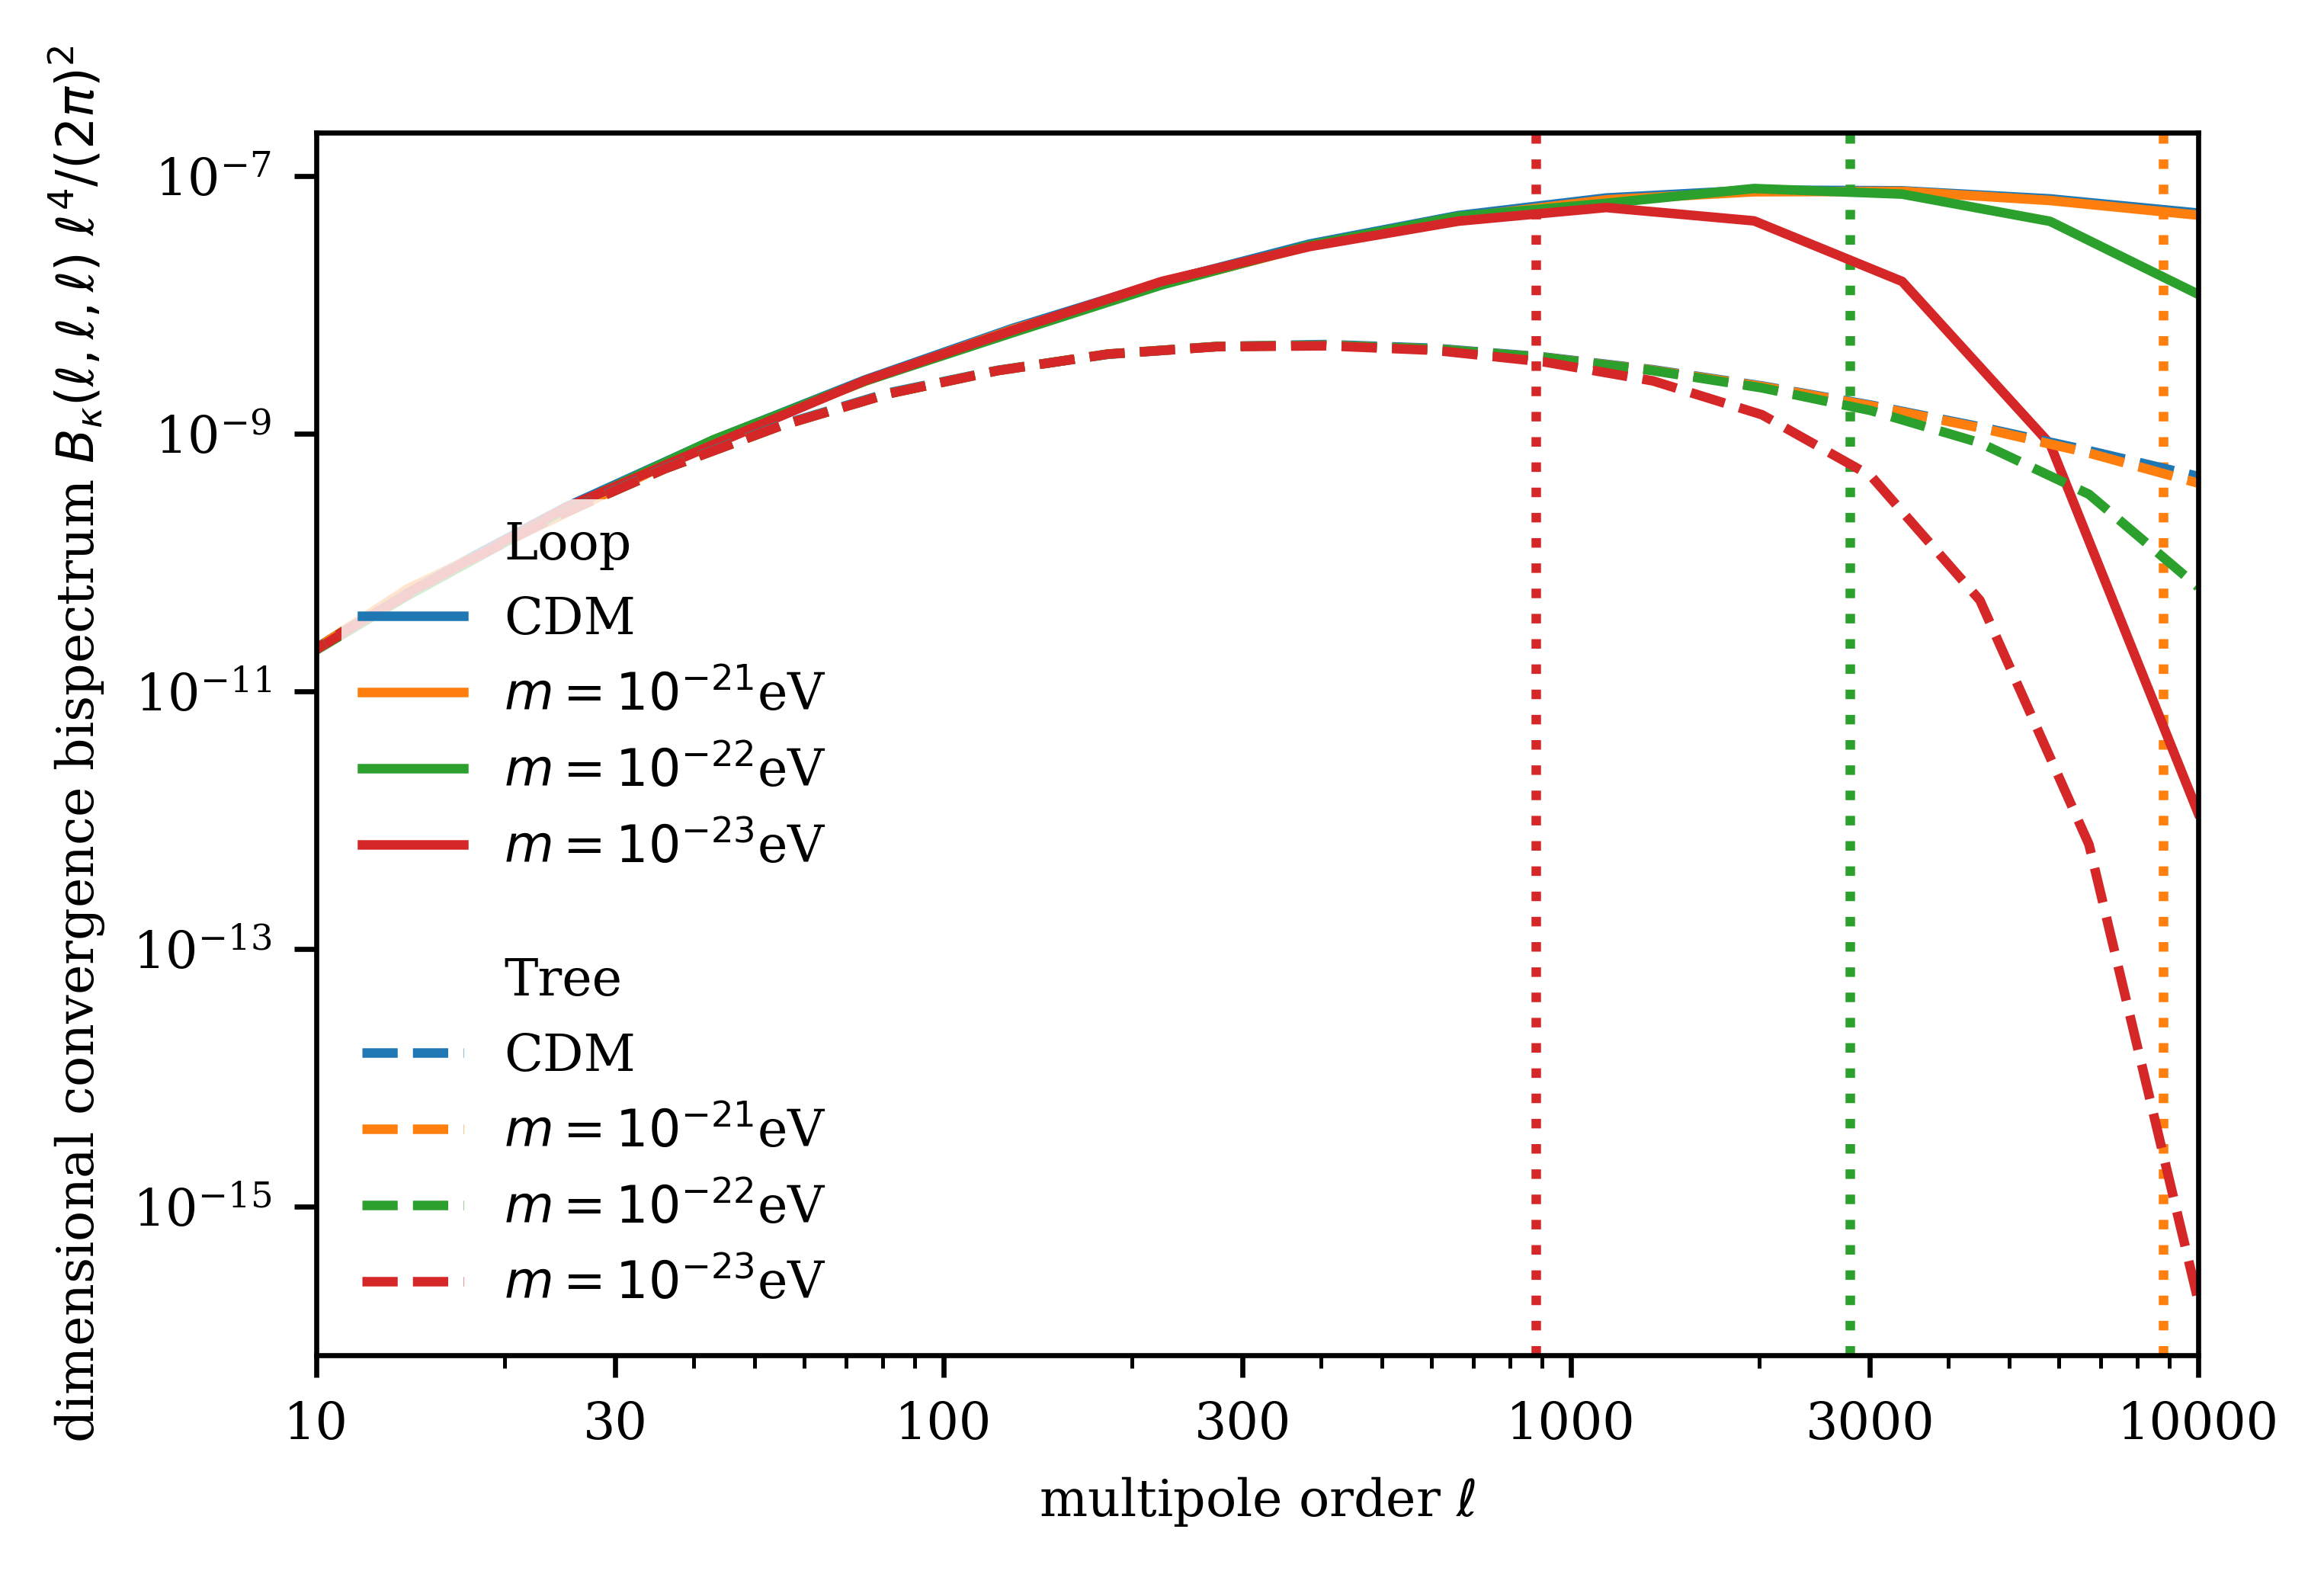

In [275]:
path1 = "../C/data/lensing_bispectrum/equilateral/"

plt.figure(figsize=size, dpi = dpi)

plots = []
files =  ['cdm_loop.dat', 'fdm_loop_m21.dat', 'fdm_loop_m22.dat', 'fdm_loop_m23.dat']

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Loop')
plots.append(p)

for i, file in enumerate(files):
    l, Bk = np.loadtxt(path1 + file, unpack = True, skiprows=1)
    p, = plt.loglog(l, Bk * l**4 / (2*np.pi)**2, label=standard_labels[i], c=colours[i])
    plots.append(p)
    if i > 0:
        plt.axvline(lj(masses[i-1]), c=colours[i], ls = "dotted")

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='\nTree')
plots.append(p)

files = ['cdm_cdm.dat', 'fdm_fdm_m21.dat', 'fdm_fdm_m22.dat', 'fdm_fdm_m23.dat']

for i, file in enumerate(files):
    l, Bk = np.loadtxt(path1 + file, unpack = True, skiprows=1)
    p, = plt.loglog(l, Bk * l**4 / (2*np.pi)**2, label=standard_labels[i], c=colours[i], ls = "dashed")
    plots.append(p)



plt.xlabel(r"multipole order $\ell$")
plt.ylabel(r"dimensional convergence bispectrum $B_{\kappa}(\ell, \ell, \ell)$ $\ell^4/(2\pi)^2$")


aux = [10, 30,100,300,1000,3000,10000]
plt.xticks(aux,aux)
plt.xlim(10, 10000)
leg = plt.legend(handles  = plots, loc = "lower left")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/equilateral_convergence_bispectrum.pdf", bbox_inches='tight')
plt.show()

# Equilateral Trispectrum

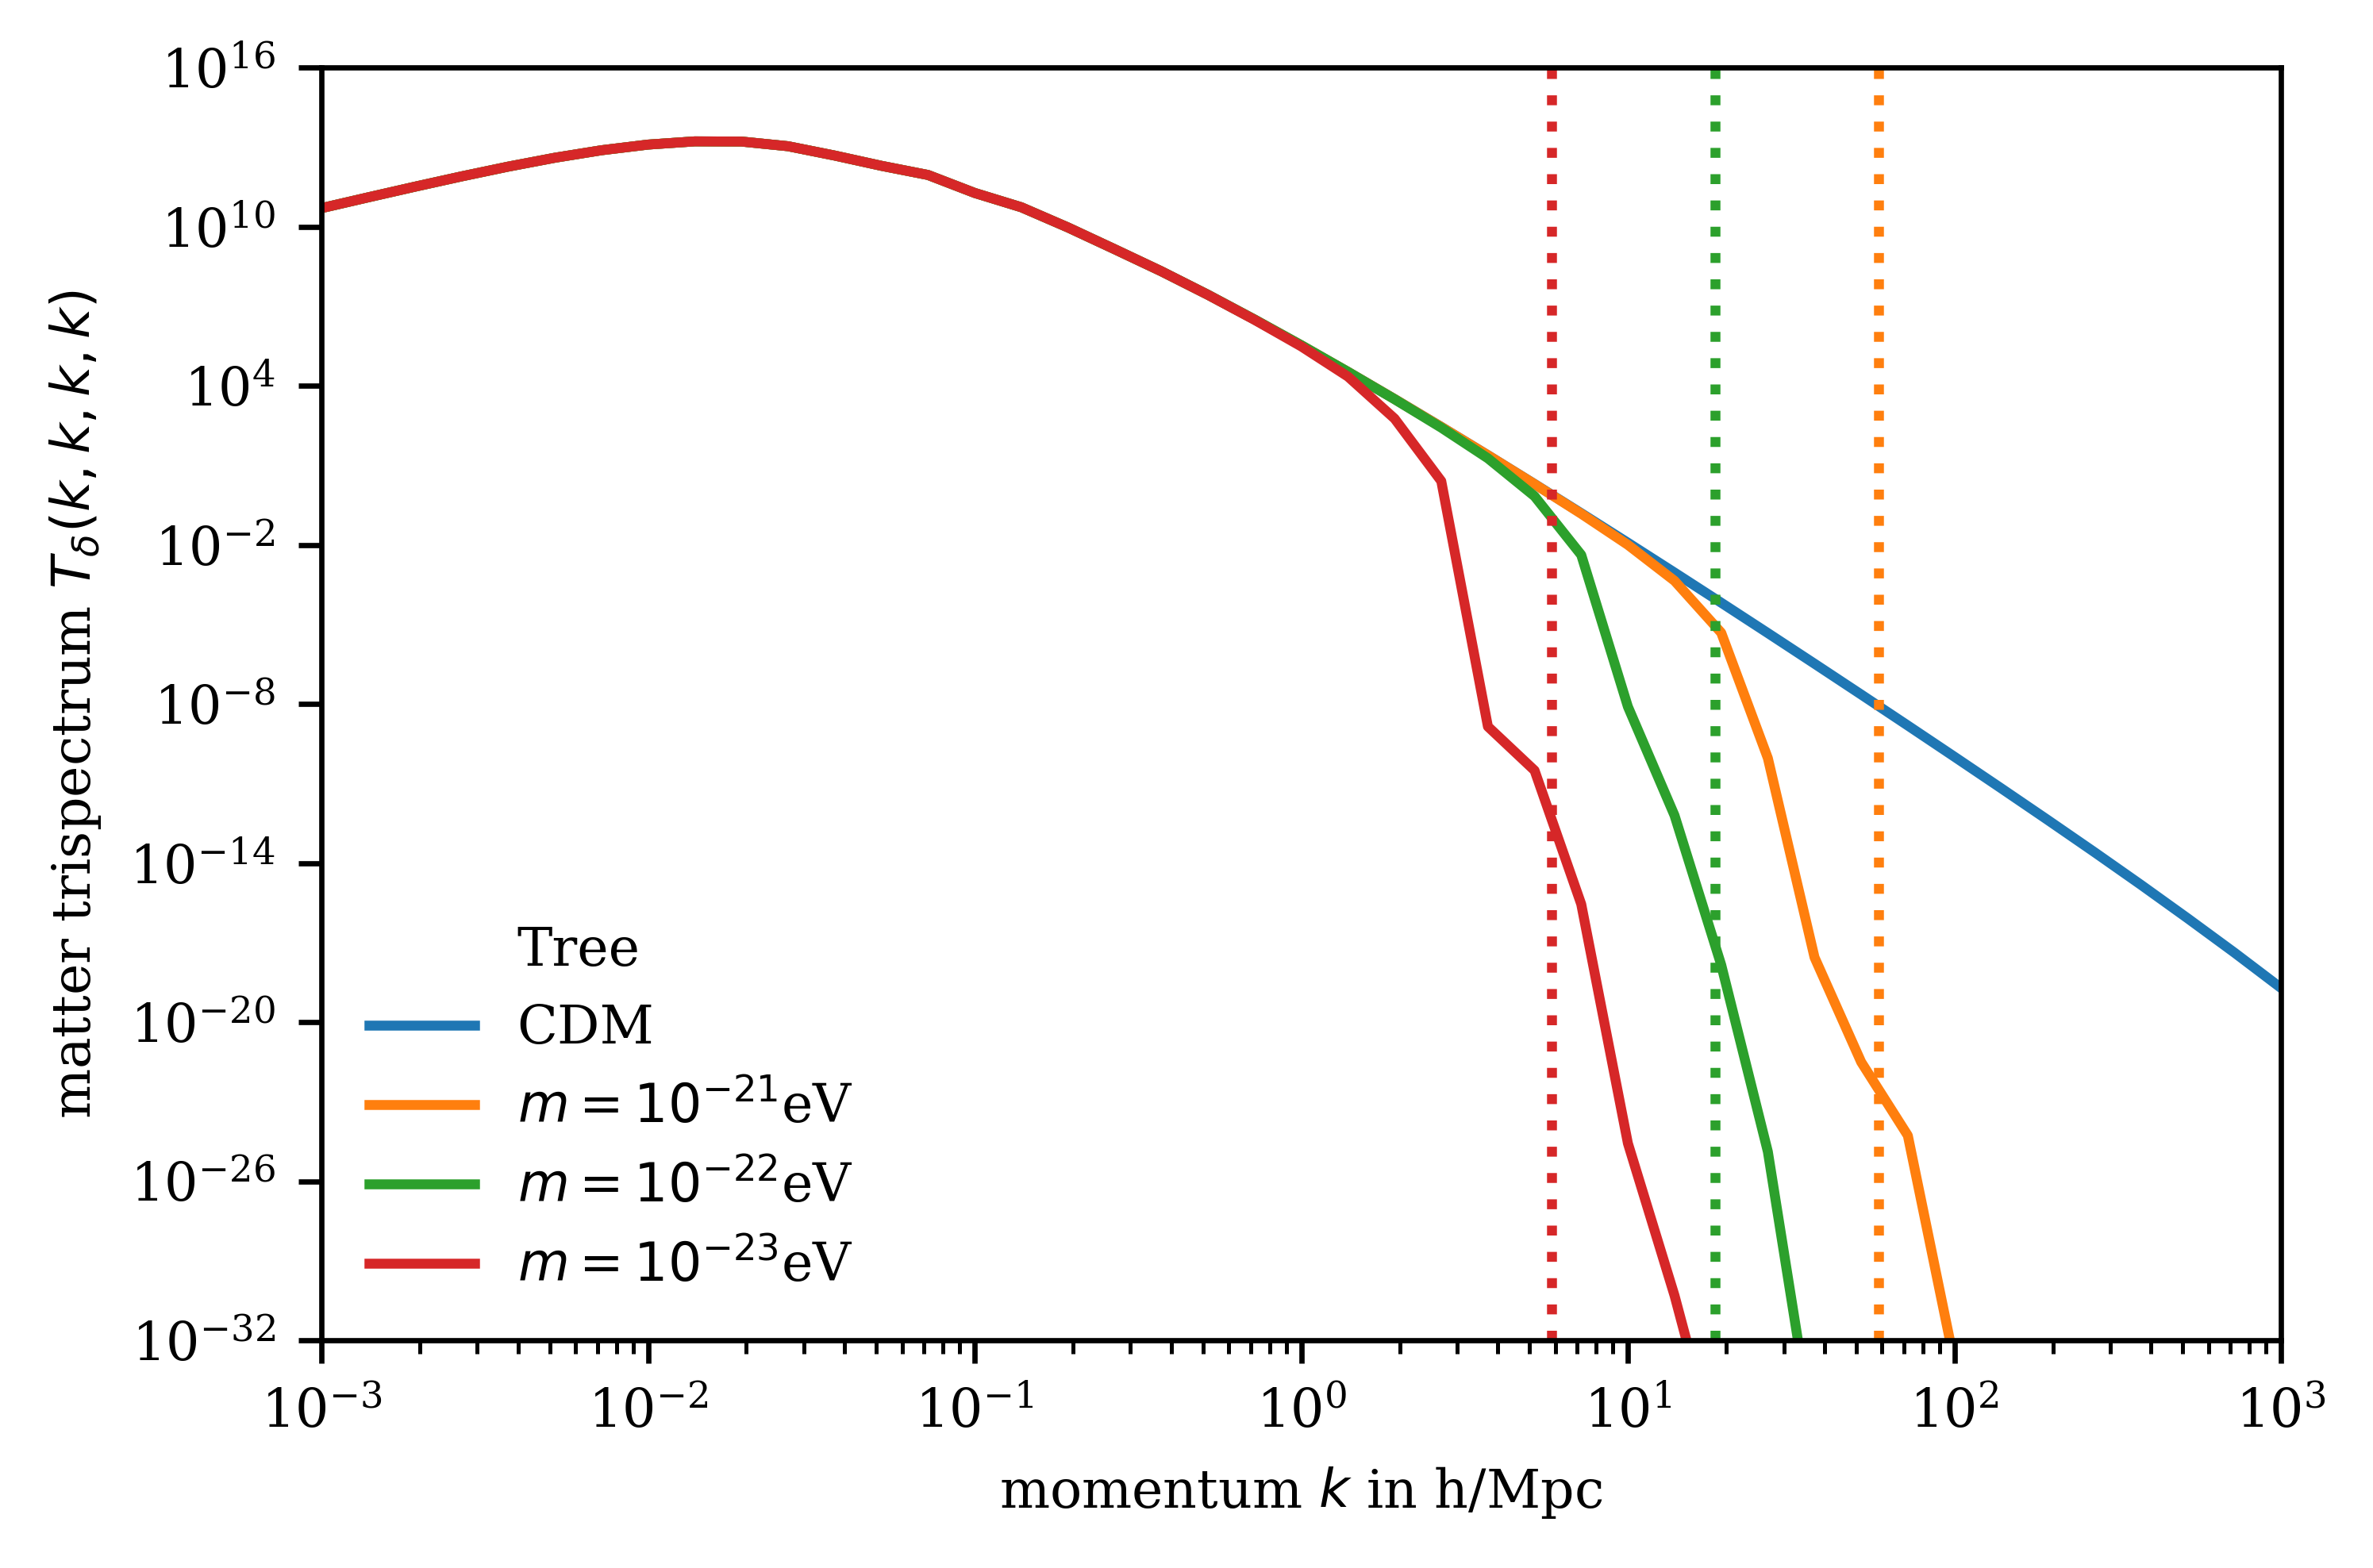

In [7]:
plt.figure(figsize=size, dpi = dpi)
plt.ylabel(r"matter trispectrum $T_{\delta}(k, k, k, k)$")
plt.xlabel(r"momentum $k$ in $h$/Mpc")

path = "data/trispectrum/equilateral/"

plots = []

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Tree')
plots.append(p)


for i, file in enumerate(standard_files):
    k, T = np.loadtxt(path + file, unpack = True, skiprows=1)
    p, = plt.loglog(k, T, label=standard_labels[i], c=colours[i])
    if i > 0:
        plt.axvline(li_kj(a0, masses[i-1]), c=colours[i], ls = "dotted")
    plots.append(p)



plt.xlim(1e-3, 1000)
plt.ylim(1e-32, 1e16)
leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)
plt.savefig("../figures/equilateral_matter_trispectrum.pdf", bbox_inches='tight')
plt.show()


# Lensing Trispectrum

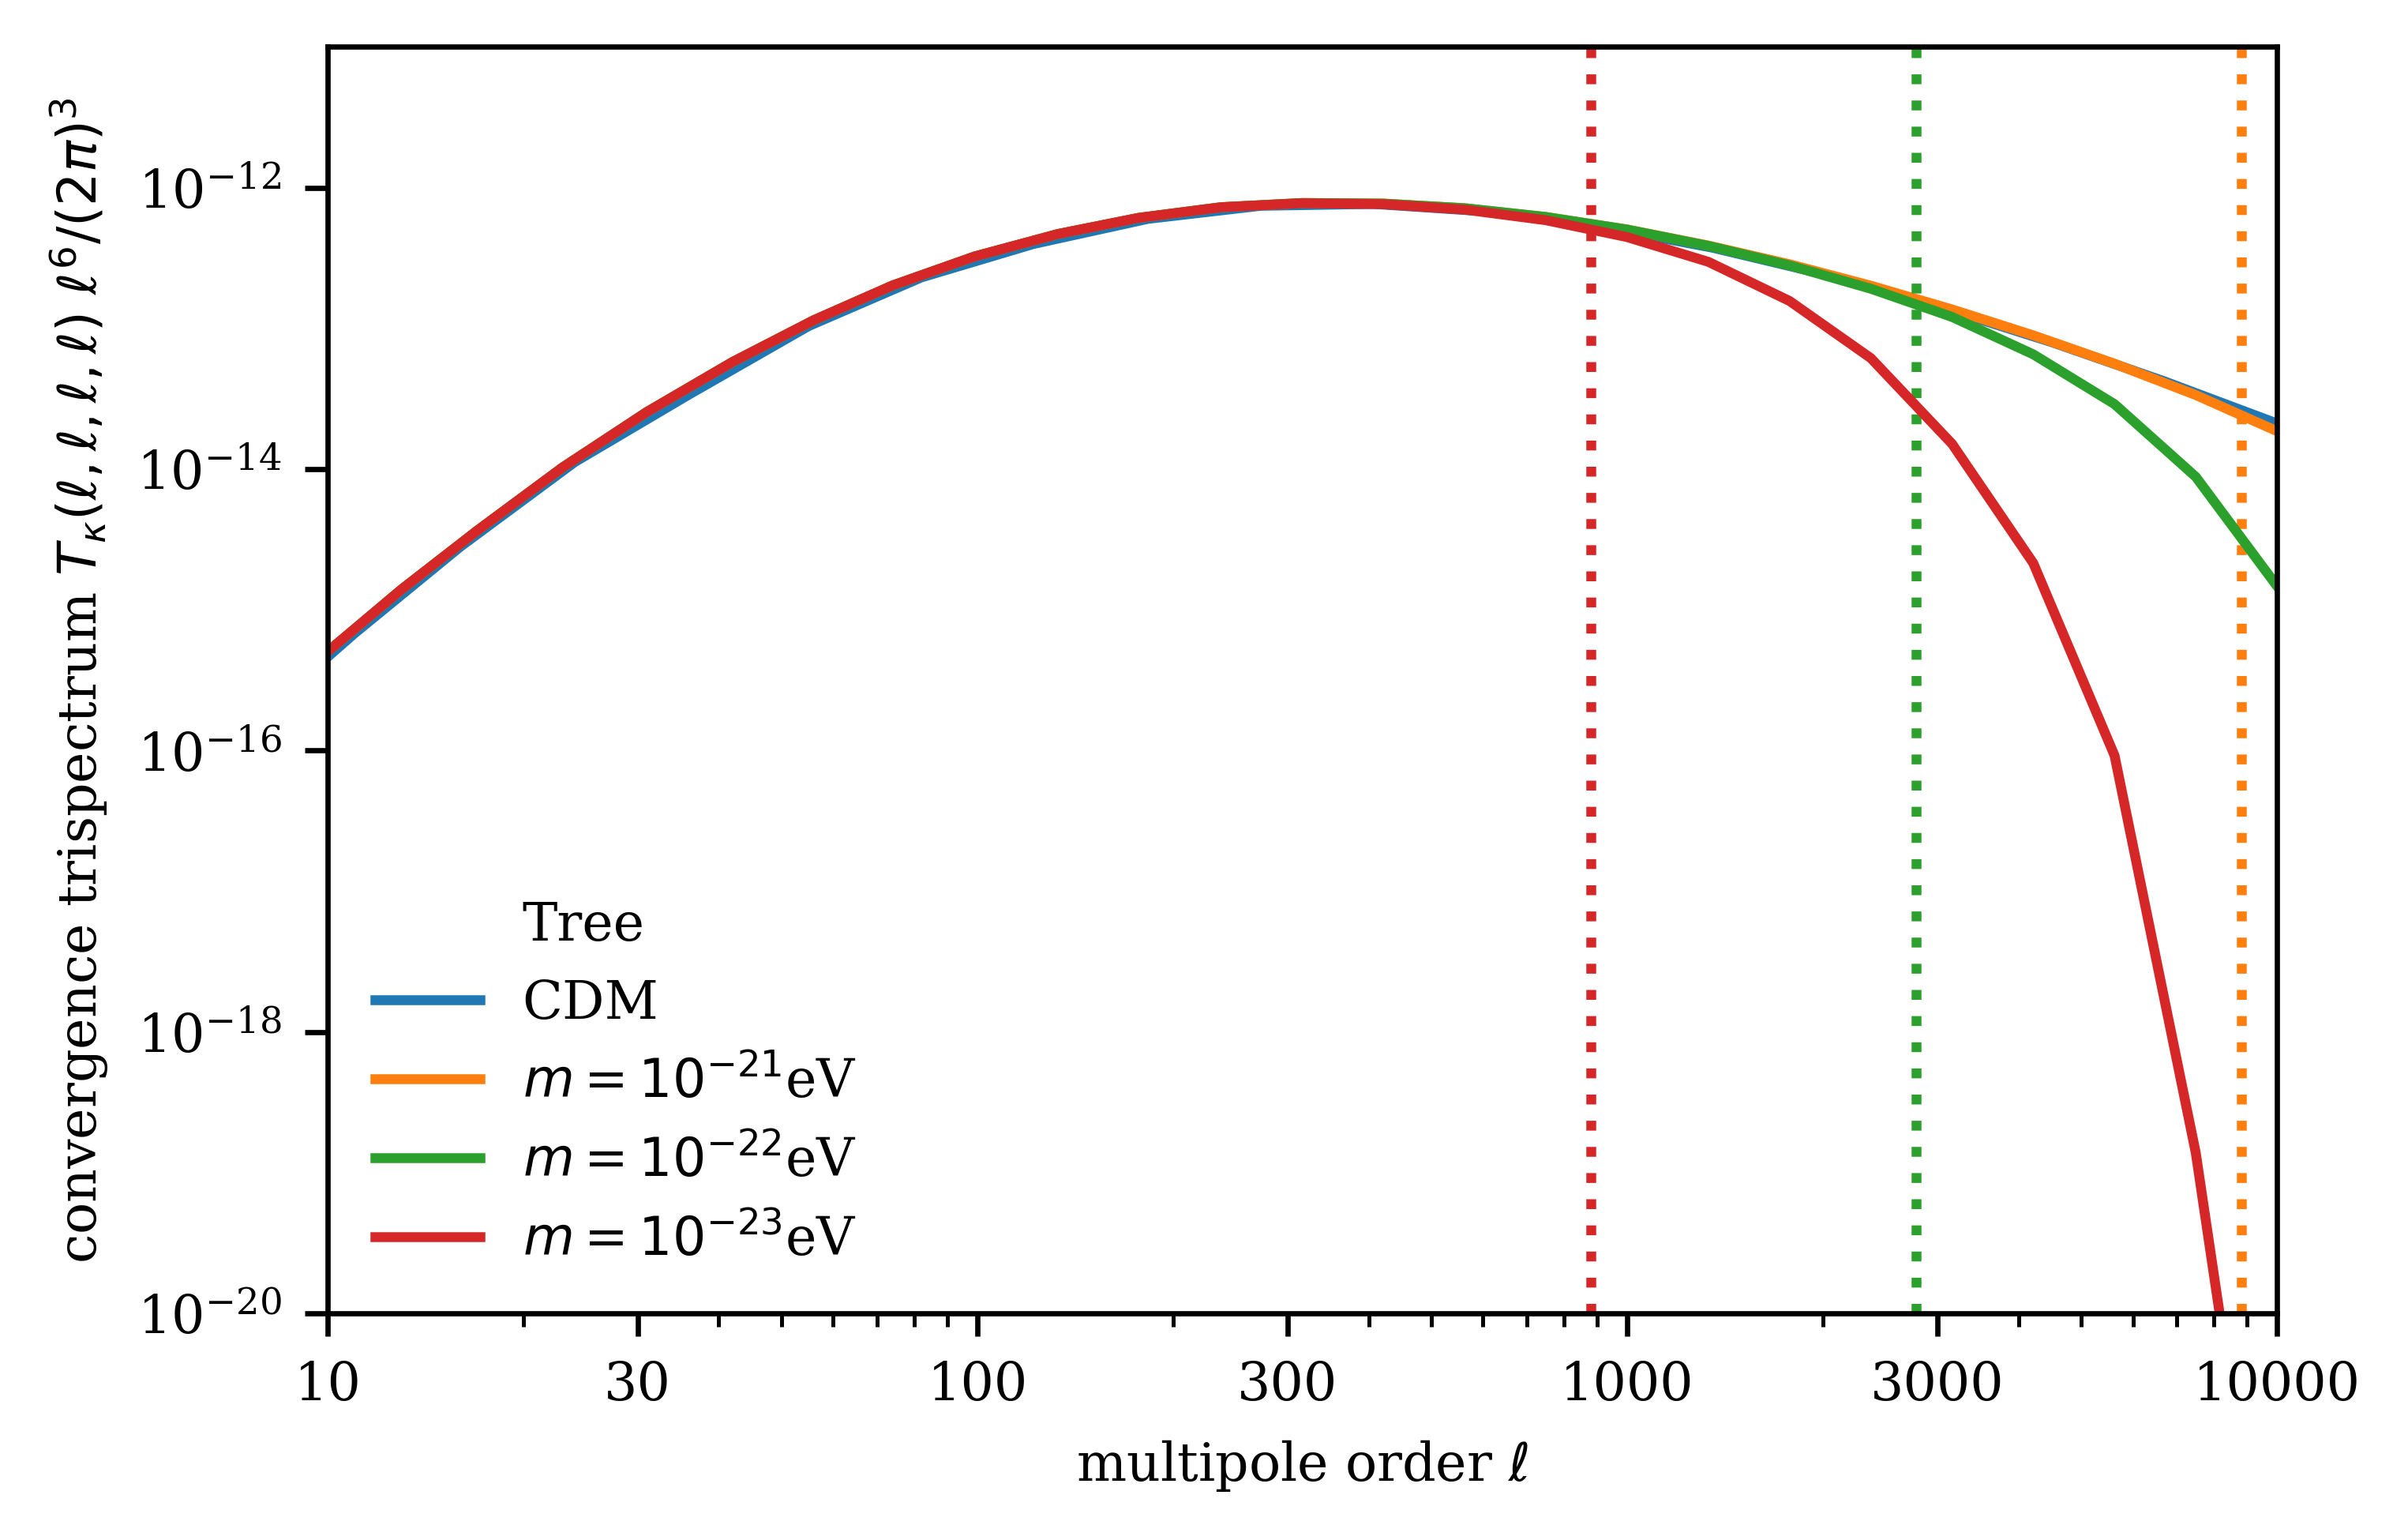

In [271]:
plt.figure(figsize=size, dpi=dpi)
import seaborn as sns 
path = "data/lensing_trispectrum/equilateral/"


plots = []

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Tree')
plots.append(p)

path = "data/lensing_trispectrum/equilateral/"

for i, file in enumerate(standard_files):
    l, Tk = np.loadtxt(path + file, unpack = True, skiprows=1)
    p, = plt.loglog(l, Tk * l**6 / (2*np.pi)**3, label=standard_labels[i], c = colours[i])
    plots.append(p)
    if i > 0:
        plt.axvline(lj(masses[i-1]), c=colours[i], ls = "dotted")


plt.xlabel(r"multipole order $\ell$")
plt.ylabel(r"convergence trispectrum $T_{\kappa}(\ell, \ell, \ell, \ell)$ $\ell^6/(2\pi)^3$")
aux = [10, 30,100,300,1000,3000,10000]
plt.xticks(aux,aux)
plt.xlim(10, 10000)
plt.ylim(1e-20, 1e-11)
leg = plt.legend(handles = plots, loc="lower left")
leg.get_frame().set_linewidth(0.0)

plt.savefig("../figures/equilateral_convergence_trispectrum.pdf", bbox_inches='tight')
plt.show()


## Integrated Convergence S2N

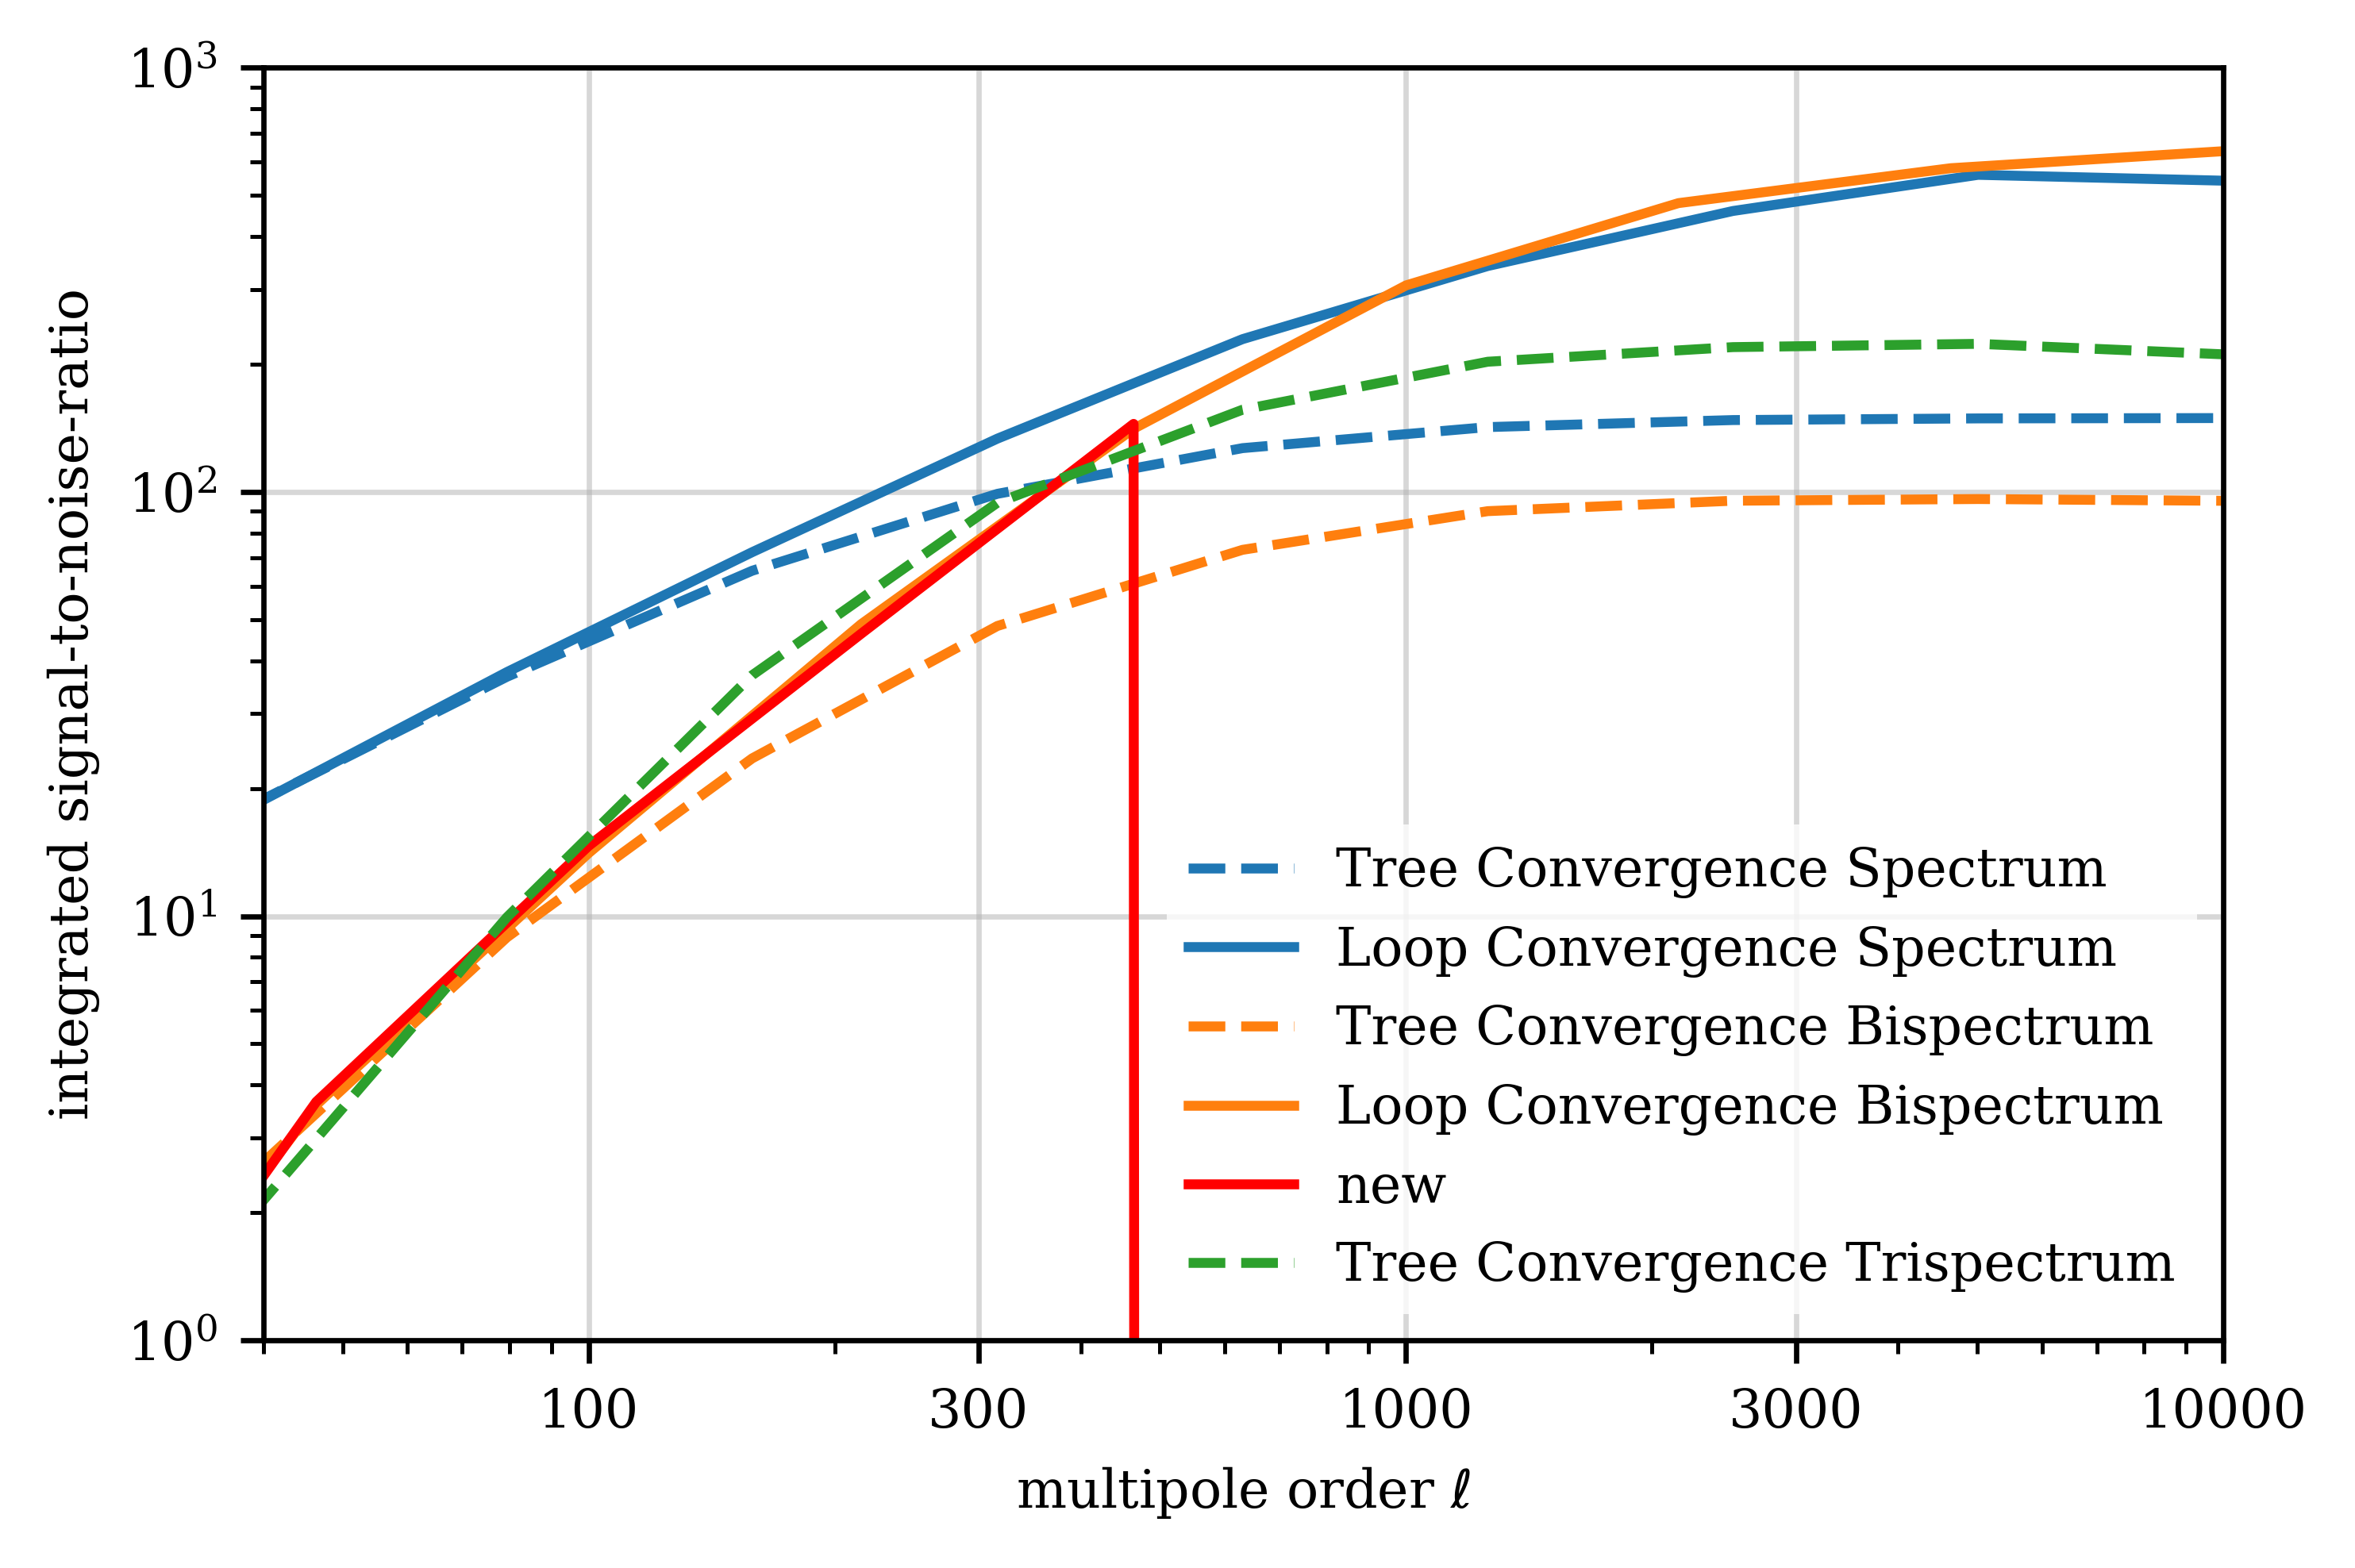

In [14]:
plt.figure(figsize=size, dpi = dpi)
    
path   = "../C/data/lensing_spectrum/s2n/"


files = ['1_cdm.dat']#, 
        #"1_fdm_m21.dat", 
        #"1_fdm_m22.dat", 
        #"1_fdm_m23.dat"
        #]
labels = ["Tree Convergence Spectrum"]#,
          #r'$P_{\kappa}^{(0)}$ $m = 10^{-21}$eV',
          #r'$P_{\kappa}^{(0)}$ $m = 10^{-22}$eV',
          #r'$P_{\kappa}^{(0)}$ $m = 10^{-23}$eV'
          #]


for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=labels[i], ls="dashed", c = "C0")
    

labels = ["Loop Convergence Spectrum"]#,
          #"$P_{\kappa}^{(1)}$ $m = 10^{-21}$eV",
          #"$P_{\kappa}^{(1)}$ $m = 10^{-22}$eV",
          #"$P_{\kappa}^{(1)}$ $m = 10^{-23}$eV"
          #]

files = ['1_cdm_loop.dat']#,
         #'1_fdm_loop_m21.dat',
         #'1_fdm_loop_m22.dat' ,
         #'1_fdm_loop_m23.dat']

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=labels[i], c = "C0")
    

path  = "../C/data/lensing_bispectrum/s2n/"
files = ["1_cdm.dat"]
labels = [r'Tree Convergence Bispectrum']

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=labels[i], ls="dashed", c = "C1")


path  = "data/lensing_bispectrum/s2n/"
files = ["1_cdm_loop_gsl.dat"]
labels = [r'Loop Convergence Bispectrum']

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=labels[i], c = "C1")


path  = "data/lensing_bispectrum/s2n/"
files = ["1_temp.dat"]
labels = [r'Loop Convergence Bispectrum']

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label="new", c = "r")

#labels = [r'$B_{\kappa}^{(0)}$ $m = 10^{-21}$', r'$B_{\kappa}^{(0)}$  $m = 10^{-22}$', r'$B_{\kappa}^{(0)}$  $m = 10^{-23}$']
#files = ["1_fdm_m21.dat", "1_fdm_m22.dat", "1_fdm_m23.dat"]
#
#for i, file in enumerate(files):
#    l, local_s2n, equil_s2n, ortho_s2n, fdm_s2n, cdm_s2n = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, fdm_s2n, label=labels[i])


path   = "../C/data/lensing_trispectrum/s2n/"
files  = ["1_cdm.dat"]
labels = ["Tree Convergence Trispectrum"]

for file, label in zip(files, labels):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=label, ls="dashed", c= "C2")

aux = [100, 300, 1000, 3000, 10000]
plt.xticks(aux,aux)
plt.xlim(40, 10000)
plt.ylim(1, 1000)
plt.xlabel(f"multipole order $\ell$")
plt.ylabel("integrated signal-to-noise-ratio")
leg = plt.legend(loc="lower right")
leg.get_frame().set_linewidth(0.0)
plt.grid(visible=True, alpha=0.5)
plt.savefig("../figures/s2n_ratios.pdf", bbox_inches='tight')
plt.show()

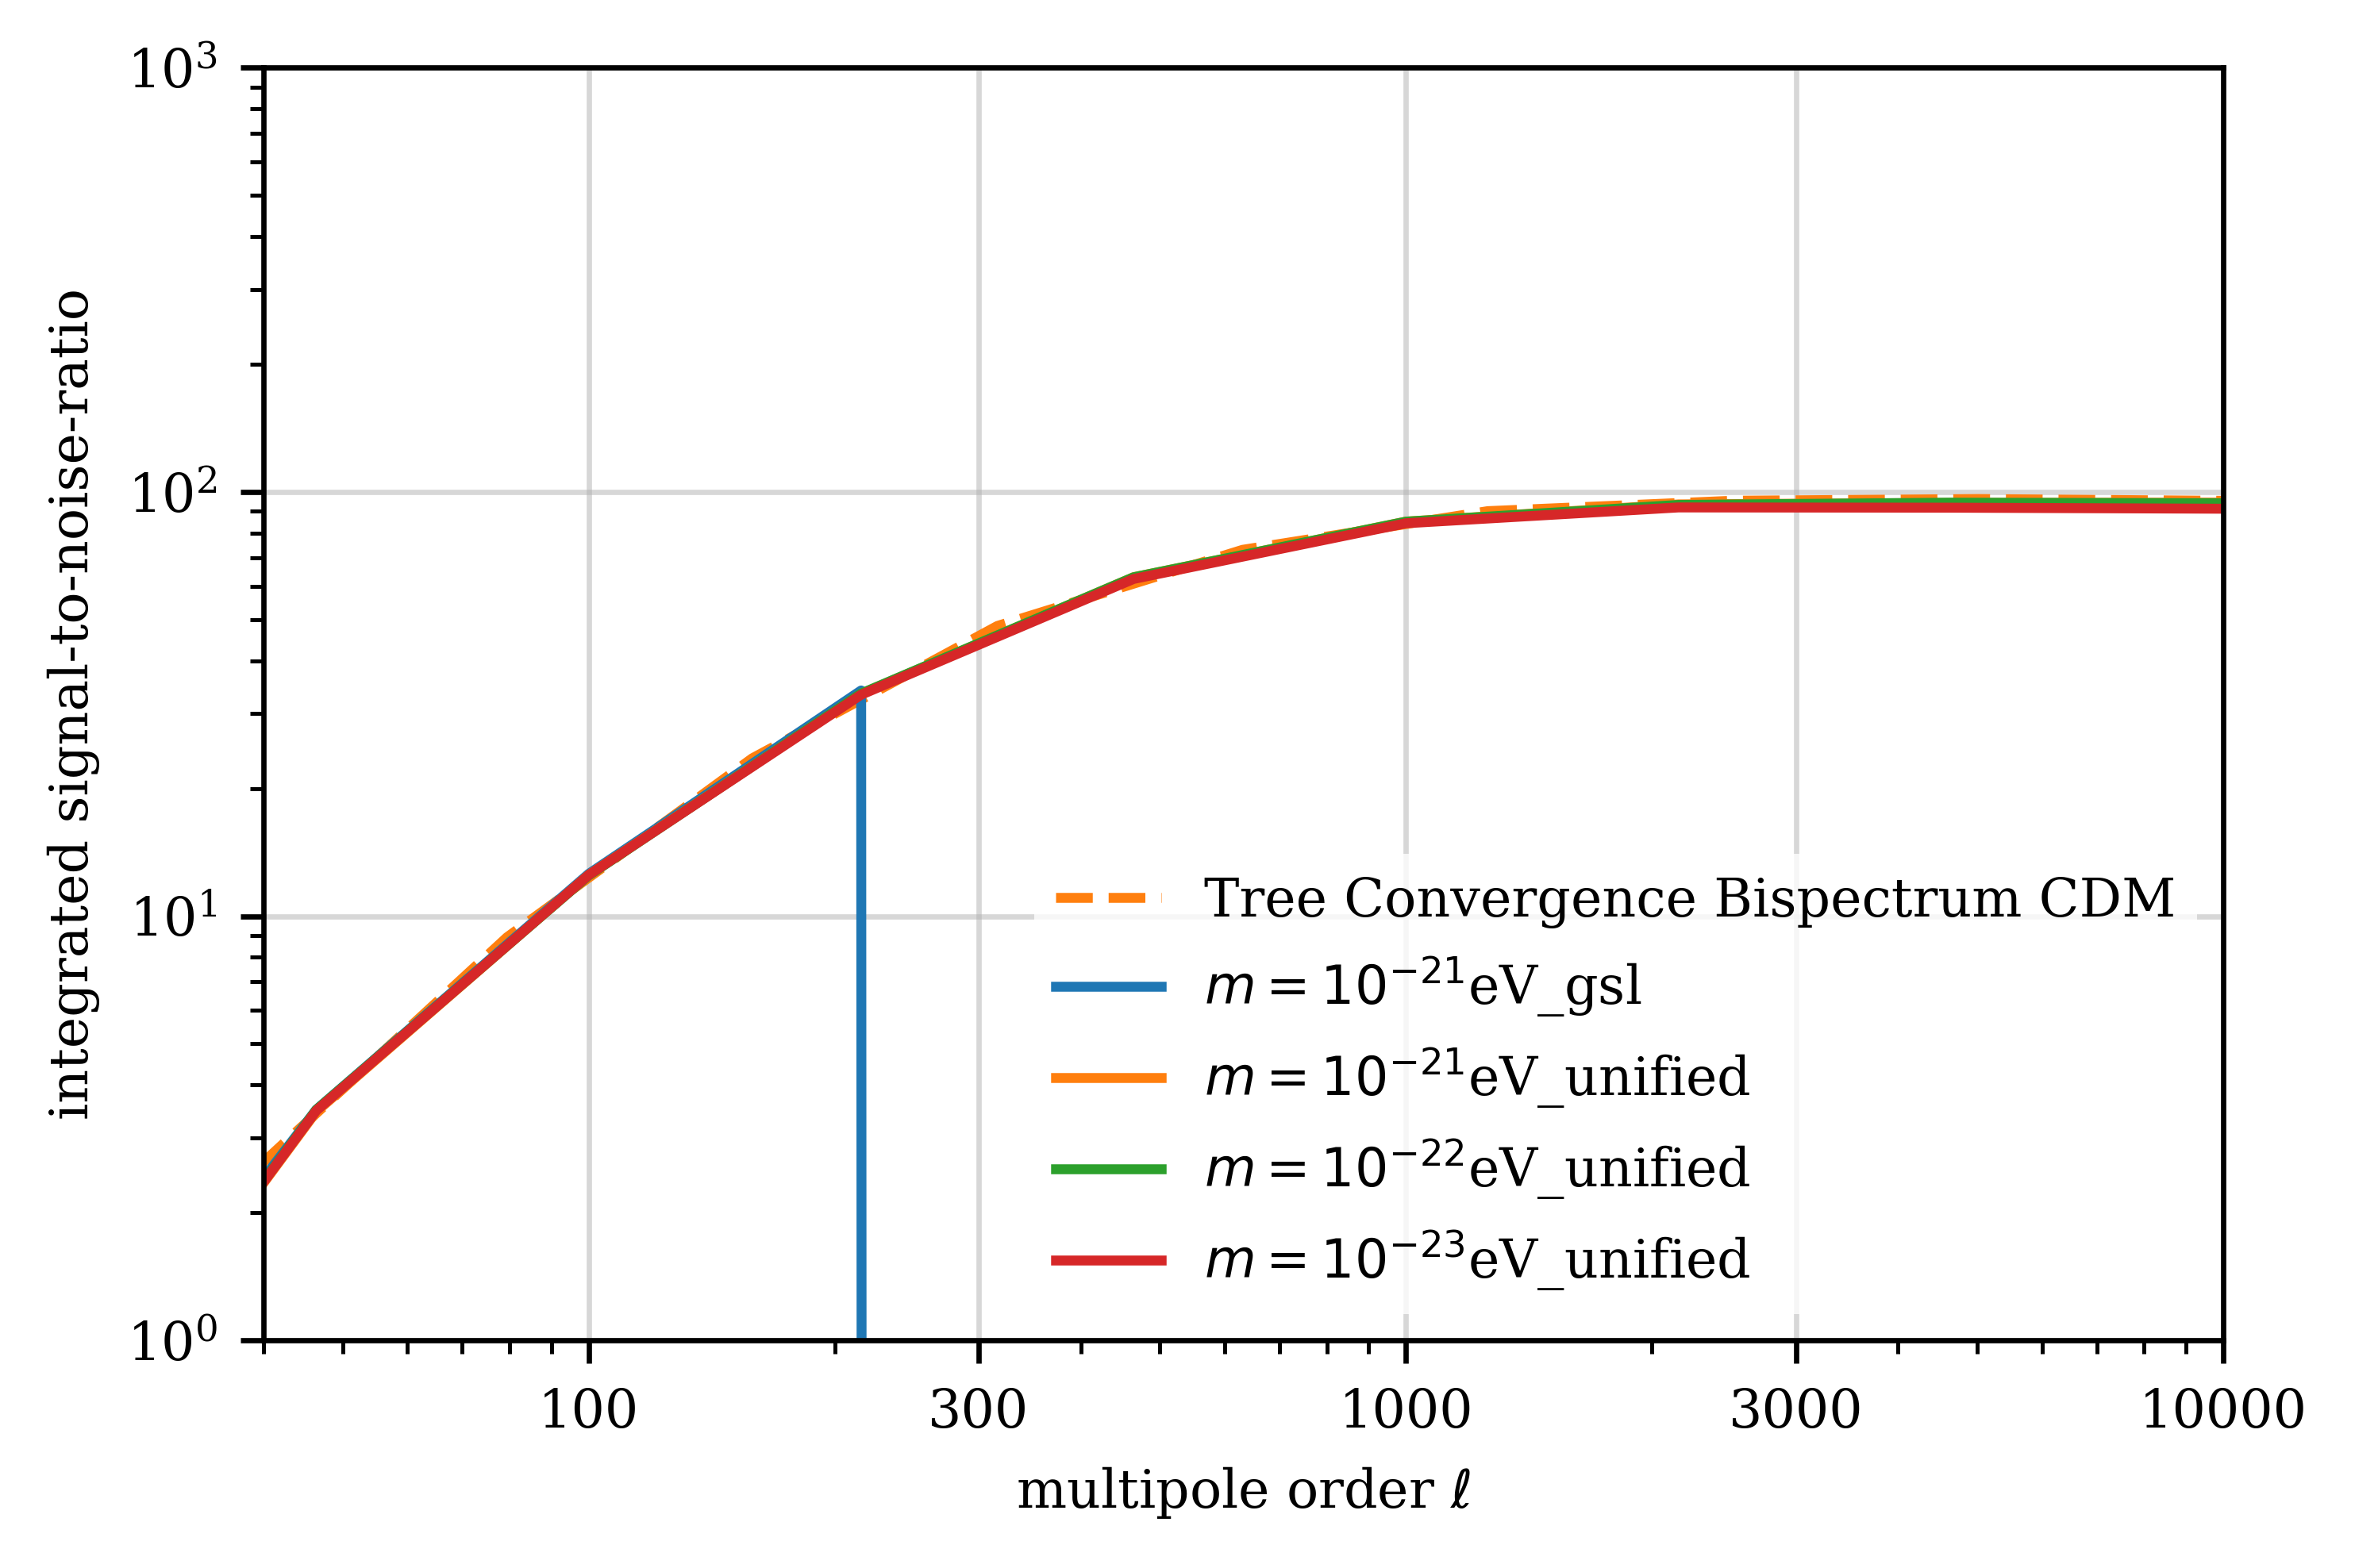

In [9]:
plt.figure(figsize=size, dpi = dpi)
    
path  = "../C/data/lensing_bispectrum/s2n/"
files = ["1_cdm.dat"]
labels = [r'Tree Convergence Bispectrum CDM']

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=labels[i], ls="dashed", c = "C1")


path  = "data/lensing_bispectrum/s2n/"
files = ["fdm_m21.dat"]

for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=standard_labels[i+1] + "_gsl")


path  = "data/lensing_bispectrum/s2n/"
files = ["1_m21_unified_tree.dat", "1_m22_unified_tree.dat", "1_m23_unified_tree.dat"]
for i, file in enumerate(files):
    l, s2n = np.loadtxt(path + file, unpack = True)
    plt.loglog(l, s2n, label=standard_labels[i+1] + "_unified")


aux = [100, 300, 1000, 3000, 10000]
plt.xticks(aux,aux)
plt.xlim(40, 10000)
plt.ylim(1, 1000)
plt.xlabel(f"multipole order $\ell$")
plt.ylabel("integrated signal-to-noise-ratio")
leg = plt.legend(loc="lower right")
leg.get_frame().set_linewidth(0.0)
plt.grid(visible=True, alpha=0.5)
plt.show()

## $\chi^2$ for distinguishing CDM and FDM 

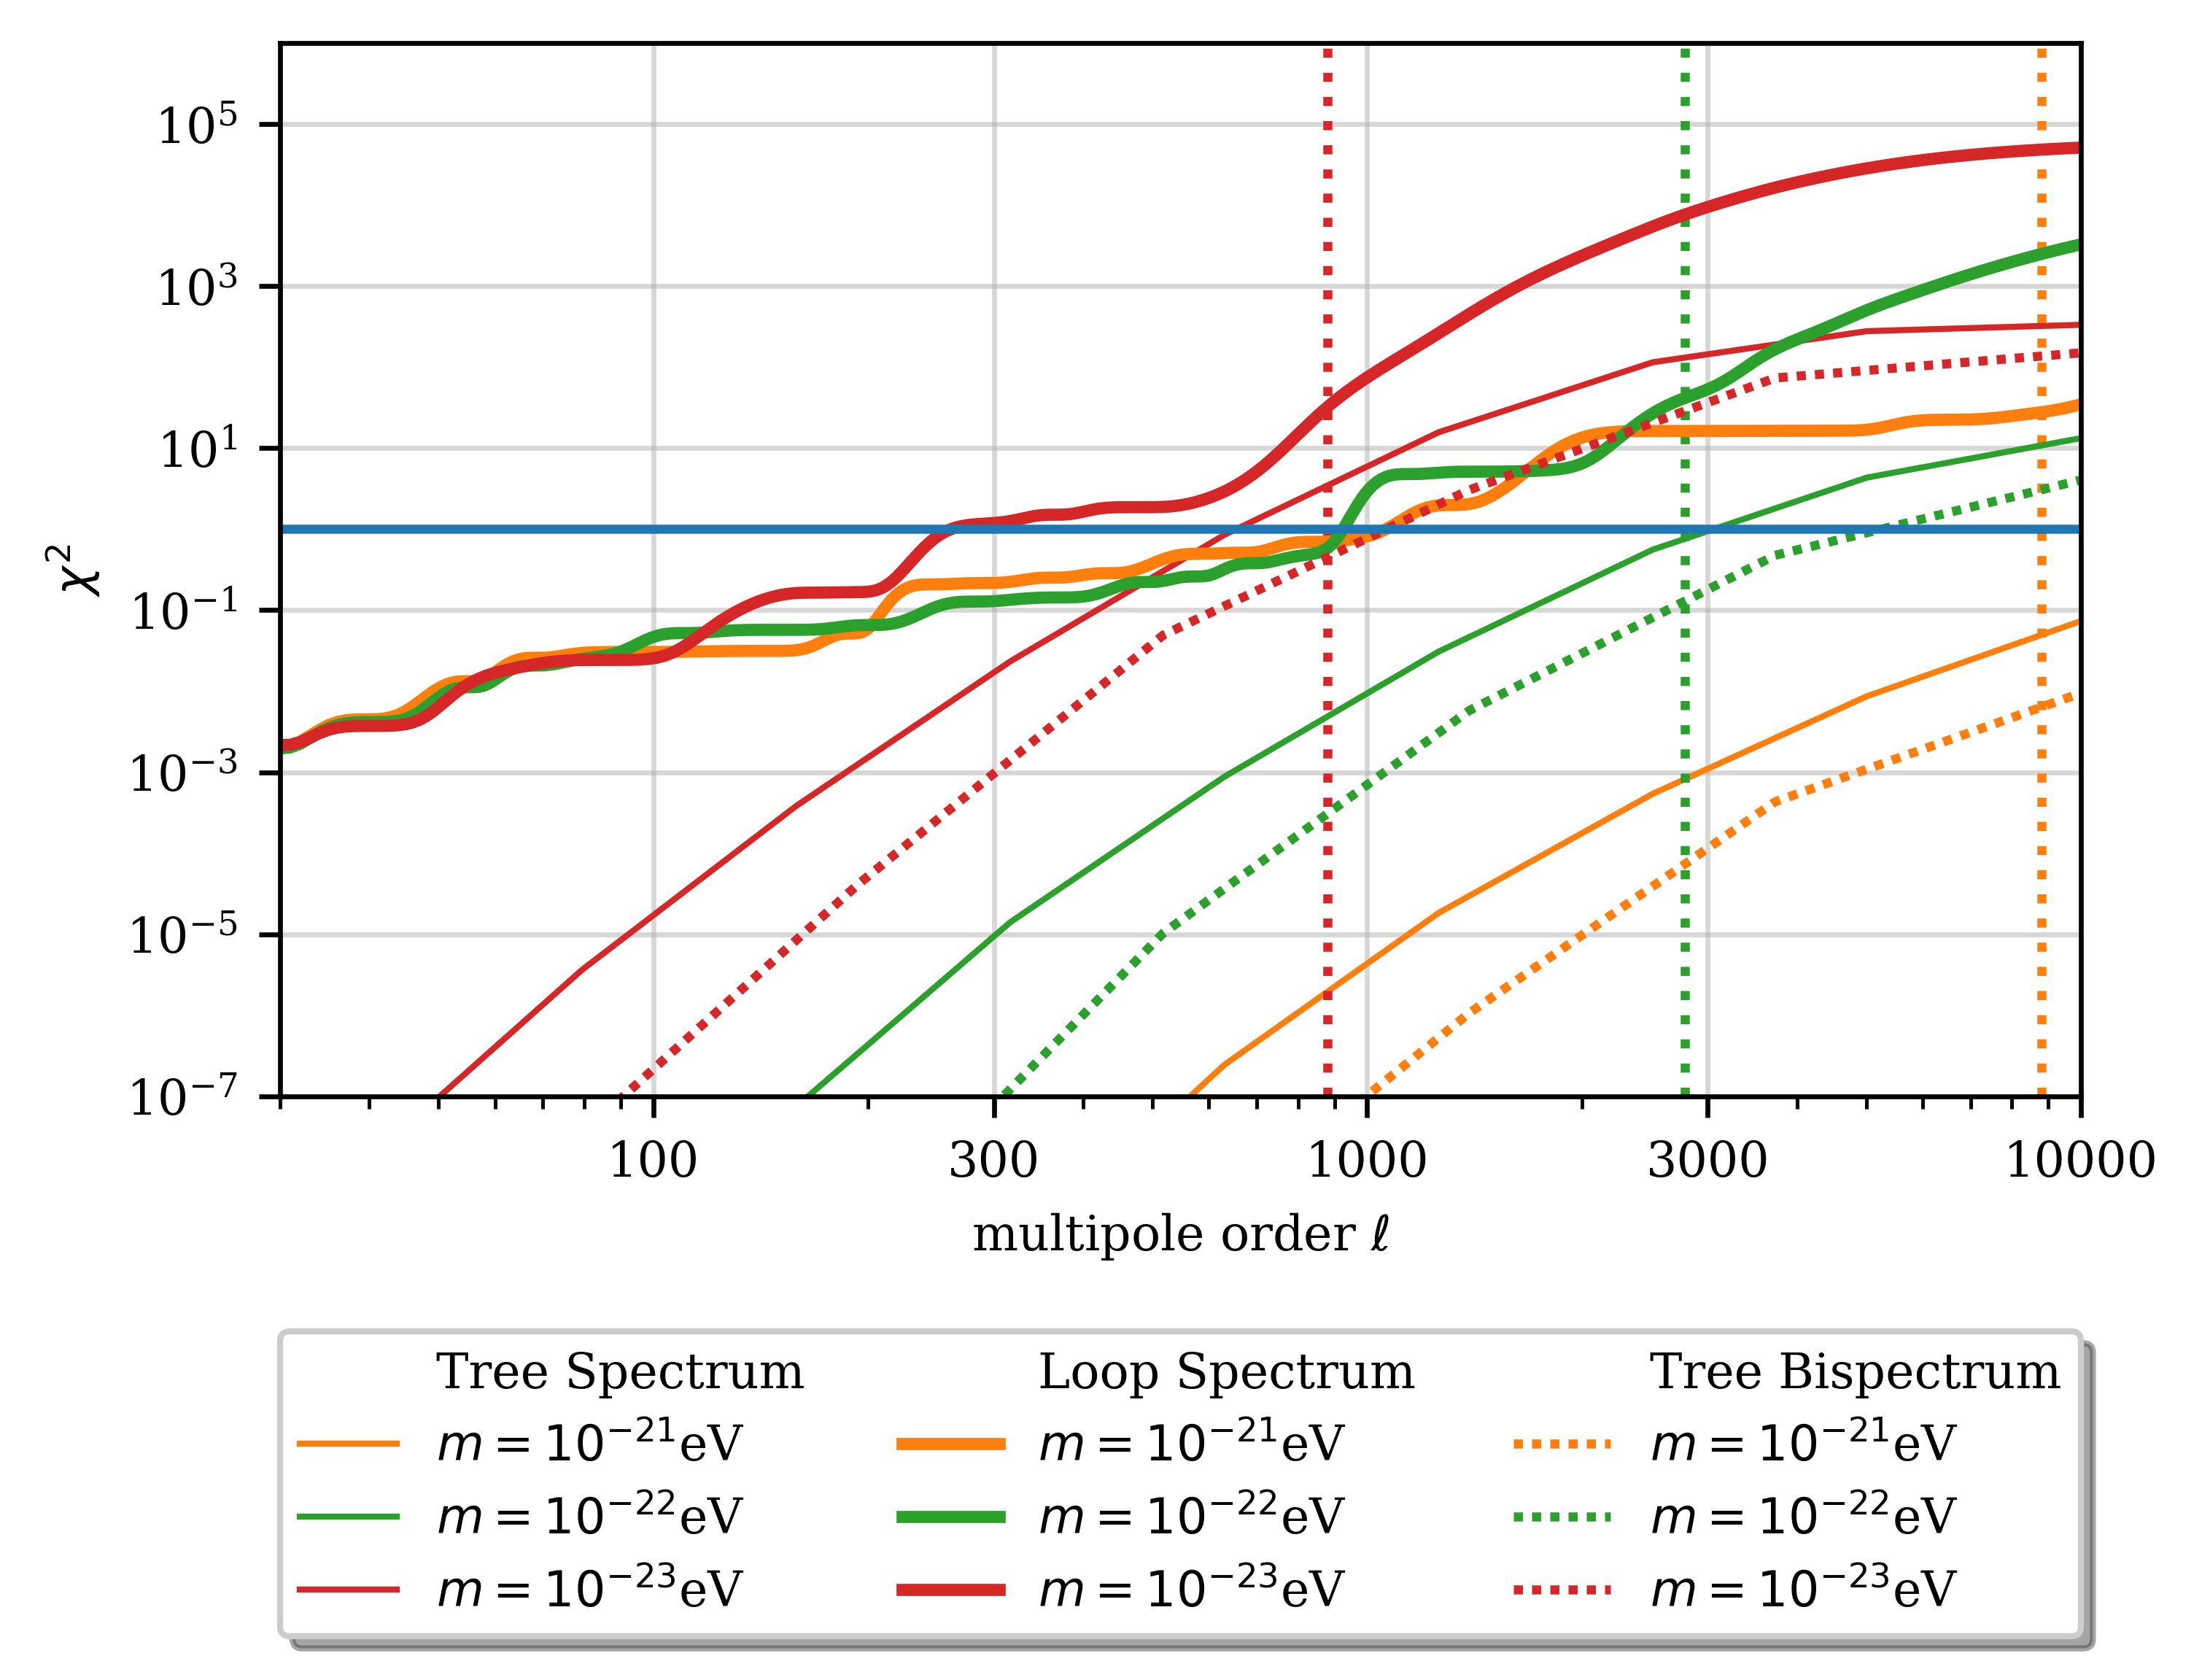

In [289]:

fig, ax = plt.subplots(figsize=size, dpi = dpi)


path   = "../C/data/lensing_spectrum/chi_squared/"
files  = [  '1_fdm_m21_unified.dat', 
            '1_fdm_m22_unified.dat', 
            '1_fdm_m23_unified.dat']


plots = []

p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Tree Spectrum')
plots.append(p)

for i, file in enumerate(files):
    l, chisq = np.loadtxt(path + file, unpack = True)
    p, = plt.loglog(l, chisq, label=standard_labels[i + 1], c = colours[i + 1], lw = 1, ls="solid")
    plots.append(p)
    plt.axvline(lj(masses[i]), c=colours[i + 1], ls = "dotted")


#path   = "data/lensing_spectrum/chi_squared/"
#files  = [  '1_m21_gsl.dat', 
#            '1_m22_gsl.dat', 
#            '1_m23_gsl.dat']
#labels = ["New $P_{\kappa}^{(0)}$ $m = 10^{-21}$eV",
#          "New $P_{\kappa}^{(0)}$ $m = 10^{-22}$eV", 
#          "New $P_{\kappa}^{(0)}$ $m = 10^{-23}$eV"]
#
#for i, file in enumerate(files):
#    l, chisq = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, chisq, label=labels[i],  lw = 1, ls="dashed")


#path   = "data/lensing_spectrum/chi_squared/"
#files  = [  '1_fdm_loop_m21.dat', 
#            '1_fdm_loop_m22.dat', 
#            '1_fdm_loop_m23.dat']
#labels = ["$P_{\kappa}^{(1)}$ $m = 10^{-21}$eV",
#          "$P_{\kappa}^{(1)}$ $m = 10^{-22}$eV", 
#          "$P_{\kappa}^{(1)}$ $m = 10^{-23}$eV"]
#
#for i, file in enumerate(files):
#    l, chisq = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, chisq, label=labels[i], c = colours[i + 1], lw = 1, ls="solid")



#path   = "data/lensing_spectrum/chi_squared/"
#files  = [  '1_fdm_m21_spline_1pcutoff.dat',
#            '1_fdm_m22_spline_1pcutoff.dat',
#            '1_fdm_m23_spline_1pcutoff.dat']
#
#labels = [ 
#    "$P_{\kappa}^{(1)}$ $m = 10^{-21}$eV with 1% cutoff",
#    "$P_{\kappa}^{(1)}$ $m = 10^{-22}$eV with 1% cutoff",
#    "$P_{\kappa}^{(1)}$ $m = 10^{-23}$eV with 1% cutoff"
#]
#
#for i, file in enumerate(files):
#    l, chisq = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, chisq, label=labels[i], c = colours[i + 1], lw = 2, ls="dashed")


path   = "../C/data/lensing_spectrum/chi_squared/"
files  = [  '1_fdm_m21_spline.dat',
            '1_fdm_m22_spline.dat',
            '1_fdm_m23_spline.dat']


p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Loop Spectrum')
plots.append(p)

for i, file in enumerate(files):
    l, chisq = np.loadtxt(path + file, unpack = True)
    p, = plt.loglog(l, chisq, label=standard_labels[i + 1], c = colours[i + 1], lw = 2, ls="solid")
    plots.append(p)


path   = "data/lensing_bispectrum/chi_squared/"
files  = [
    '1_m21_unified.dat',
    '1_m22_unified.dat',
    '1_m23_unified.dat',
]


p = mlines.Line2D([0], [0], color='steelblue', ls='--',lw=0, label='Tree Bispectrum')
plots.append(p)


for i, file in enumerate(files):
    l, chisq = np.loadtxt(path + file, unpack = True)
    p, = plt.loglog(l, np.abs(chisq), c = colours[i + 1], label=standard_labels[i + 1], ls=(0, (1, 1)))
    plots.append(p)

#path   = "data/lensing_trispectrum/chi_squared/"
#files  = [
#    '1_m21_unified.dat',
#    '1_m22_unified.dat',
#    '1_m23_unified.dat'
#]
#labels = [
#    "$T_{\kappa}^{(0)}$ $m = 10^{-21}$eV",
#    "$T_{\kappa}^{(0)}$ $m = 10^{-22}$eV",
#    "$T_{\kappa}^{(0)}$ $m = 10^{-22}$eV"
#]
#
#for i, file in enumerate(files):
#    l, chisq = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, np.abs(chisq), label=labels[i], c = f"C{i+4}", ls=(0, (10, 1)))


#path   = "data/lensing_trispectrum/chi_squared/"
#files  = [
#    '1_m21_cuba_mod.dat',
#    '1_m22_cuba_mod.dat',
#    '1_m23_cuba_mod.dat',
#]
#labels = [
#    "$T_{\kappa}^{(0)}$ $m = 10^{-21}$eV MOD",
#    "$T_{\kappa}^{(0)}$ $m = 10^{-22}$eV MOD",
#    "$T_{\kappa}^{(0)}$ $m = 10^{-23}$eV MOD",
#]
#
#for i, file in enumerate(files):
#    l, chisq = np.loadtxt(path + file, unpack = True)
#    plt.loglog(l, np.abs(chisq), label=labels[i], c = colours[i + 1], ls=(0, (10, 1)))


plt.xlim(30, 10000)
aux = [100, 300,1000,3000, 10000]
plt.xticks(aux,aux)
plt.axhline(y=1, label=r"$\chi^2$ = 1", c = colours[0])
plt.ylim(1e-7, 1e6)

plt.xlabel(r"multipole order $\ell$")
plt.ylabel(r"$\chi^2$")

leg = plt.legend(handles = plots, bbox_to_anchor=(-0.1,-0.15), loc="upper left", ncol=3)

#leg.get_frame().set_linewidth(0.0)

plt.grid(visible=True, alpha=0.5)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), handles = plots,
          fancybox=True, shadow=True, ncol=3)

plt.savefig("../figures/chi_squared.pdf", bbox_inches='tight')
